In [1]:
import numpy as np
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from collections import defaultdict


## Validating Partition Structure

In [2]:
# paths
metis_path = f"../../data/superblue/superblue_1/metis_part_dict.pkl"
pl_path = f"../../data/superblue/superblue_1/pl_part_dict.pkl"
pl_fix_path = f"../../data/superblue/superblue_1/pl_fix_part_dict.pkl"
feature_approx_physical_path = f"../../data/superblue/superblue_1/feature_approx_physical_part_dict.pkl"
balanced_feature_approx_physical_path = f"../../data/superblue/superblue_1/balanced_feature_approx_physical_part_dict.pkl"

In [3]:
# Open and load the file
with open(metis_path, 'rb') as file:  # 'rb' mode opens the file in binary read mode
    metis_data = pickle.load(file)
with open(feature_approx_physical_path, 'rb') as file:  # 'rb' mode opens the file in binary read mode
    feature_approx_physical_data = pickle.load(file)
with open(pl_path, 'rb') as file:  # 'rb' mode opens the file in binary read mode
    pl_data = pickle.load(file)
with open(pl_fix_path, 'rb') as file:  # 'rb' mode opens the file in binary read mode
    pl_fix_data = pickle.load(file)
with open(balanced_feature_approx_physical_path, 'rb') as file:  # 'rb' mode opens the file in binary read mode
    balanced_feature_approx_physical_data = pickle.load(file)

# Display the data
print(len(metis_data))
print(len(feature_approx_physical_data))
print(len(pl_data))
print(len(pl_fix_data))
print(len(balanced_feature_approx_physical_data))

1619461
797938
797938
797938
797938


In [4]:
print(len(set(metis_data.values())))
print(len(set(feature_approx_physical_data.values())))
print(len(set(pl_data.values())))
print(len(set(pl_fix_data.values())))
print(len(set(balanced_feature_approx_physical_data.values())))


99
81
81
70
81


## Partition Analysis

### Partition Similarity/Overlap


Analyzing design 1
Design 1:
  Perfectly matched nodes: 1.97%
  Average overlap ratio: 0.4766


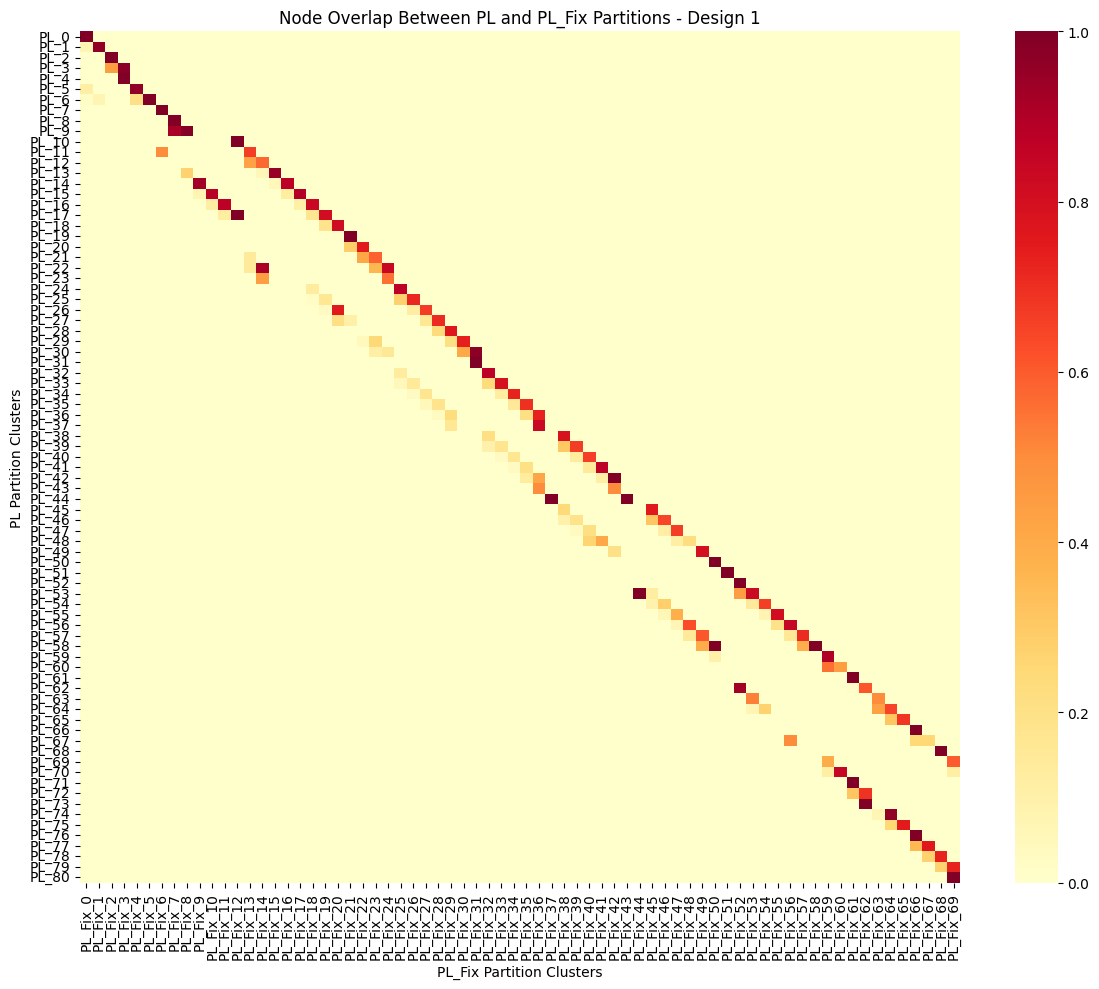


Analyzing design 2
Design 2:
  Perfectly matched nodes: 17.76%
  Average overlap ratio: 0.5023


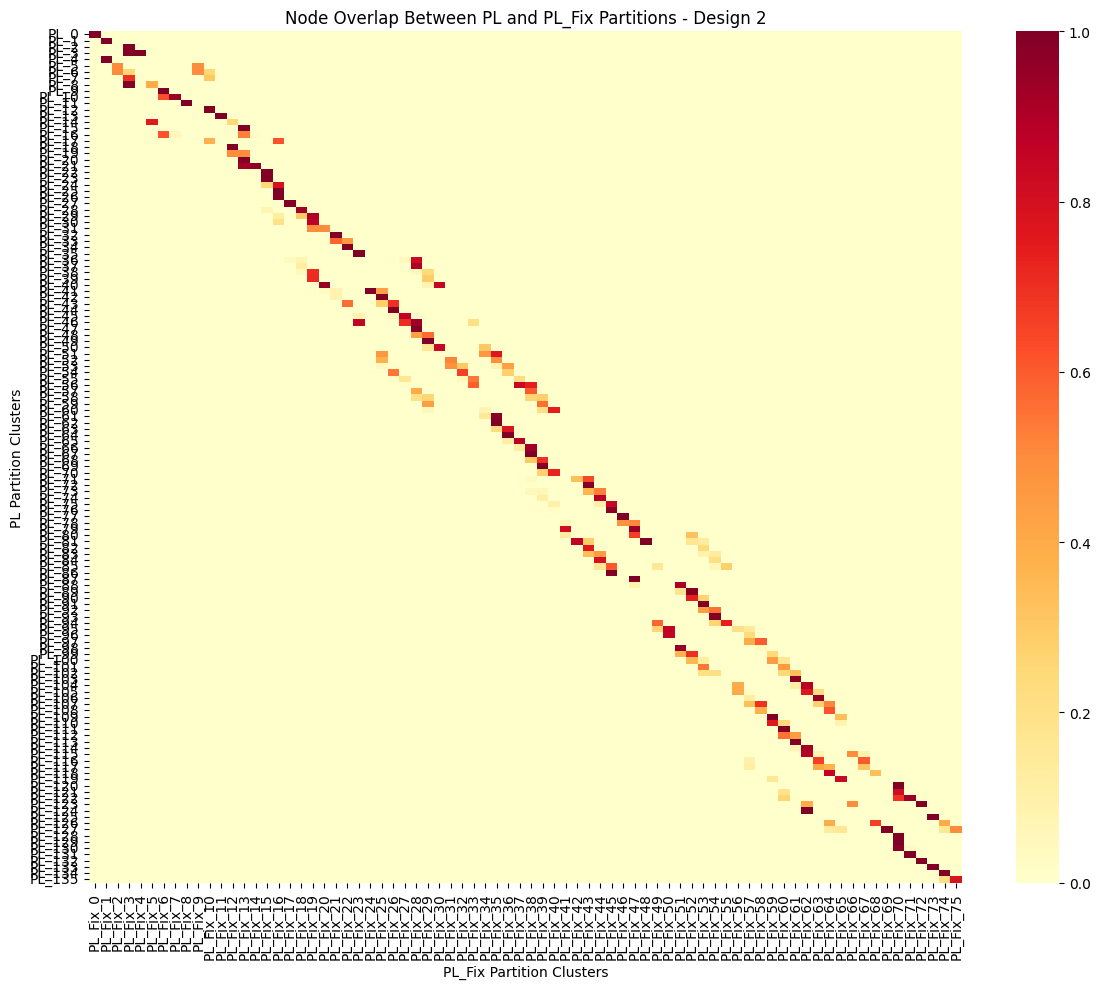


Analyzing design 3
Design 3:
  Perfectly matched nodes: 4.91%
  Average overlap ratio: 0.4965


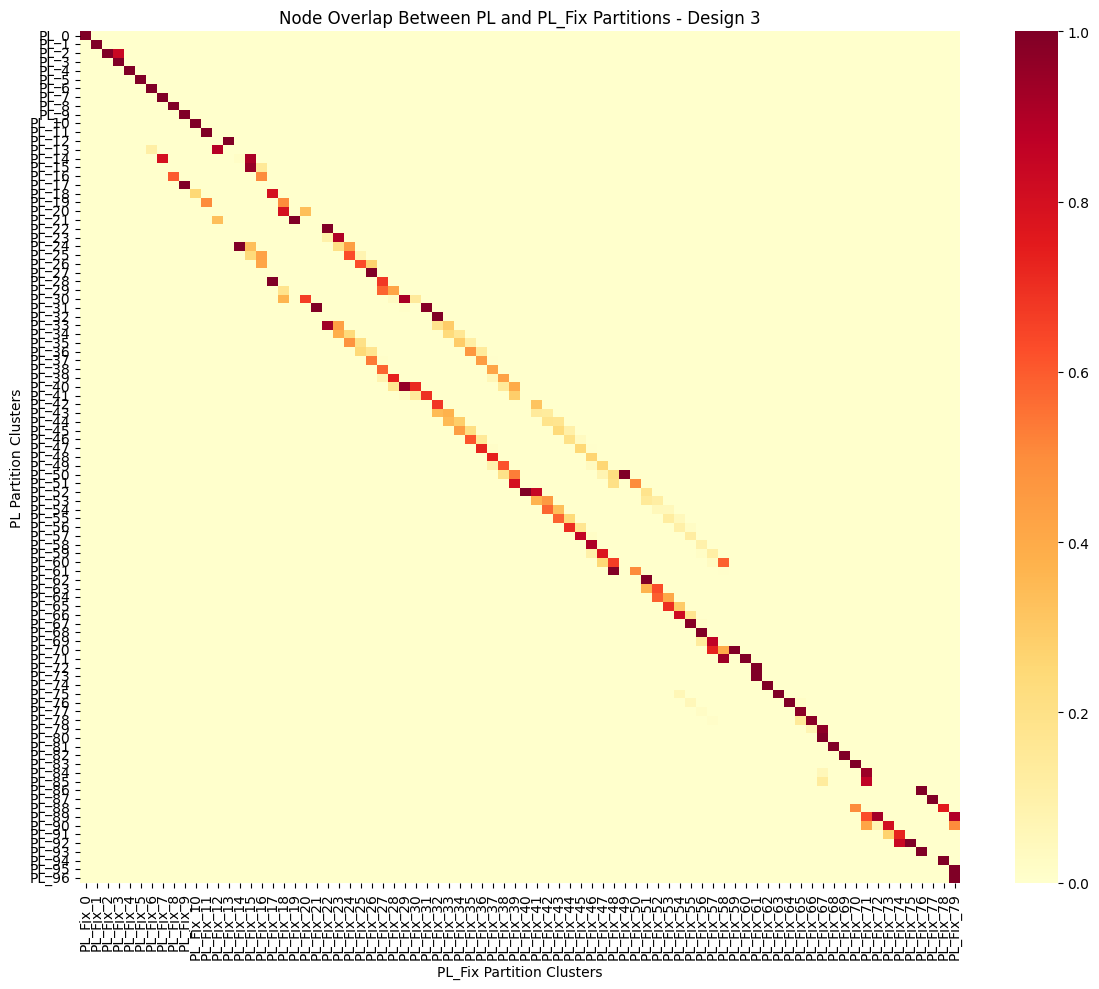


Analyzing design 5
Design 5:
  Perfectly matched nodes: 3.57%
  Average overlap ratio: 0.5215


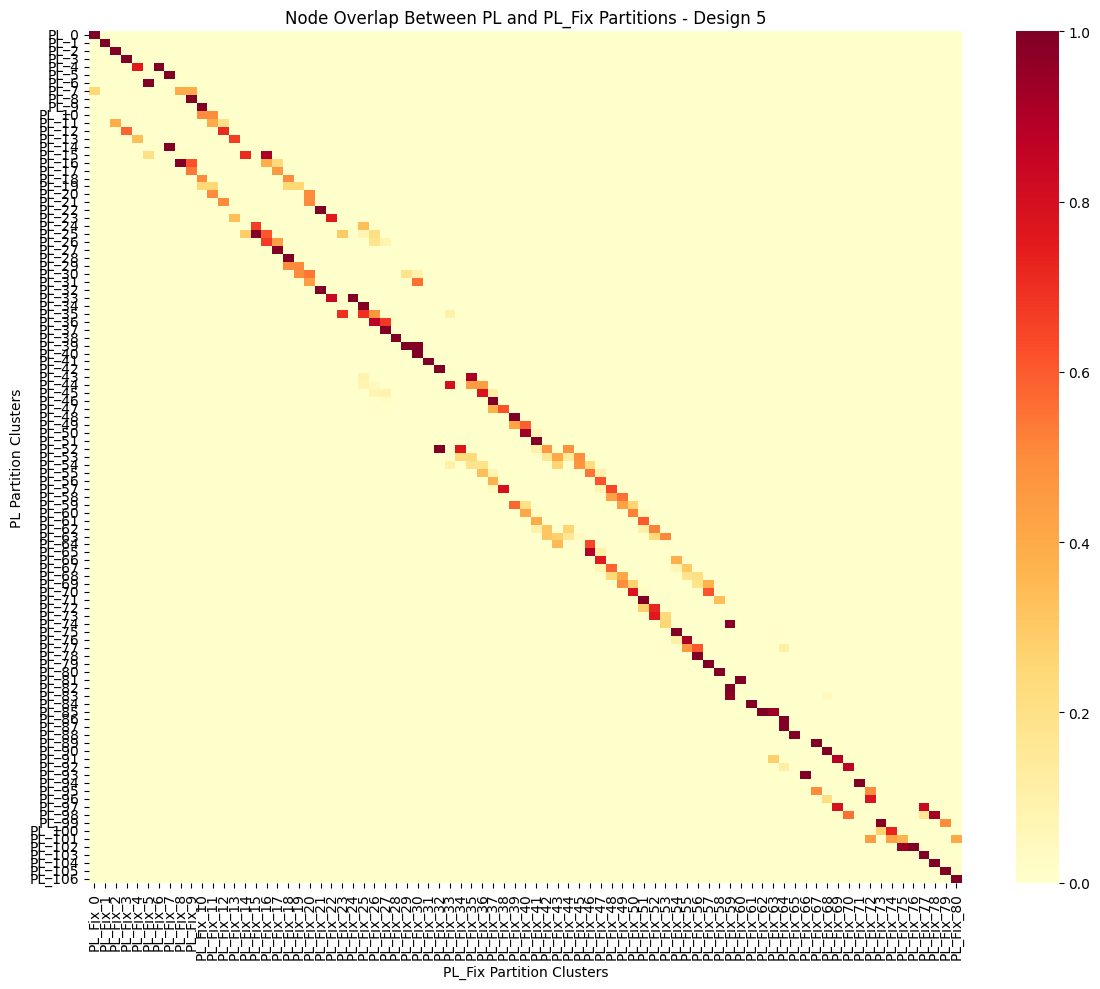


Analyzing design 6
Design 6:
  Perfectly matched nodes: 1.15%
  Average overlap ratio: 0.4605


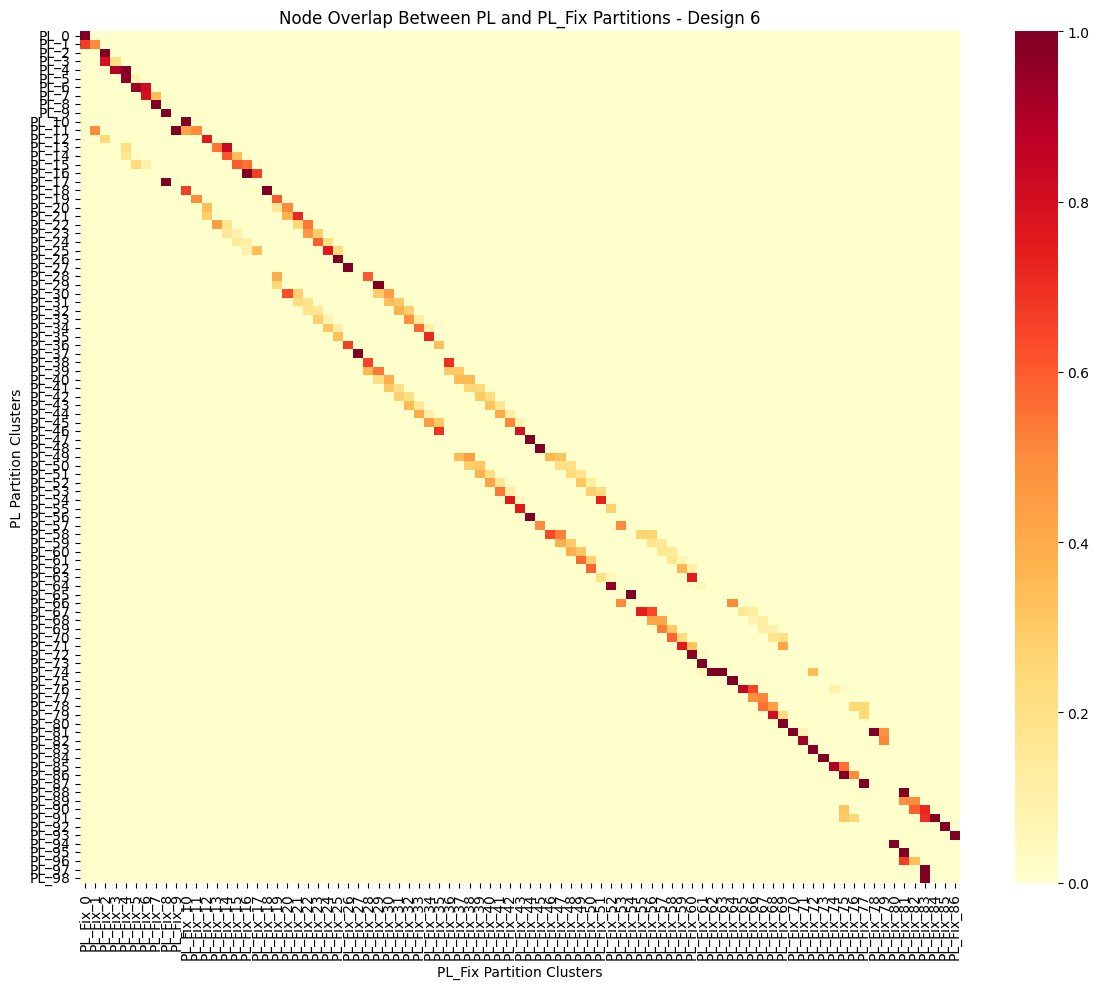


Analyzing design 7
Design 7:
  Perfectly matched nodes: 2.70%
  Average overlap ratio: 0.4324


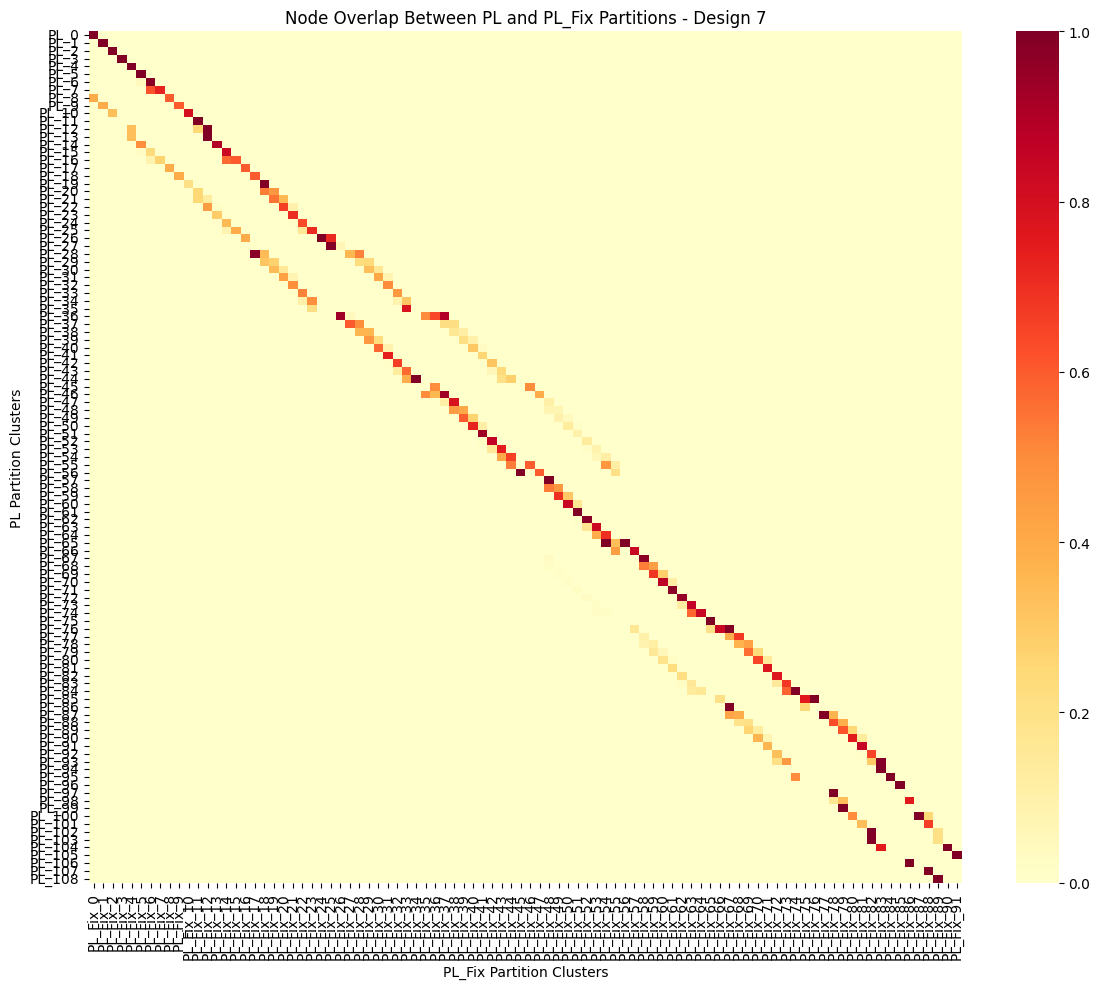


Analyzing design 9
Design 9:
  Perfectly matched nodes: 2.45%
  Average overlap ratio: 0.4300


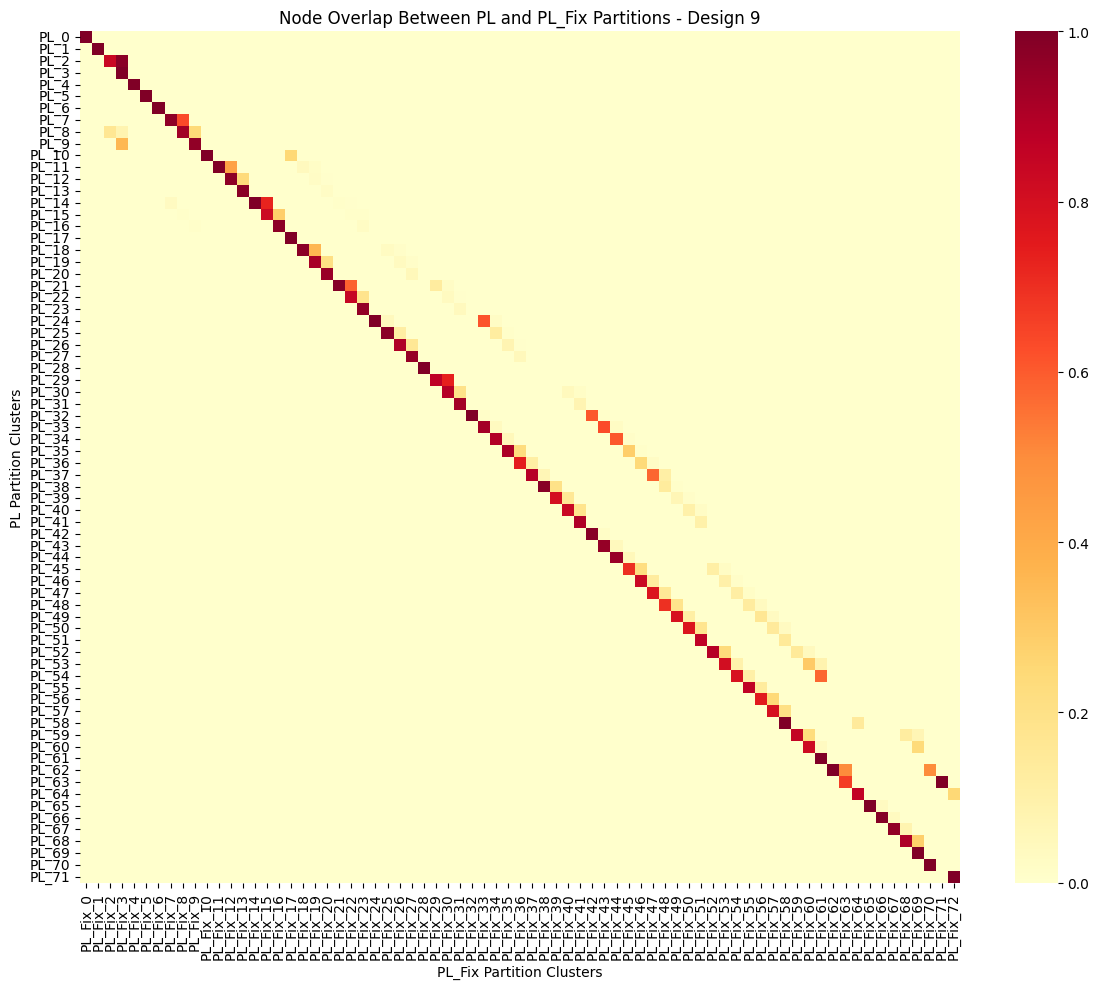


Analyzing design 11
Design 11:
  Perfectly matched nodes: 14.23%
  Average overlap ratio: 0.5181


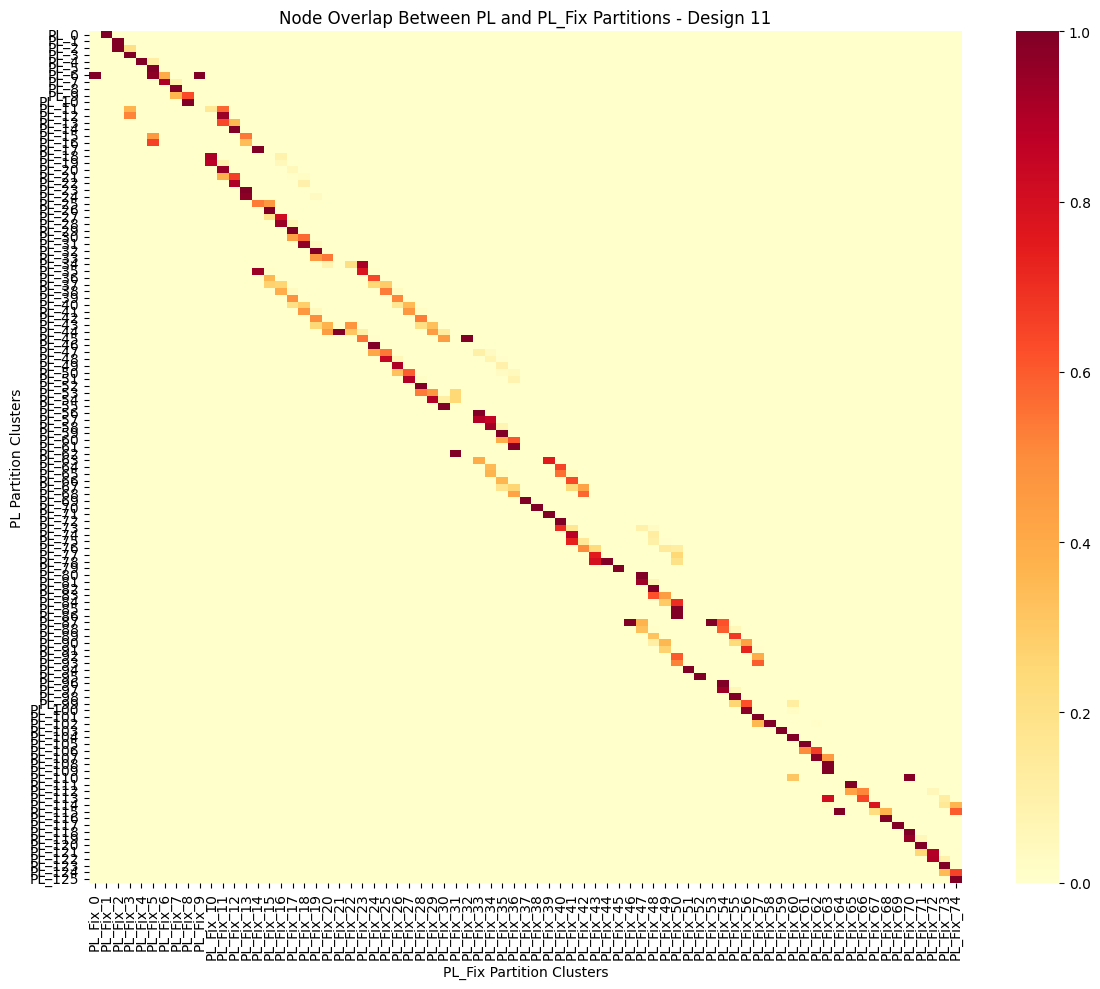


Analyzing design 14
Design 14:
  Perfectly matched nodes: 4.83%
  Average overlap ratio: 0.4951


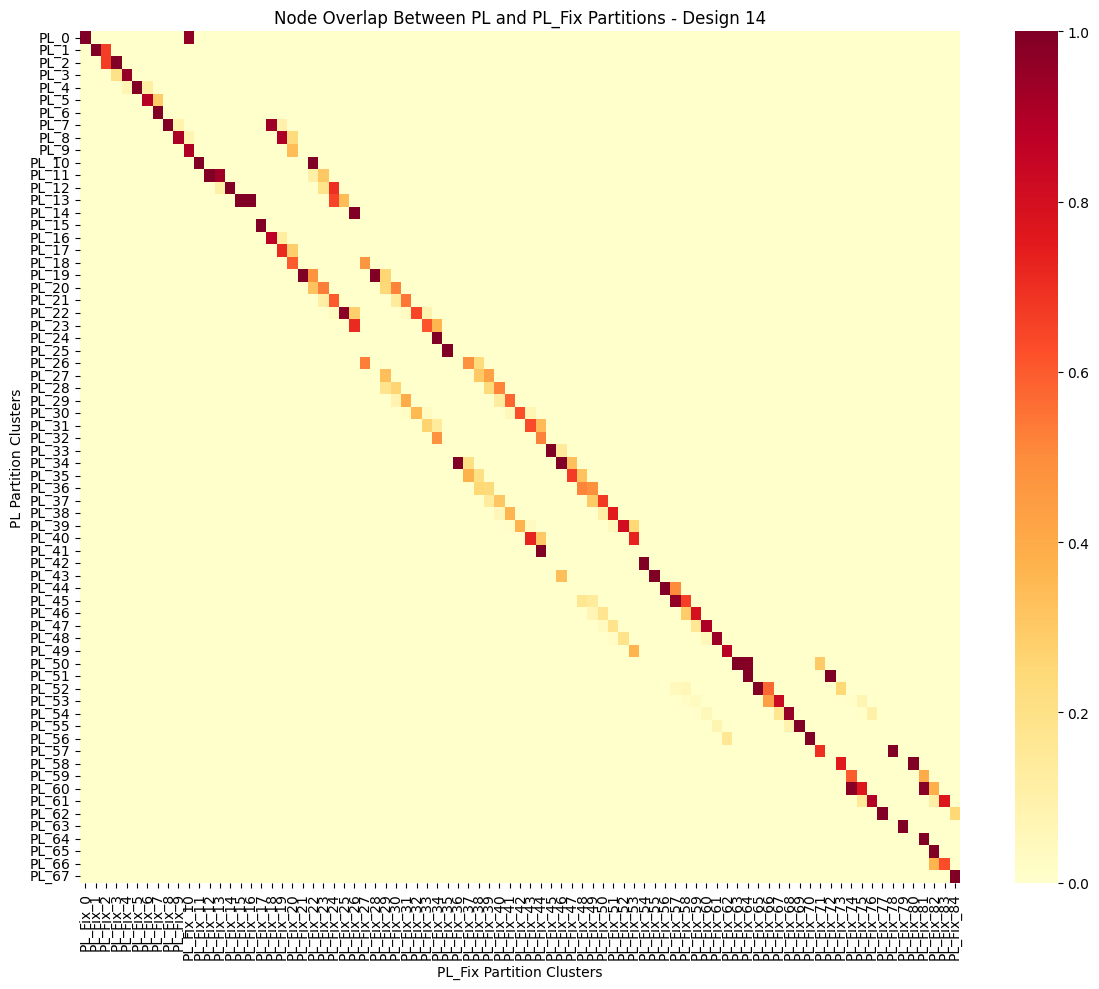


Analyzing design 16
Design 16:
  Perfectly matched nodes: 4.47%
  Average overlap ratio: 0.4442


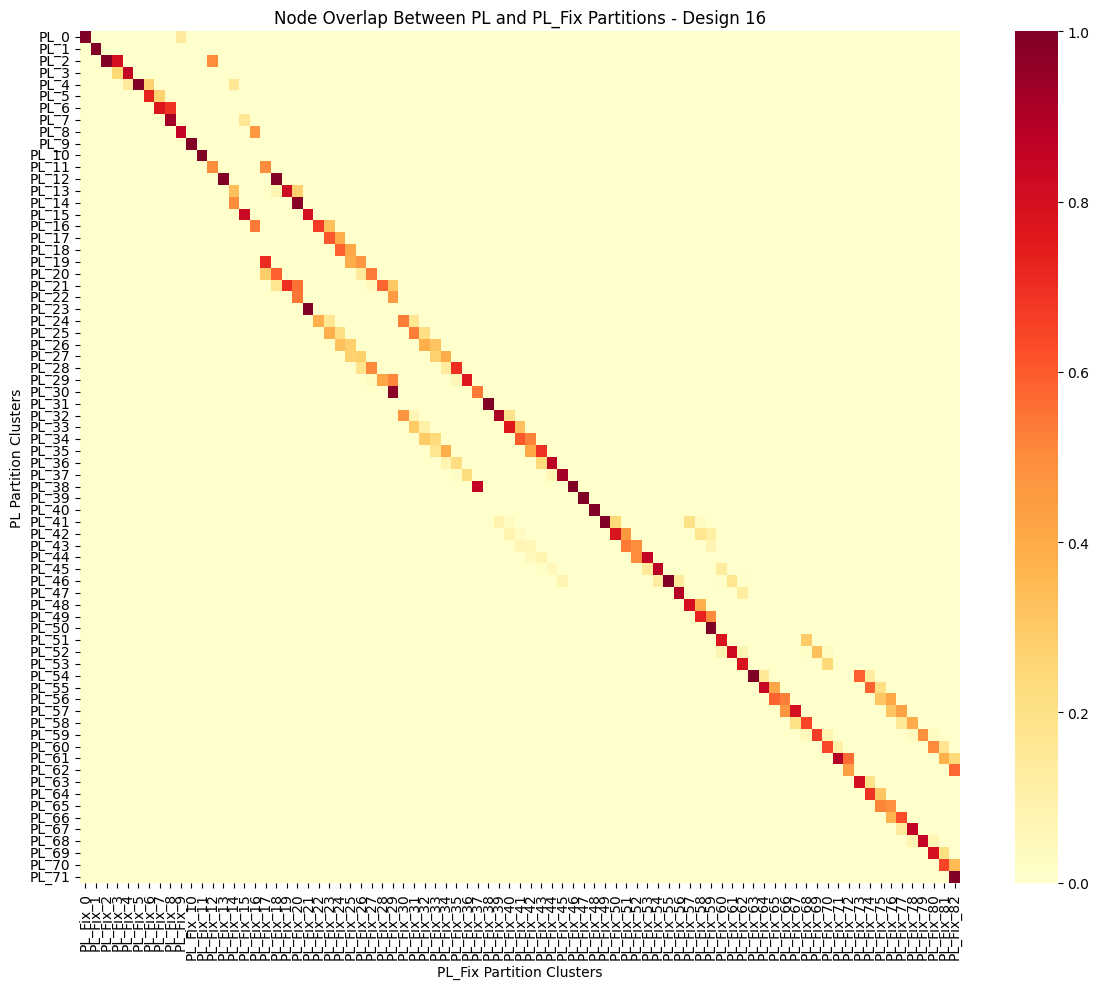

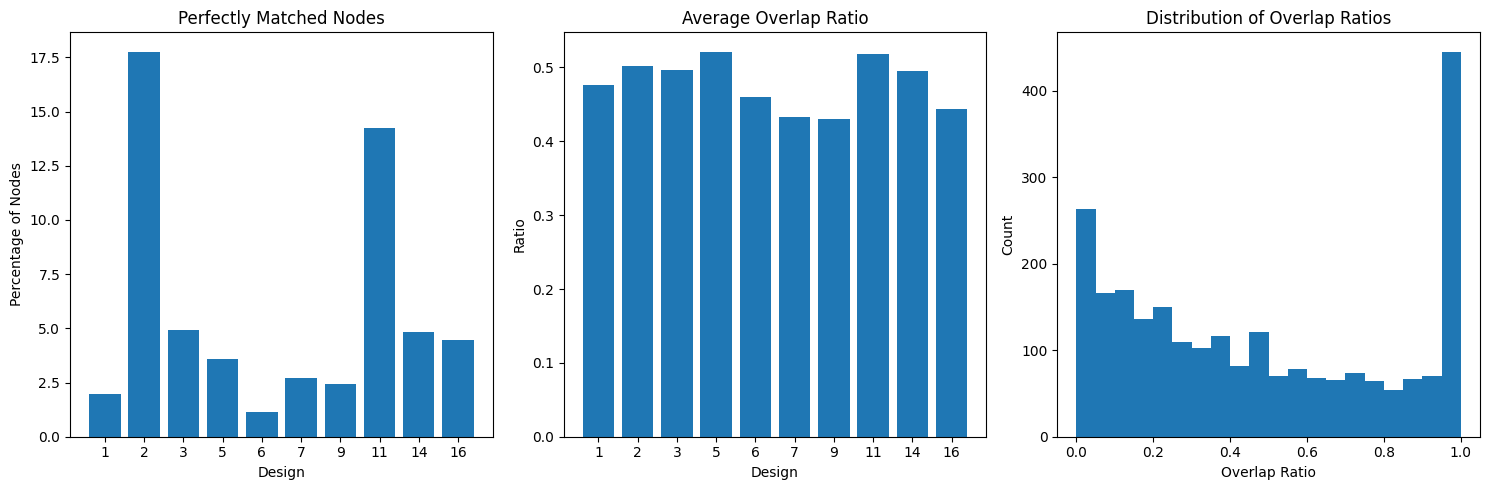


Summary Statistics:
Average perfect match percentage: 5.80% ± 5.29%
Average overlap ratio: 0.4777 ± 0.0325


In [ ]:
def analyze_pl_partition_overlap(design_list):
    """
    Analyze how nodes are shared between pl_data and pl_fix_data partitions
    """
    results = []
    
    for design in design_list:
        print(f"\nAnalyzing design {design}")
        
        # Load partitions
        pl_path = f"../../data/superblue/superblue_{design}/pl_part_dict.pkl"
        pl_fix_path = f"../../data/superblue/superblue_{design}/pl_fix_part_dict.pkl"
        
        with open(pl_path, 'rb') as f:
            pl_data = pickle.load(f)
        with open(pl_fix_path, 'rb') as f:
            pl_fix_data = pickle.load(f)
            
        # Analyze node overlap between clusters
        overlap_stats = analyze_node_sharing(pl_data, pl_fix_data)
        
        # Create confusion matrix showing node overlap
        confusion = create_overlap_matrix(pl_data, pl_fix_data)
        
        results.append({
            'design': design,
            'overlap_stats': overlap_stats,
            'confusion': confusion
        })
        
        # Print statistics
        print(f"Design {design}:")
        print(f"  Perfectly matched nodes: {overlap_stats['perfect_match_pct']:.2f}%")
        print(f"  Average overlap ratio: {overlap_stats['avg_overlap']:.4f}")
        
        # Plot confusion matrix heatmap
        plt.figure(figsize=(12, 10))
        sns.heatmap(confusion, cmap='YlOrRd', 
                   annot=None, 
                   xticklabels=True, yticklabels=True)
        plt.title(f'Node Overlap Between PL and PL_Fix Partitions - Design {design}')
        plt.xlabel('PL_Fix Partition Clusters')
        plt.ylabel('PL Partition Clusters')
        plt.tight_layout()
        plt.show()
        
    return results

def analyze_node_sharing(partition1, partition2):
    """
    Analyze how nodes are shared between two partitions
    """
    total_nodes = len(partition1)
    perfect_matches = 0
    overlap_ratios = []
    
    # Group nodes by their cluster assignments
    clusters1 = defaultdict(set)
    clusters2 = defaultdict(set)
    
    for node, cluster in partition1.items():
        clusters1[cluster].add(node)
    for node, cluster in partition2.items():
        clusters2[cluster].add(node)
    
    # Calculate overlap statistics
    for cluster1 in clusters1.values():
        for cluster2 in clusters2.values():
            overlap = len(cluster1.intersection(cluster2))
            if overlap > 0:
                overlap_ratio = overlap / min(len(cluster1), len(cluster2))
                overlap_ratios.append(overlap_ratio)
                if overlap_ratio == 1.0:
                    perfect_matches += overlap
    
    return {
        'perfect_match_pct': (perfect_matches / total_nodes) * 100,
        'avg_overlap': np.mean(overlap_ratios) if overlap_ratios else 0,
        'overlap_distribution': overlap_ratios
    }

def create_overlap_matrix(partition1, partition2):
    """
    Create matrix showing fraction of nodes shared between clusters
    """
    # Get unique cluster IDs
    clusters1 = sorted(set(partition1.values()))
    clusters2 = sorted(set(partition2.values()))
    
    # Create matrix
    matrix = np.zeros((len(clusters1), len(clusters2)))
    
    # Group nodes by cluster
    nodes_by_cluster1 = defaultdict(set)
    nodes_by_cluster2 = defaultdict(set)
    
    for node, cluster in partition1.items():
        nodes_by_cluster1[cluster].add(node)
    for node, cluster in partition2.items():
        nodes_by_cluster2[cluster].add(node)
    
    # Calculate overlap ratios
    for i, c1 in enumerate(clusters1):
        for j, c2 in enumerate(clusters2):
            overlap = len(nodes_by_cluster1[c1].intersection(nodes_by_cluster2[c2]))
            if overlap > 0:
                # Normalize by smaller cluster size
                matrix[i,j] = overlap / min(len(nodes_by_cluster1[c1]), 
                                         len(nodes_by_cluster2[c2]))
    
    return pd.DataFrame(matrix, 
                       index=[f'PL_{i}' for i in clusters1],
                       columns=[f'PL_Fix_{i}' for i in clusters2])

# Run analysis
design_list = [1, 2, 3, 5, 6, 7, 9, 11, 14, 16]
results = analyze_pl_partition_overlap(design_list)

# Create summary plots
plt.figure(figsize=(15, 5))

# Plot 1: Perfect match percentages
plt.subplot(1, 3, 1)
perfect_matches = [r['overlap_stats']['perfect_match_pct'] for r in results]
plt.bar(range(len(design_list)), perfect_matches)
plt.title('Perfectly Matched Nodes')
plt.xlabel('Design')
plt.ylabel('Percentage of Nodes')
plt.xticks(range(len(design_list)), design_list)

# Plot 2: Average overlap ratios
plt.subplot(1, 3, 2)
avg_overlaps = [r['overlap_stats']['avg_overlap'] for r in results]
plt.bar(range(len(design_list)), avg_overlaps)
plt.title('Average Overlap Ratio')
plt.xlabel('Design')
plt.ylabel('Ratio')
plt.xticks(range(len(design_list)), design_list)

# Plot 3: Distribution of overlap ratios
plt.subplot(1, 3, 3)
all_overlaps = []
for r in results:
    all_overlaps.extend(r['overlap_stats']['overlap_distribution'])
plt.hist(all_overlaps, bins=20)
plt.title('Distribution of Overlap Ratios')
plt.xlabel('Overlap Ratio')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"Average perfect match percentage: {np.mean(perfect_matches):.2f}% ± {np.std(perfect_matches):.2f}%")
print(f"Average overlap ratio: {np.mean(avg_overlaps):.4f} ± {np.std(avg_overlaps):.4f}")


Analyzing design 1
Design 1:
  Perfectly matched nodes: 0.12%
  Average overlap ratio: 0.6723


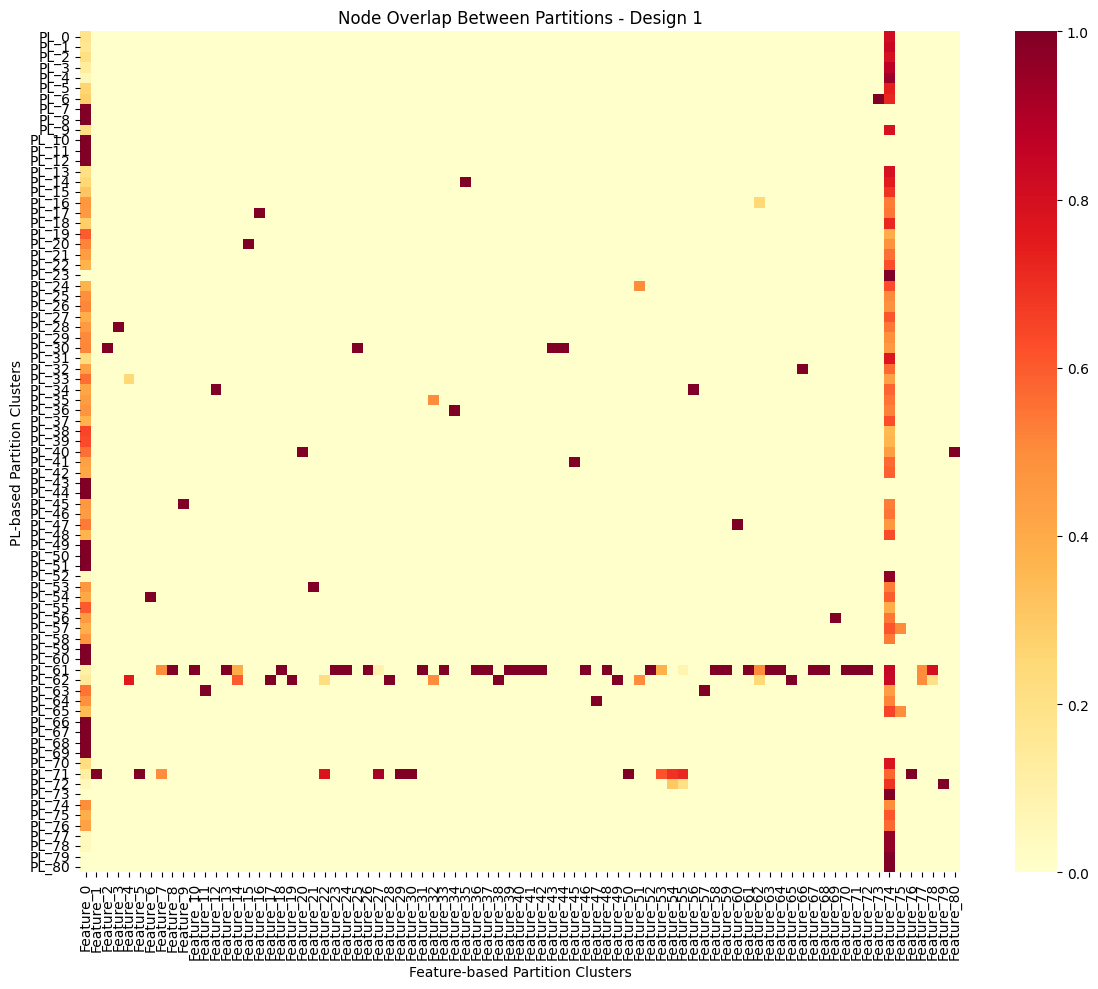


Analyzing design 2
Design 2:
  Perfectly matched nodes: 0.06%
  Average overlap ratio: 0.5726


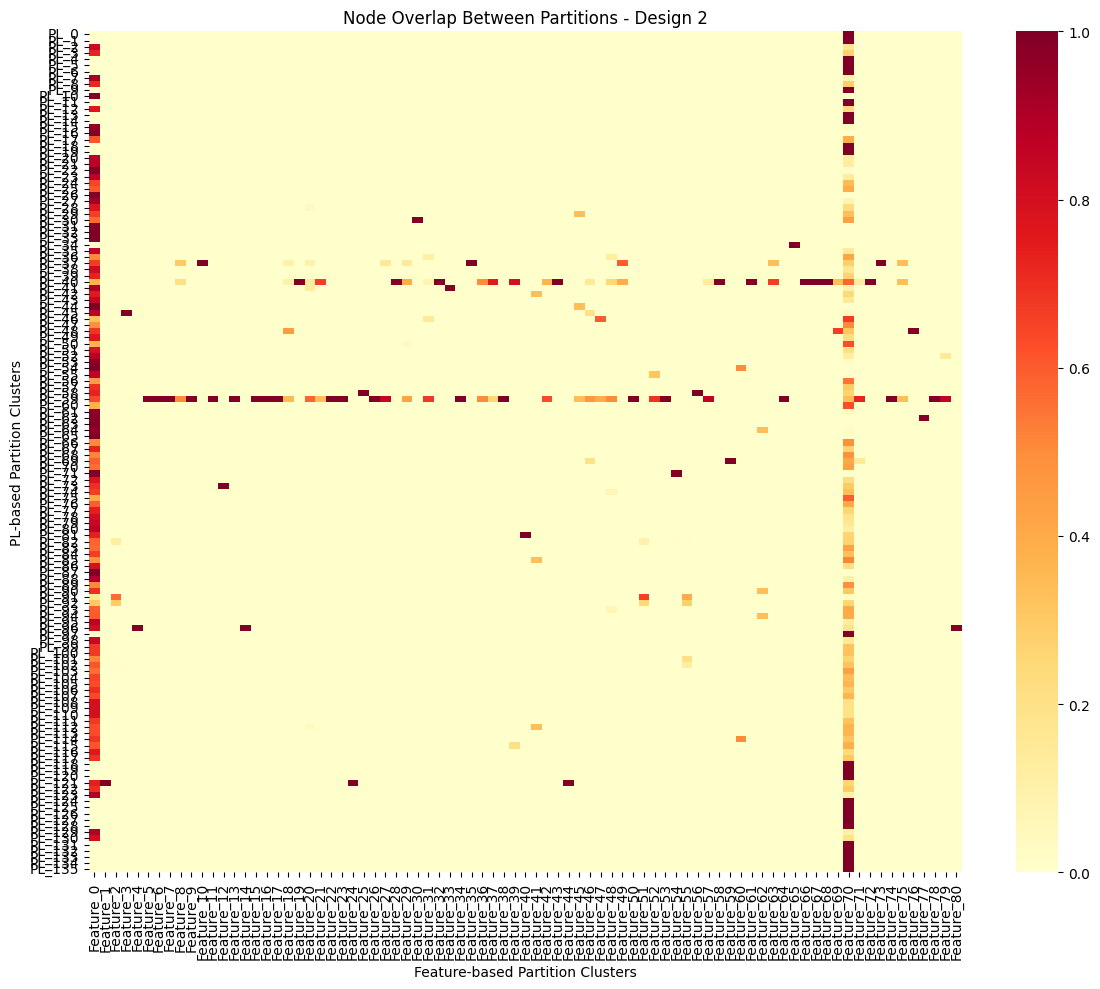


Analyzing design 3
Design 3:
  Perfectly matched nodes: 4.08%
  Average overlap ratio: 0.6219


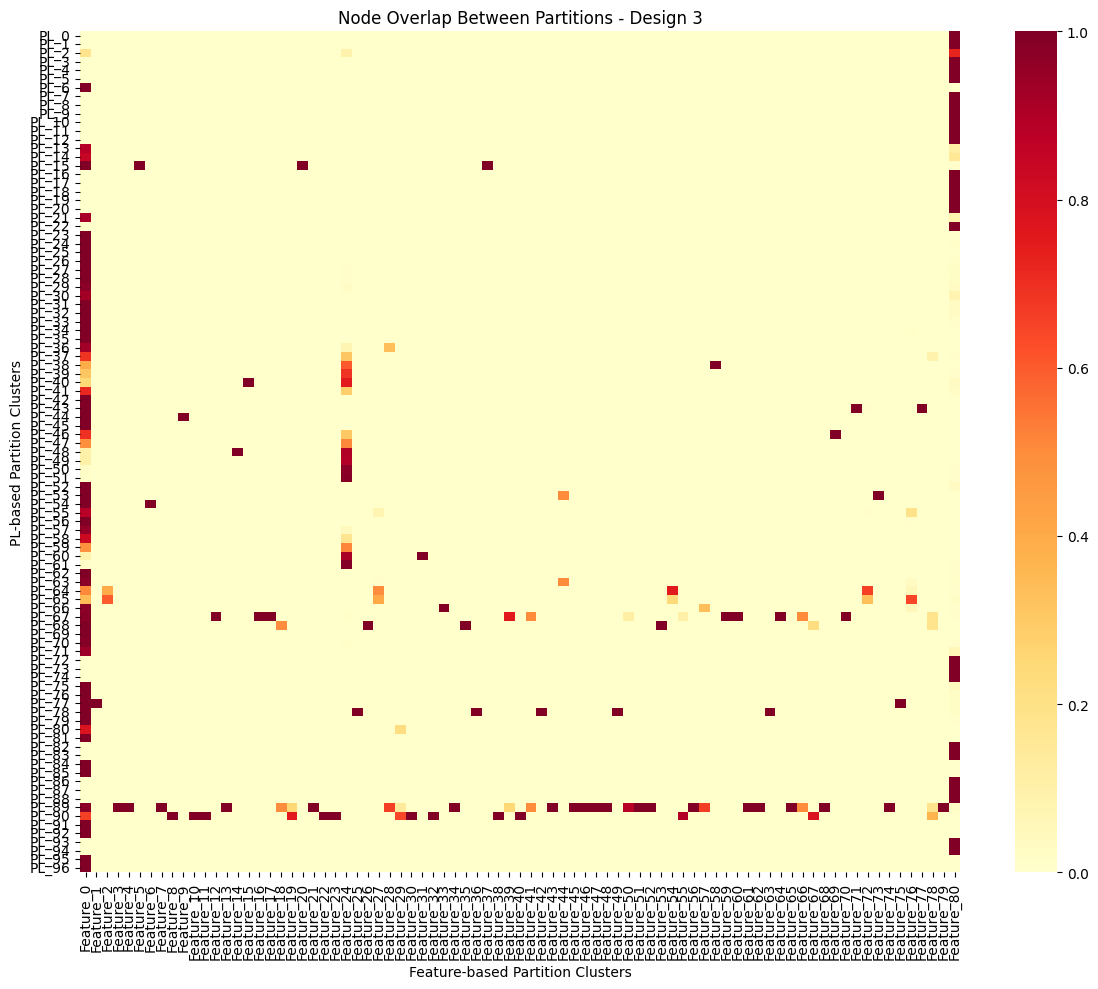


Analyzing design 5
Design 5:
  Perfectly matched nodes: 0.06%
  Average overlap ratio: 0.5976


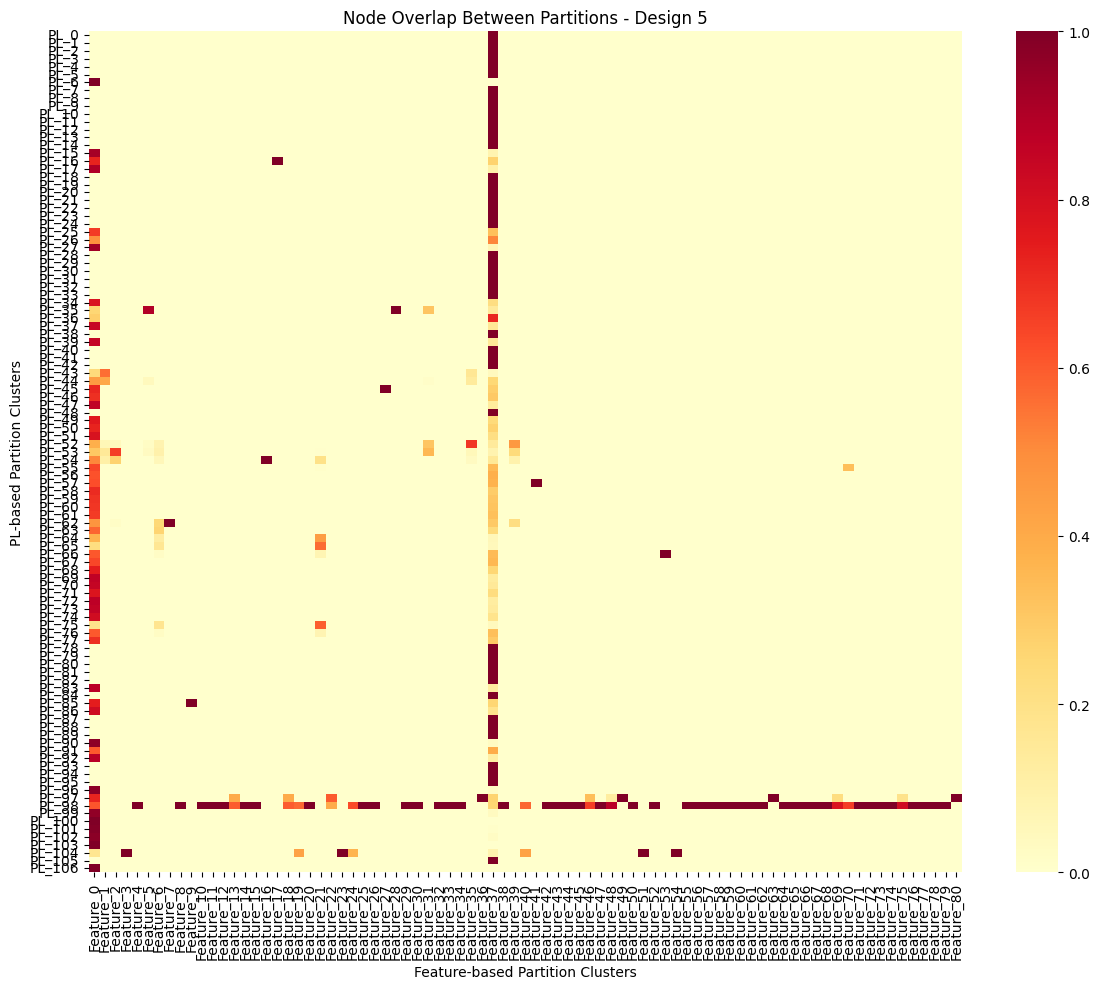


Analyzing design 6
Design 6:
  Perfectly matched nodes: 0.07%
  Average overlap ratio: 0.5811


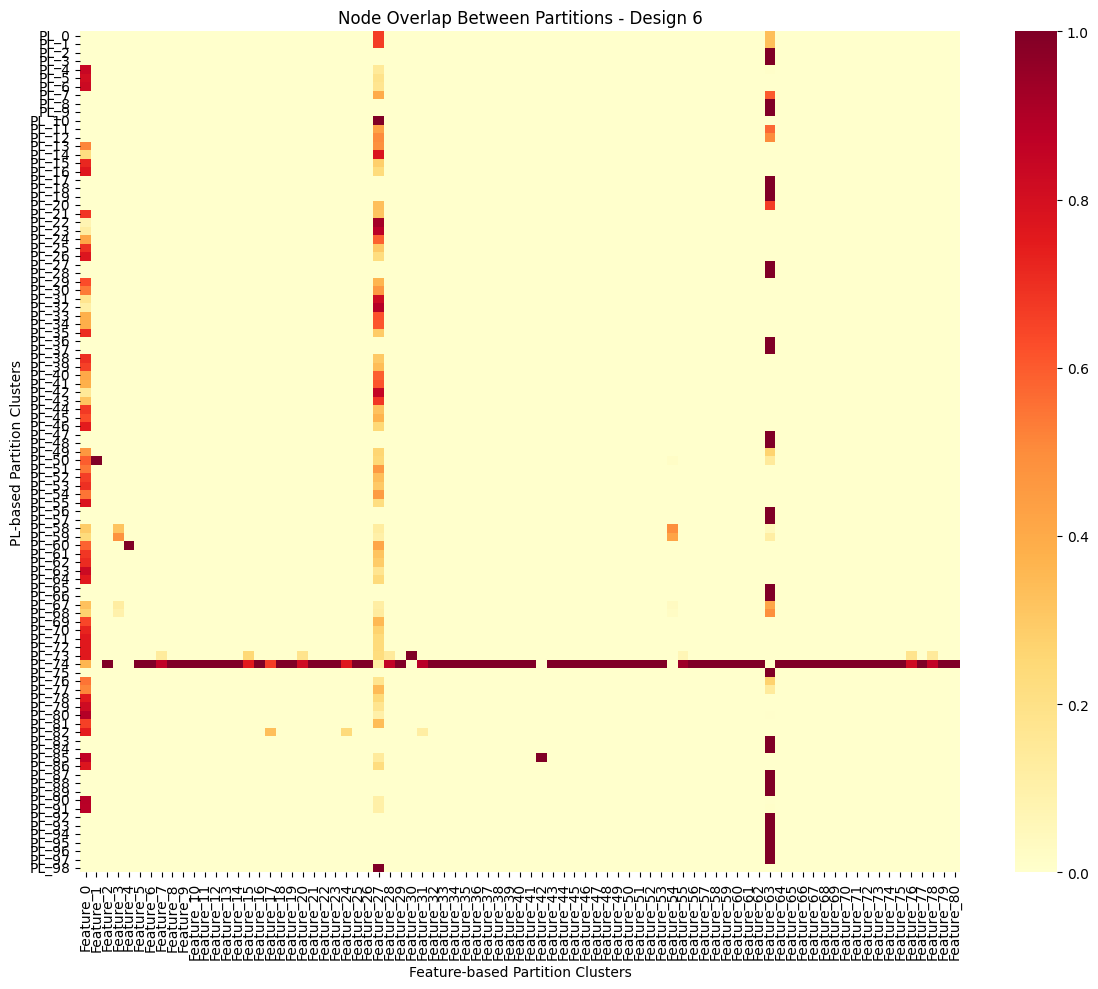


Analyzing design 7
Design 7:
  Perfectly matched nodes: 0.20%
  Average overlap ratio: 0.6367


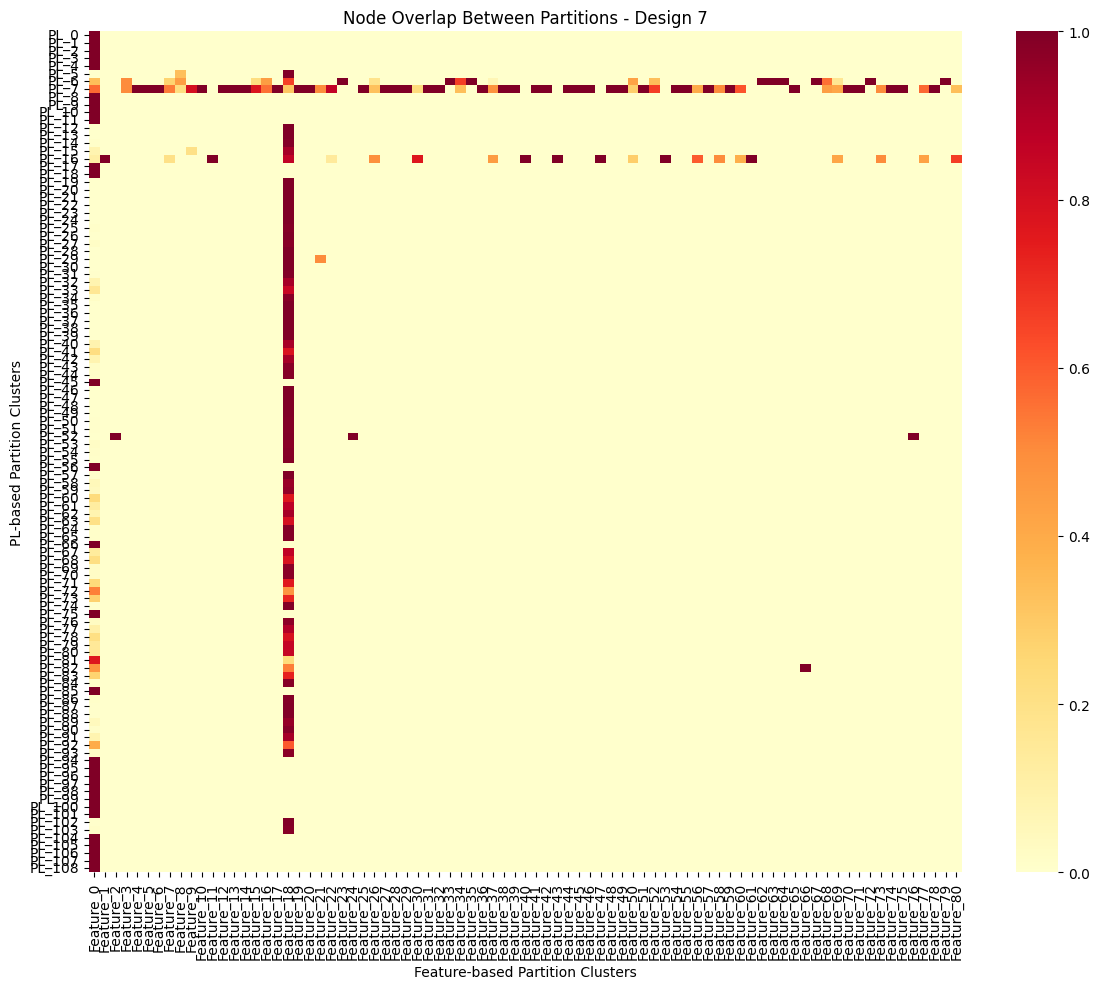


Analyzing design 9
Design 9:
  Perfectly matched nodes: 0.01%
  Average overlap ratio: 0.2452


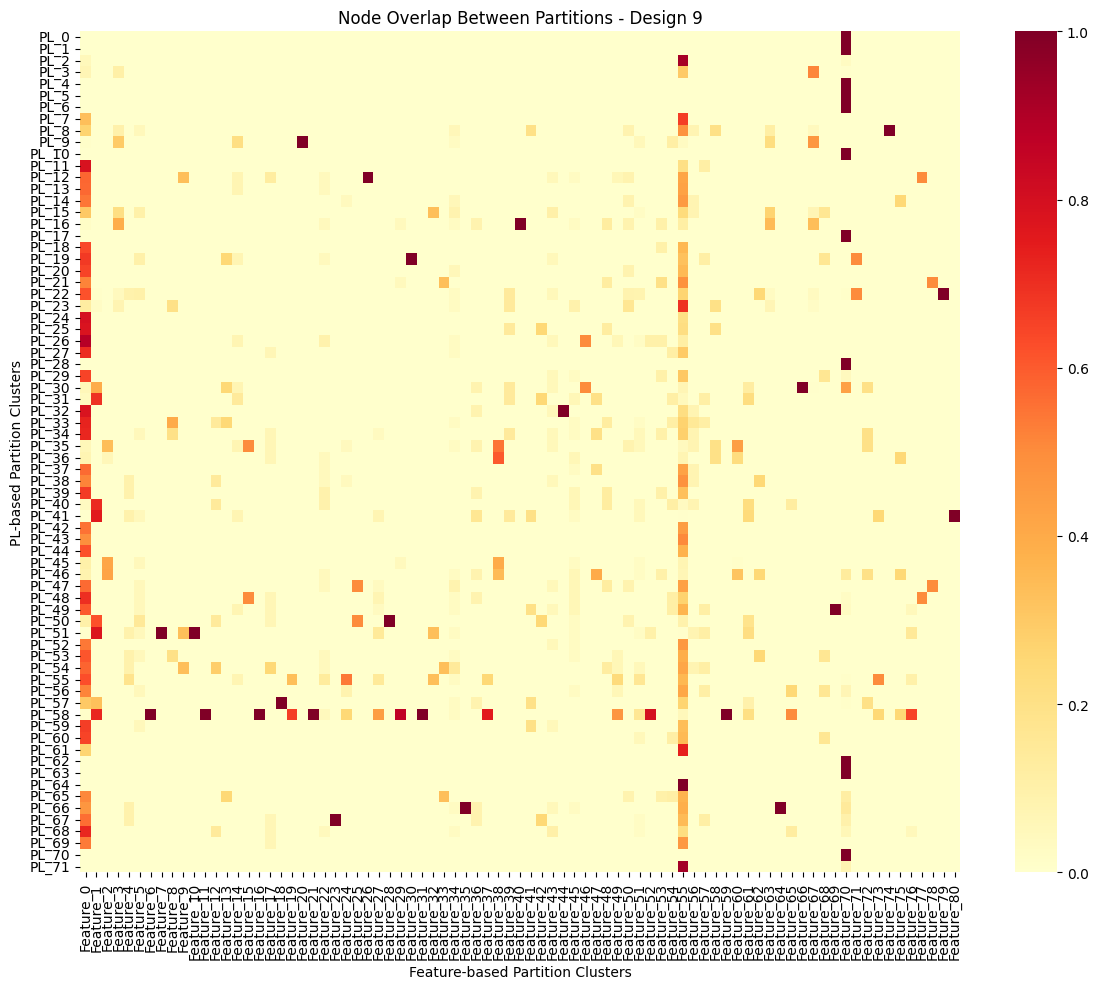


Analyzing design 11
Design 11:
  Perfectly matched nodes: 0.17%
  Average overlap ratio: 0.5735


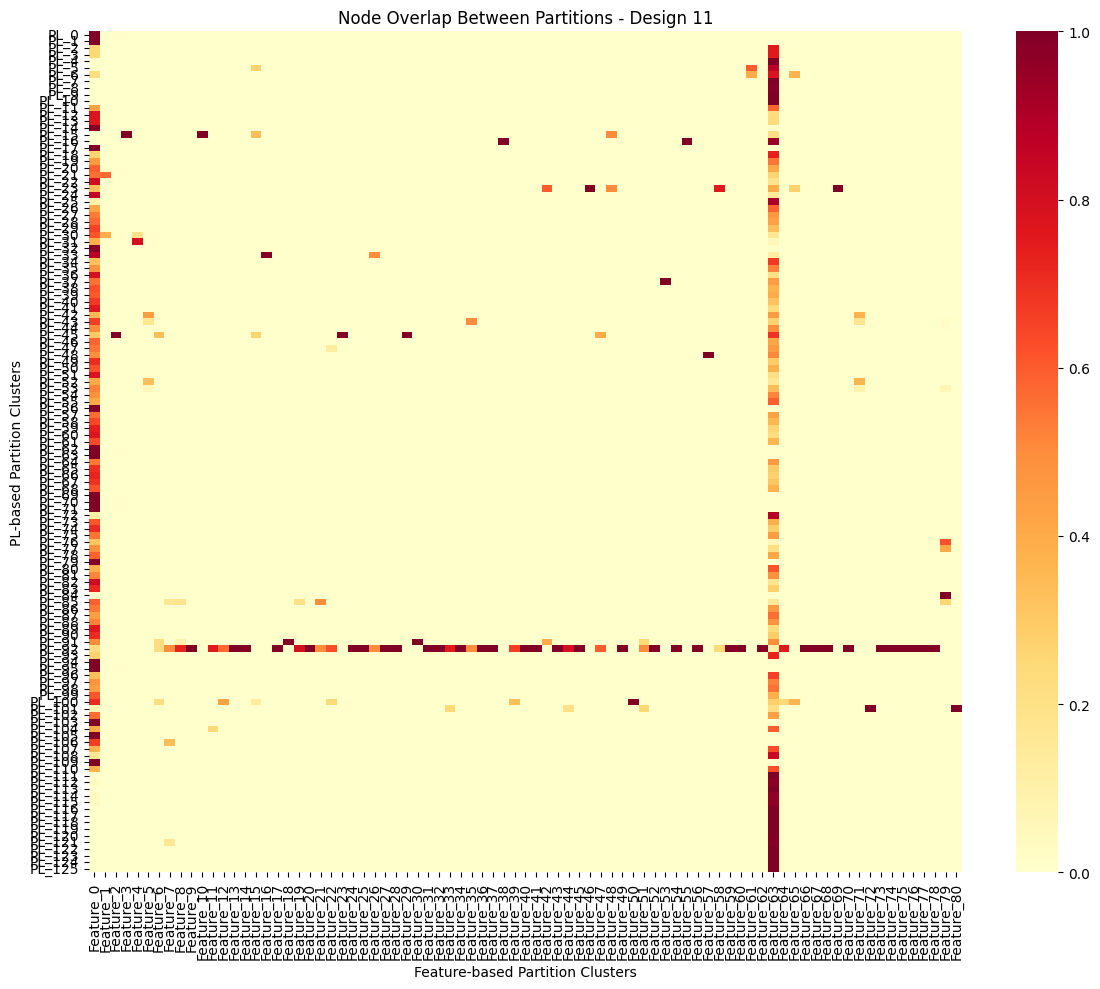


Analyzing design 14
Design 14:
  Perfectly matched nodes: 0.04%
  Average overlap ratio: 0.5075


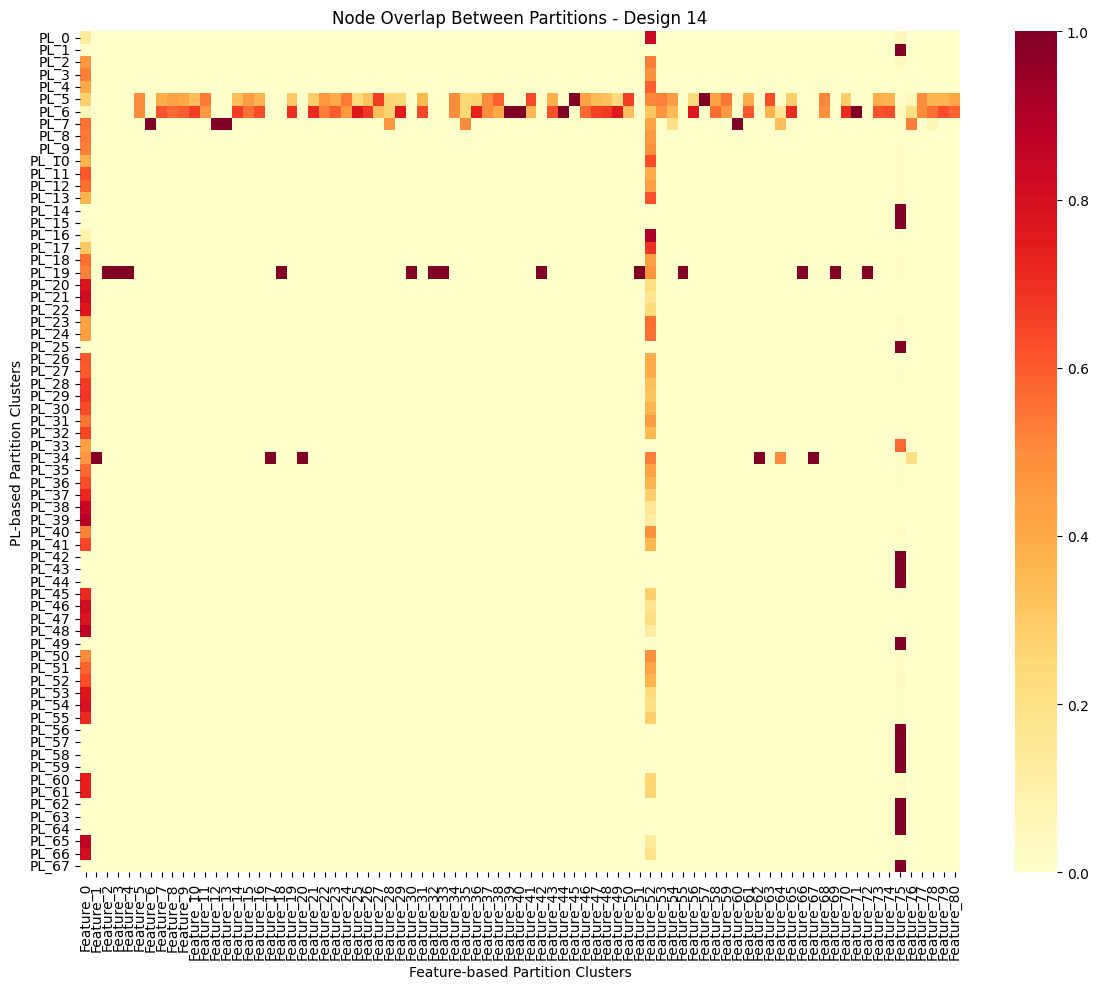


Analyzing design 16
Design 16:
  Perfectly matched nodes: 0.04%
  Average overlap ratio: 0.4797


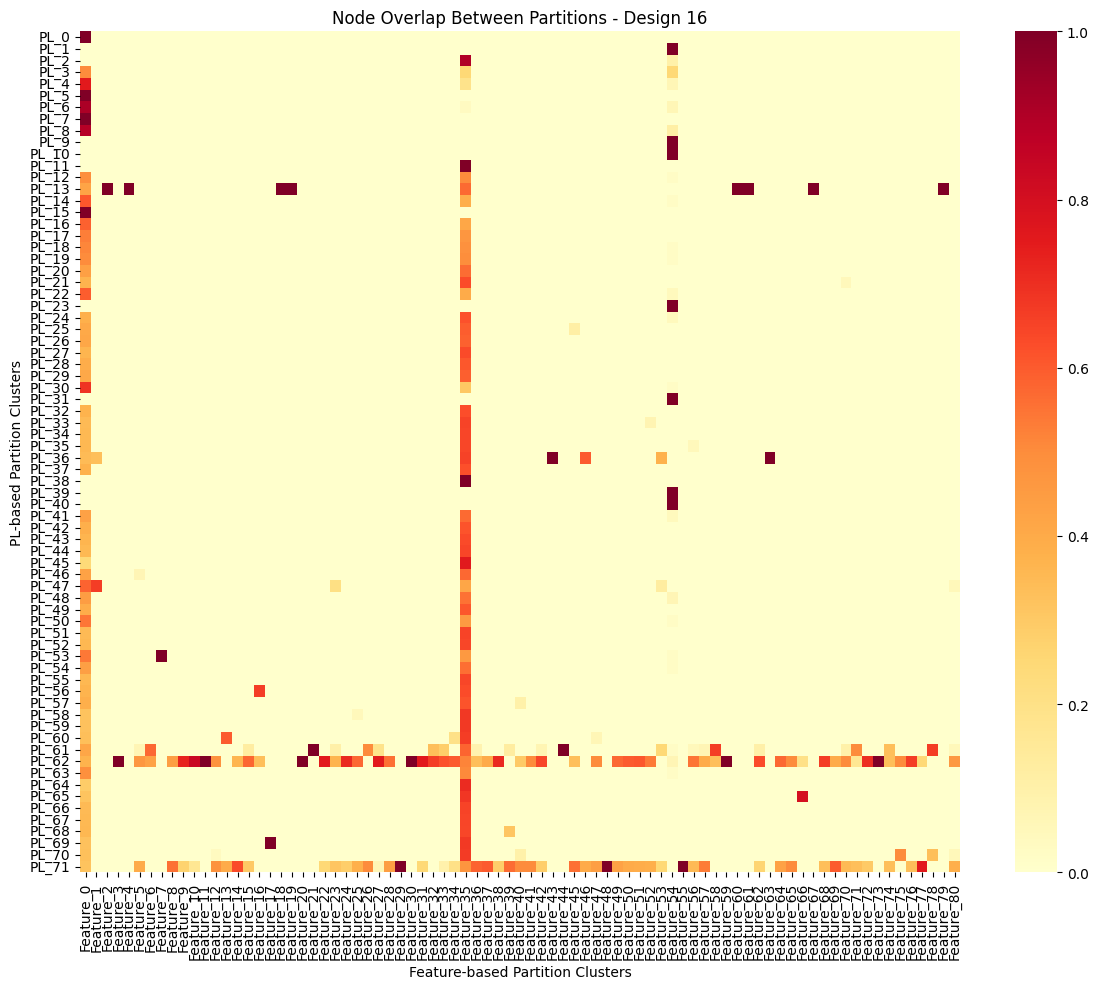

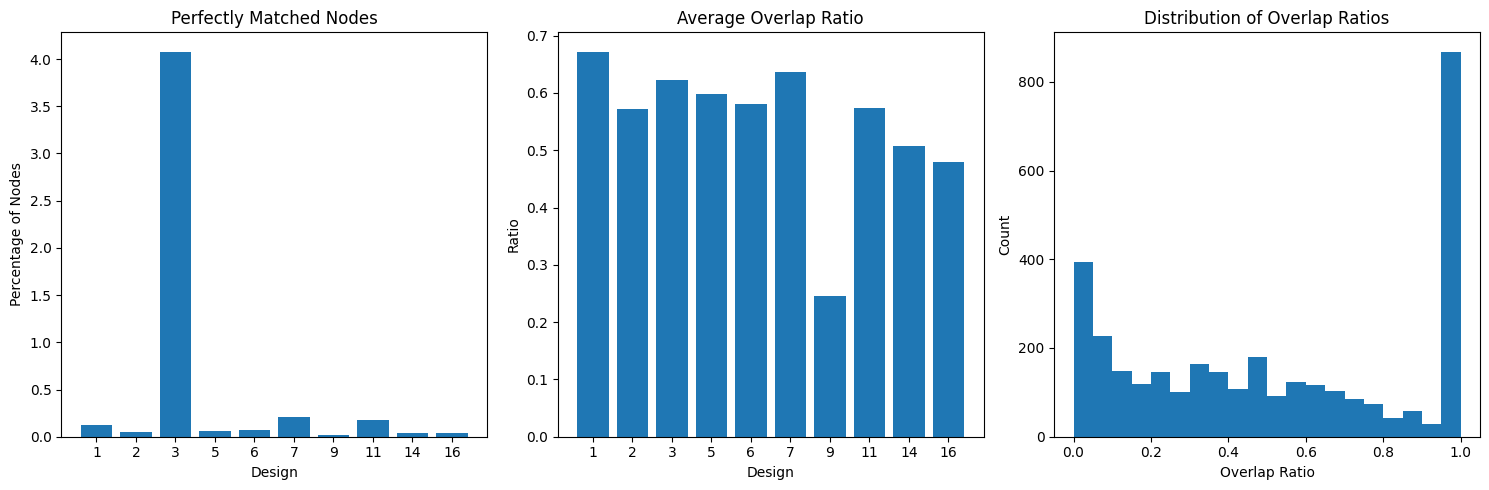


Summary Statistics:
Average perfect match percentage: 0.49% ± 1.20%
Average overlap ratio: 0.5488 ± 0.1147


In [ ]:
def analyze_partition_overlap(design_list):
    """
    Analyze how nodes are shared between partitions
    """
    results = []
    
    for design in design_list:
        print(f"\nAnalyzing design {design}")
        
        # Load partitions
        pl_path = f"../../data/superblue/superblue_{design}/pl_part_dict.pkl"
        feature_path = f"../../data/superblue/superblue_{design}/feature_approx_physical_part_dict.pkl"
        
        with open(pl_path, 'rb') as f:
            pl_data = pickle.load(f)
        with open(feature_path, 'rb') as f:
            feature_data = pickle.load(f)
            
        # Analyze node overlap between clusters
        overlap_stats = analyze_node_sharing(pl_data, feature_data)
        
        # Create confusion matrix showing node overlap
        confusion = create_overlap_matrix(pl_data, feature_data)
        
        results.append({
            'design': design,
            'overlap_stats': overlap_stats,
            'confusion': confusion
        })
        
        # Print statistics
        print(f"Design {design}:")
        print(f"  Perfectly matched nodes: {overlap_stats['perfect_match_pct']:.2f}%")
        print(f"  Average overlap ratio: {overlap_stats['avg_overlap']:.4f}")
        
        # Plot confusion matrix heatmap
        plt.figure(figsize=(12, 10))
        sns.heatmap(confusion, cmap='YlOrRd', 
                   annot=None,
                   xticklabels=True, yticklabels=True)
        plt.title(f'Node Overlap Between Partitions - Design {design}')
        plt.xlabel('Feature-based Partition Clusters')
        plt.ylabel('PL-based Partition Clusters')
        plt.tight_layout()
        plt.show()
        
    return results

def analyze_node_sharing(partition1, partition2):
    """
    Analyze how nodes are shared between two partitions
    """
    total_nodes = len(partition1)
    perfect_matches = 0
    overlap_ratios = []
    
    # Group nodes by their cluster assignments
    clusters1 = defaultdict(set)
    clusters2 = defaultdict(set)
    
    for node, cluster in partition1.items():
        clusters1[cluster].add(node)
    for node, cluster in partition2.items():
        clusters2[cluster].add(node)
    
    # Calculate overlap statistics
    for cluster1 in clusters1.values():
        for cluster2 in clusters2.values():
            overlap = len(cluster1.intersection(cluster2))
            if overlap > 0:
                overlap_ratio = overlap / min(len(cluster1), len(cluster2))
                overlap_ratios.append(overlap_ratio)
                if overlap_ratio == 1.0:
                    perfect_matches += overlap
    
    return {
        'perfect_match_pct': (perfect_matches / total_nodes) * 100,
        'avg_overlap': np.mean(overlap_ratios) if overlap_ratios else 0,
        'overlap_distribution': overlap_ratios
    }

def create_overlap_matrix(partition1, partition2):
    """
    Create matrix showing fraction of nodes shared between clusters
    """
    # Get unique cluster IDs
    clusters1 = sorted(set(partition1.values()))
    clusters2 = sorted(set(partition2.values()))
    
    # Create matrix
    matrix = np.zeros((len(clusters1), len(clusters2)))
    
    # Group nodes by cluster
    nodes_by_cluster1 = defaultdict(set)
    nodes_by_cluster2 = defaultdict(set)
    
    for node, cluster in partition1.items():
        nodes_by_cluster1[cluster].add(node)
    for node, cluster in partition2.items():
        nodes_by_cluster2[cluster].add(node)
    
    # Calculate overlap ratios
    for i, c1 in enumerate(clusters1):
        for j, c2 in enumerate(clusters2):
            overlap = len(nodes_by_cluster1[c1].intersection(nodes_by_cluster2[c2]))
            if overlap > 0:
                # Normalize by smaller cluster size
                matrix[i,j] = overlap / min(len(nodes_by_cluster1[c1]), 
                                         len(nodes_by_cluster2[c2]))
    
    return pd.DataFrame(matrix, 
                       index=[f'PL_{i}' for i in clusters1],
                       columns=[f'Feature_{i}' for i in clusters2])

# Run analysis
design_list = [1, 2, 3, 5, 6, 7, 9, 11, 14, 16]
results = analyze_partition_overlap(design_list)

# Create summary plots
plt.figure(figsize=(15, 5))

# Plot 1: Perfect match percentages
plt.subplot(1, 3, 1)
perfect_matches = [r['overlap_stats']['perfect_match_pct'] for r in results]
plt.bar(range(len(design_list)), perfect_matches)
plt.title('Perfectly Matched Nodes')
plt.xlabel('Design')
plt.ylabel('Percentage of Nodes')
plt.xticks(range(len(design_list)), design_list)

# Plot 2: Average overlap ratios
plt.subplot(1, 3, 2)
avg_overlaps = [r['overlap_stats']['avg_overlap'] for r in results]
plt.bar(range(len(design_list)), avg_overlaps)
plt.title('Average Overlap Ratio')
plt.xlabel('Design')
plt.ylabel('Ratio')
plt.xticks(range(len(design_list)), design_list)

# Plot 3: Distribution of overlap ratios
plt.subplot(1, 3, 3)
all_overlaps = []
for r in results:
    all_overlaps.extend(r['overlap_stats']['overlap_distribution'])
plt.hist(all_overlaps, bins=20)
plt.title('Distribution of Overlap Ratios')
plt.xlabel('Overlap Ratio')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"Average perfect match percentage: {np.mean(perfect_matches):.2f}% ± {np.std(perfect_matches):.2f}%")
print(f"Average overlap ratio: {np.mean(avg_overlaps):.4f} ± {np.std(avg_overlaps):.4f}")

### Partition Sizes


Analyzing design 1
Design 1 (Total nodes: 1,619,461)
  METIS   - Nodes per partition: 16358.2 ± 2055.9
           Number of partitions: 99
  PL      - Nodes per partition: 9851.1 ± 11743.9
           Number of partitions: 81
  PL Fix  - Nodes per partition: 11399.1 ± 12066.6
           Number of partitions: 70
  Feature - Nodes per partition: 9851.1 ± 22280.7
           Number of partitions: 81
  Balanced Feature - Nodes per partition: 9851.1 ± 5152.9
           Number of partitions: 81


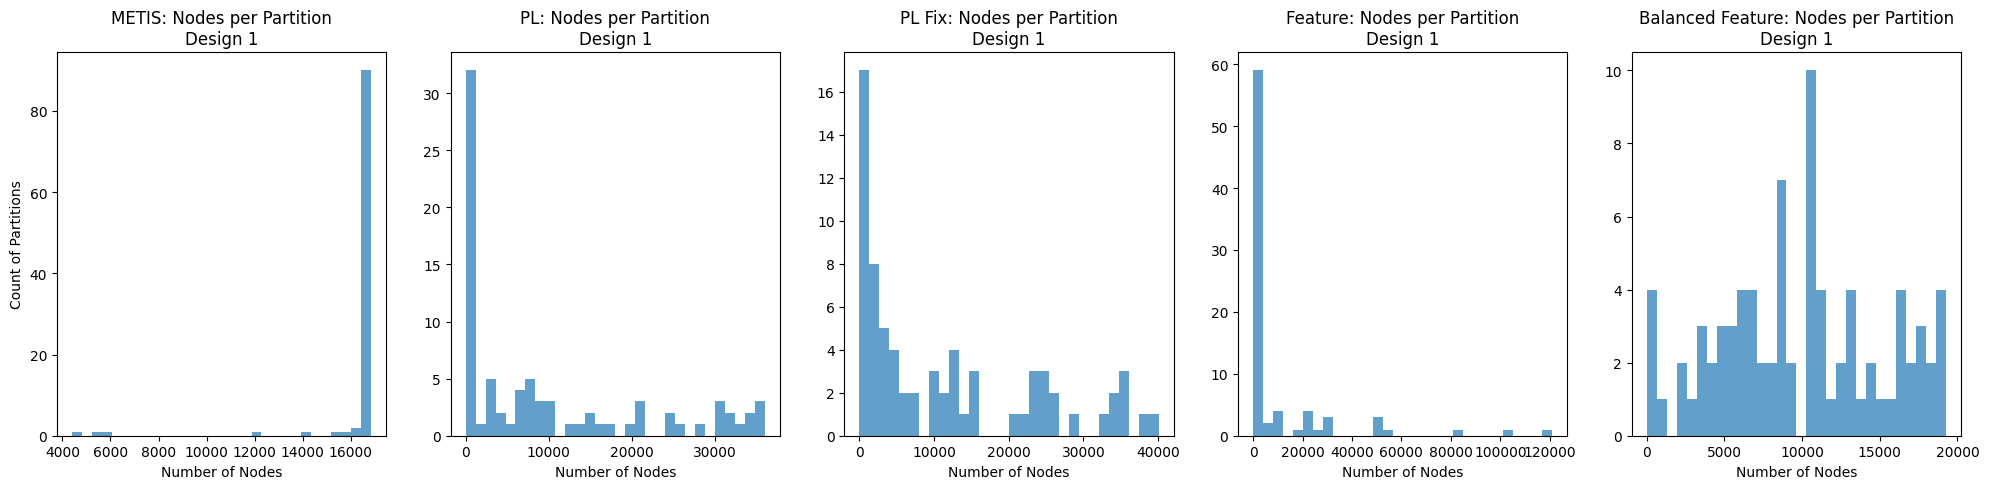


Analyzing design 2
Design 2 (Total nodes: 1,936,283)
  METIS   - Nodes per partition: 16409.2 ± 1608.9
           Number of partitions: 118
  PL      - Nodes per partition: 6993.9 ± 9724.1
           Number of partitions: 136
  PL Fix  - Nodes per partition: 12515.3 ± 22183.9
           Number of partitions: 76
  Feature - Nodes per partition: 11742.8 ± 27230.7
           Number of partitions: 81
  Balanced Feature - Nodes per partition: 11742.8 ± 5662.7
           Number of partitions: 81


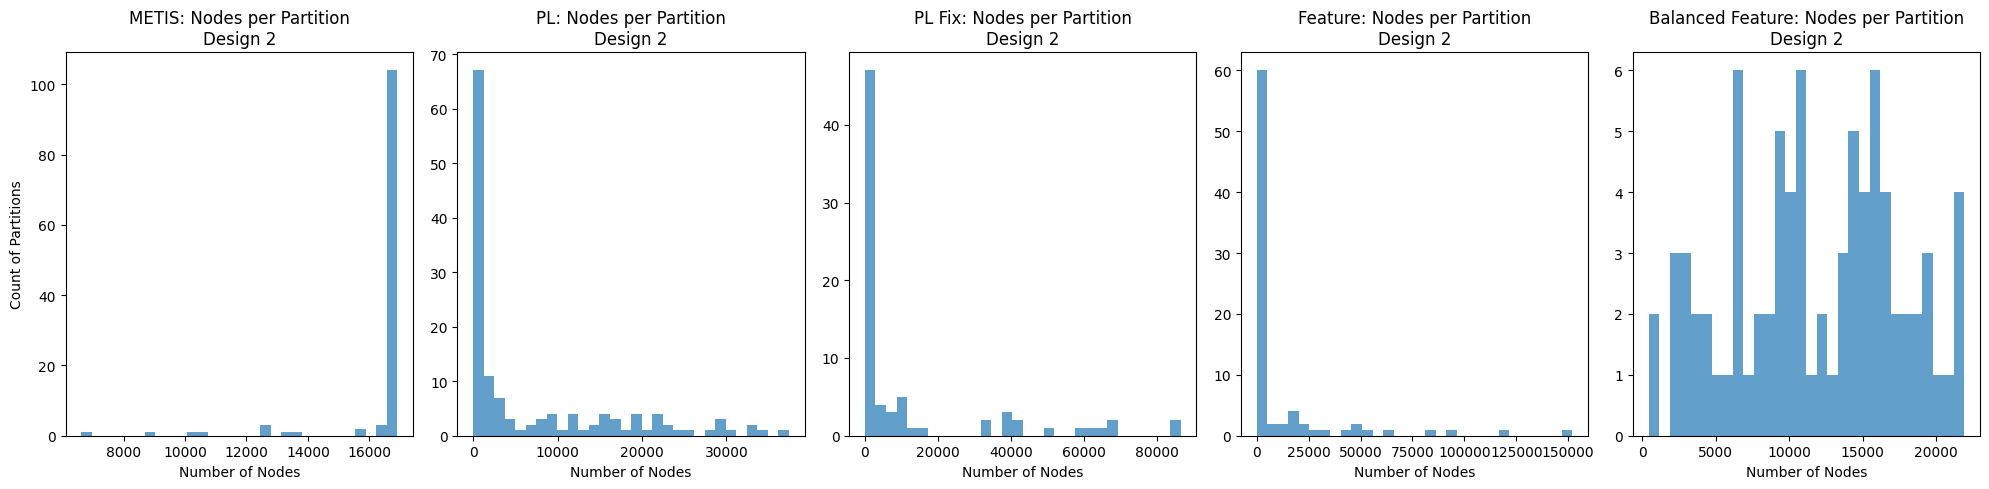


Analyzing design 3
Design 3 (Total nodes: 1,826,921)
  METIS   - Nodes per partition: 16311.8 ± 1604.7
           Number of partitions: 112
  PL      - Nodes per partition: 9291.3 ± 10653.8
           Number of partitions: 97
  PL Fix  - Nodes per partition: 11265.7 ± 13754.2
           Number of partitions: 80
  Feature - Nodes per partition: 11126.6 ± 30042.1
           Number of partitions: 81
  Balanced Feature - Nodes per partition: 11126.6 ± 11404.5
           Number of partitions: 81


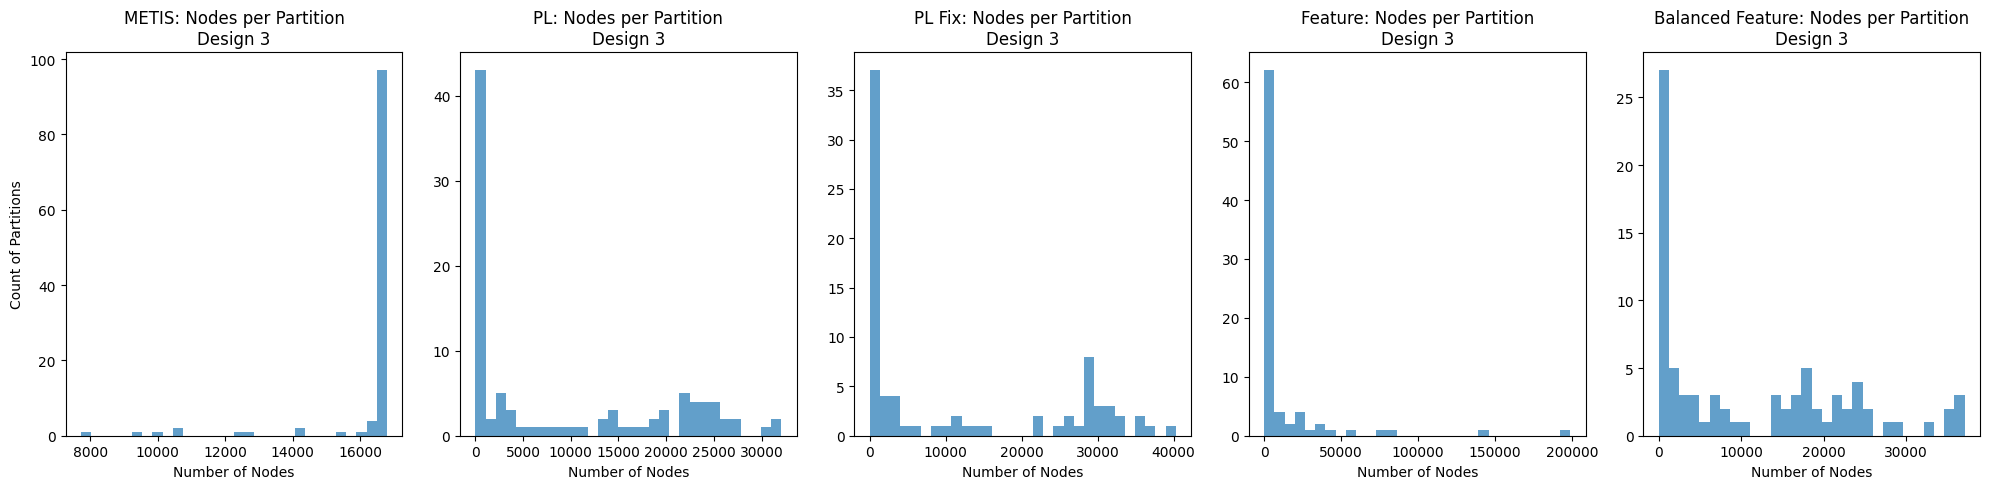


Analyzing design 5
Design 5 (Total nodes: 1,531,022)
  METIS   - Nodes per partition: 17011.4 ± 1960.9
           Number of partitions: 90
  PL      - Nodes per partition: 6797.6 ± 10163.1
           Number of partitions: 107
  PL Fix  - Nodes per partition: 8979.5 ± 13425.7
           Number of partitions: 81
  Feature - Nodes per partition: 8979.5 ± 19146.9
           Number of partitions: 81
  Balanced Feature - Nodes per partition: 8979.5 ± 5279.8
           Number of partitions: 81


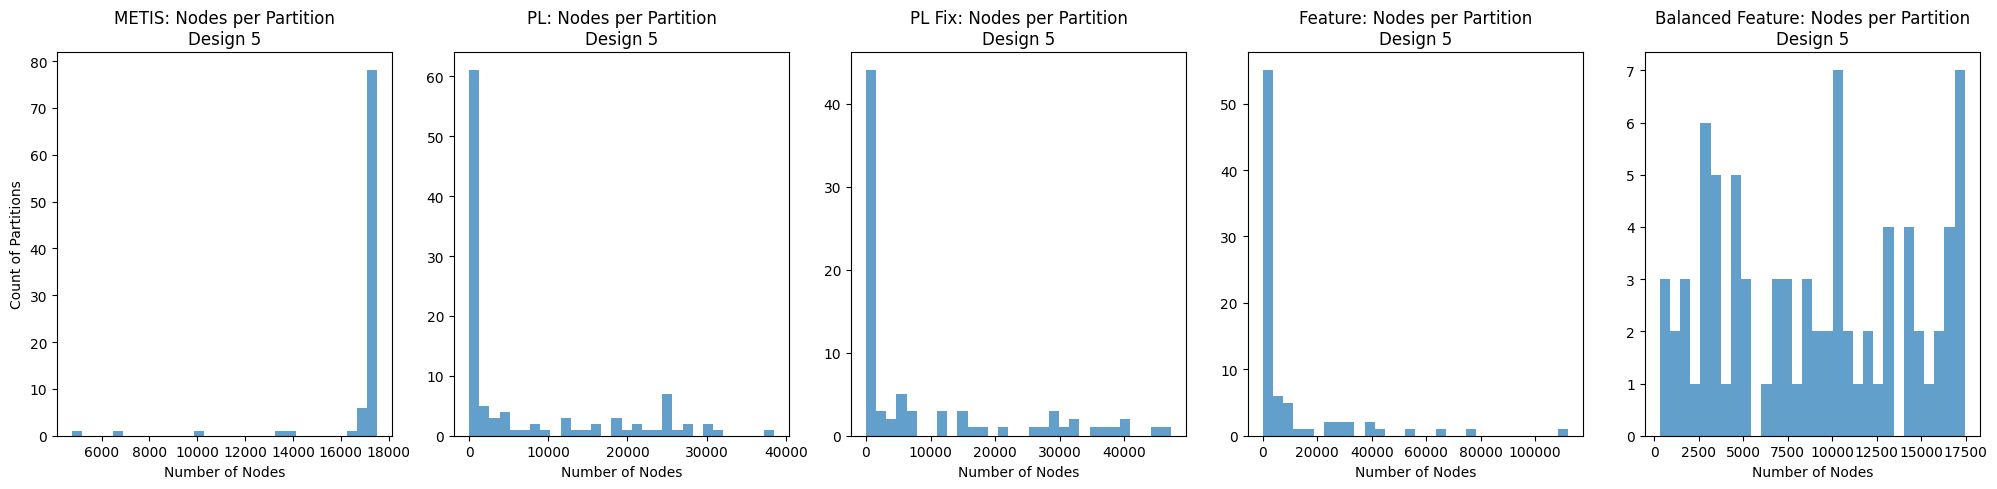


Analyzing design 6
Design 6 (Total nodes: 2,047,347)
  METIS   - Nodes per partition: 16510.9 ± 1710.4
           Number of partitions: 124
  PL      - Nodes per partition: 10082.0 ± 11718.6
           Number of partitions: 99
  PL Fix  - Nodes per partition: 11472.7 ± 14168.1
           Number of partitions: 87
  Feature - Nodes per partition: 12322.5 ± 32222.7
           Number of partitions: 81
  Balanced Feature - Nodes per partition: 17209.0 ± 19319.4
           Number of partitions: 58


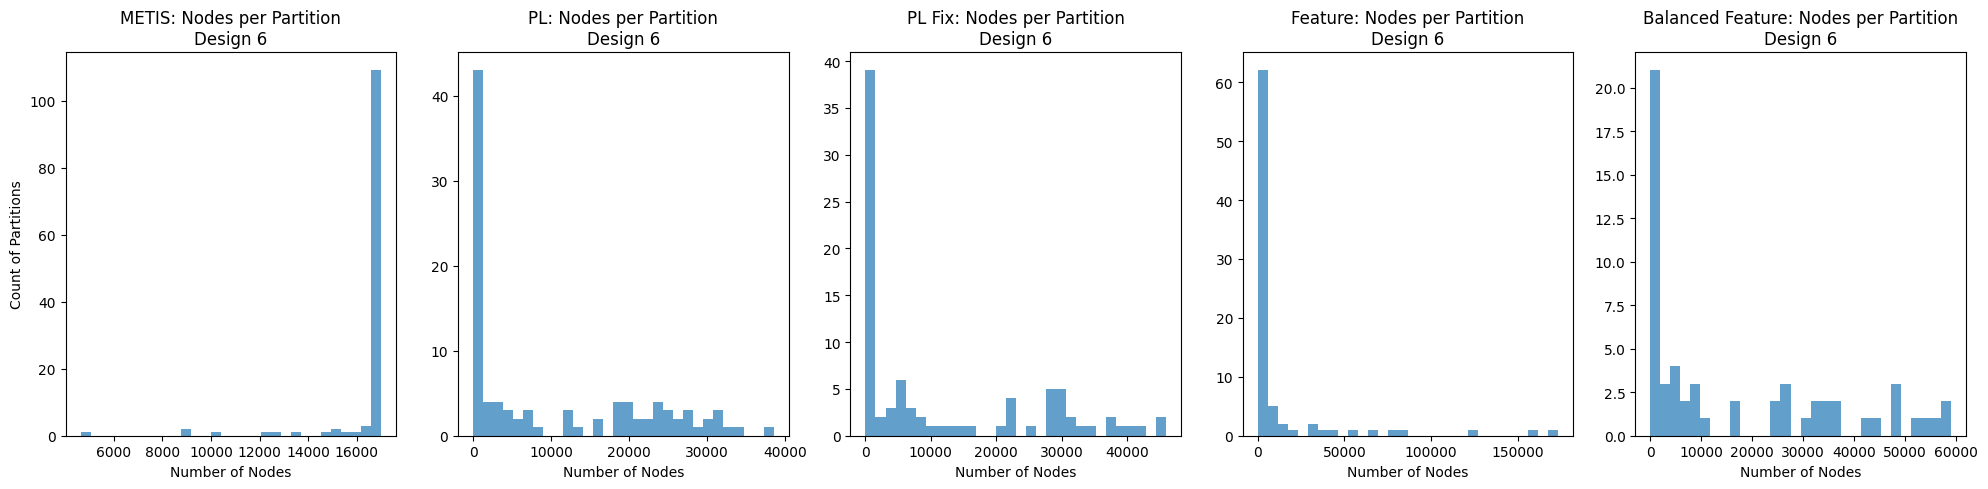


Analyzing design 7
Design 7 (Total nodes: 2,658,574)
  METIS   - Nodes per partition: 16210.8 ± 1609.0
           Number of partitions: 164
  PL      - Nodes per partition: 12101.4 ± 10624.8
           Number of partitions: 109
  PL Fix  - Nodes per partition: 14337.5 ± 14237.0
           Number of partitions: 92
  Feature - Nodes per partition: 16284.6 ± 45111.9
           Number of partitions: 81
  Balanced Feature - Nodes per partition: 19687.3 ± 13108.9
           Number of partitions: 67


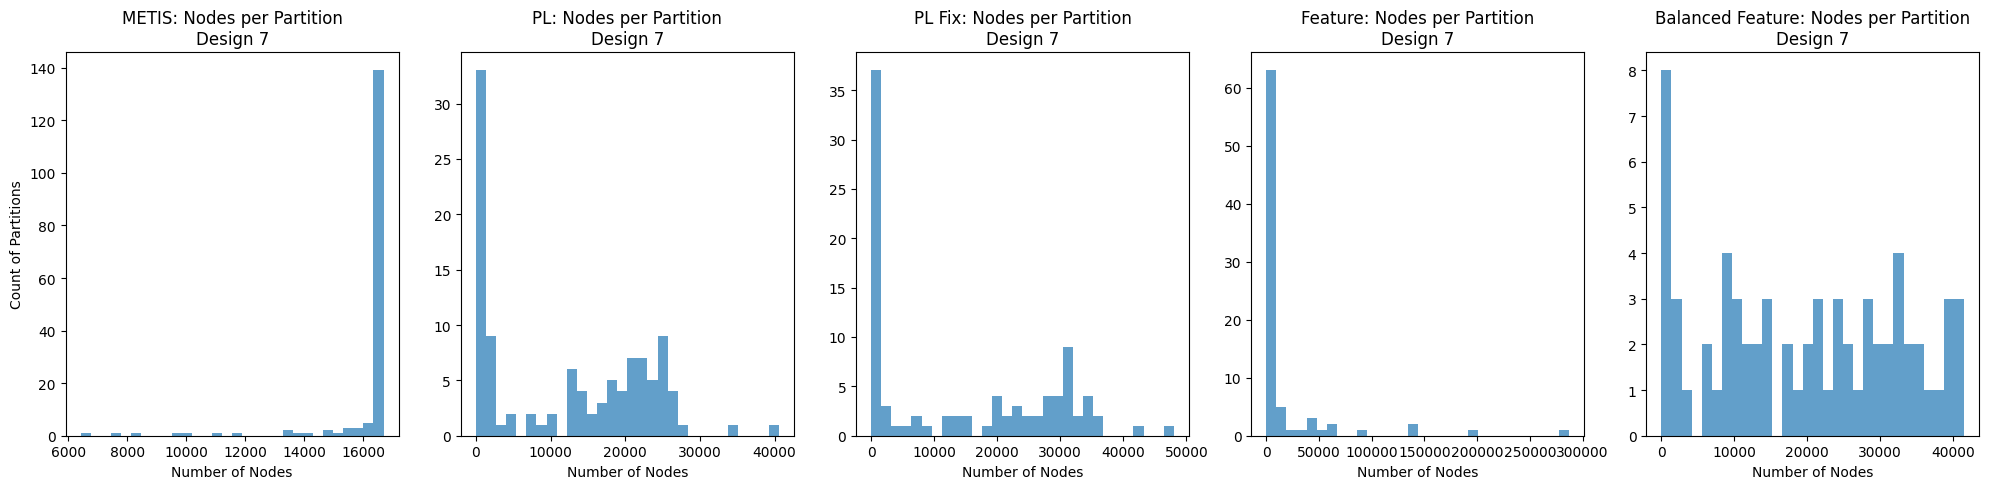


Analyzing design 9
Design 9 (Total nodes: 1,641,120)
  METIS   - Nodes per partition: 16248.7 ± 1806.1
           Number of partitions: 101
  PL      - Nodes per partition: 11261.3 ± 9922.9
           Number of partitions: 72
  PL Fix  - Nodes per partition: 11107.0 ± 9927.8
           Number of partitions: 73
  Feature - Nodes per partition: 10010.0 ± 23446.1
           Number of partitions: 81
  Balanced Feature - Nodes per partition: 10010.0 ± 5112.8
           Number of partitions: 81


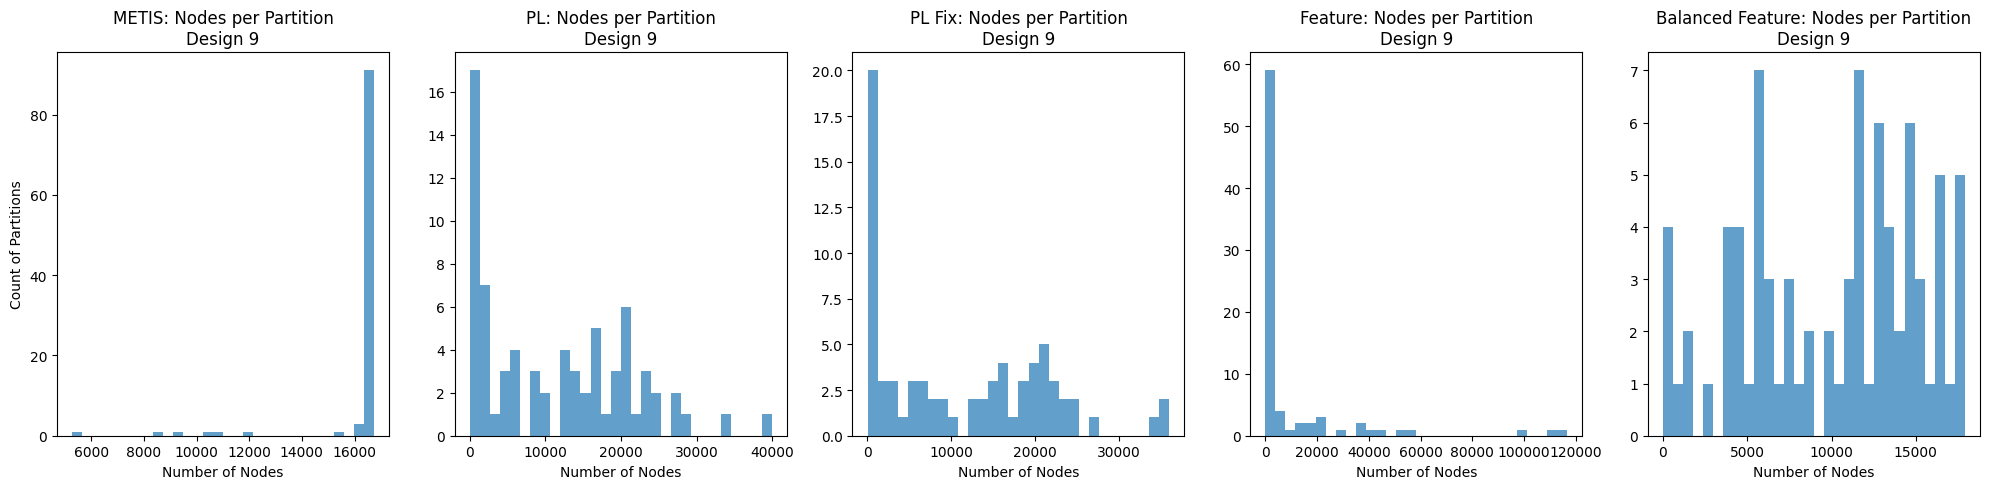


Analyzing design 11
Design 11 (Total nodes: 1,877,499)
  METIS   - Nodes per partition: 16326.1 ± 1857.3
           Number of partitions: 115
  PL      - Nodes per partition: 7328.2 ± 7991.9
           Number of partitions: 126
  PL Fix  - Nodes per partition: 12311.4 ± 15675.9
           Number of partitions: 75
  Feature - Nodes per partition: 11399.4 ± 27365.3
           Number of partitions: 81
  Balanced Feature - Nodes per partition: 11399.4 ± 5587.0
           Number of partitions: 81


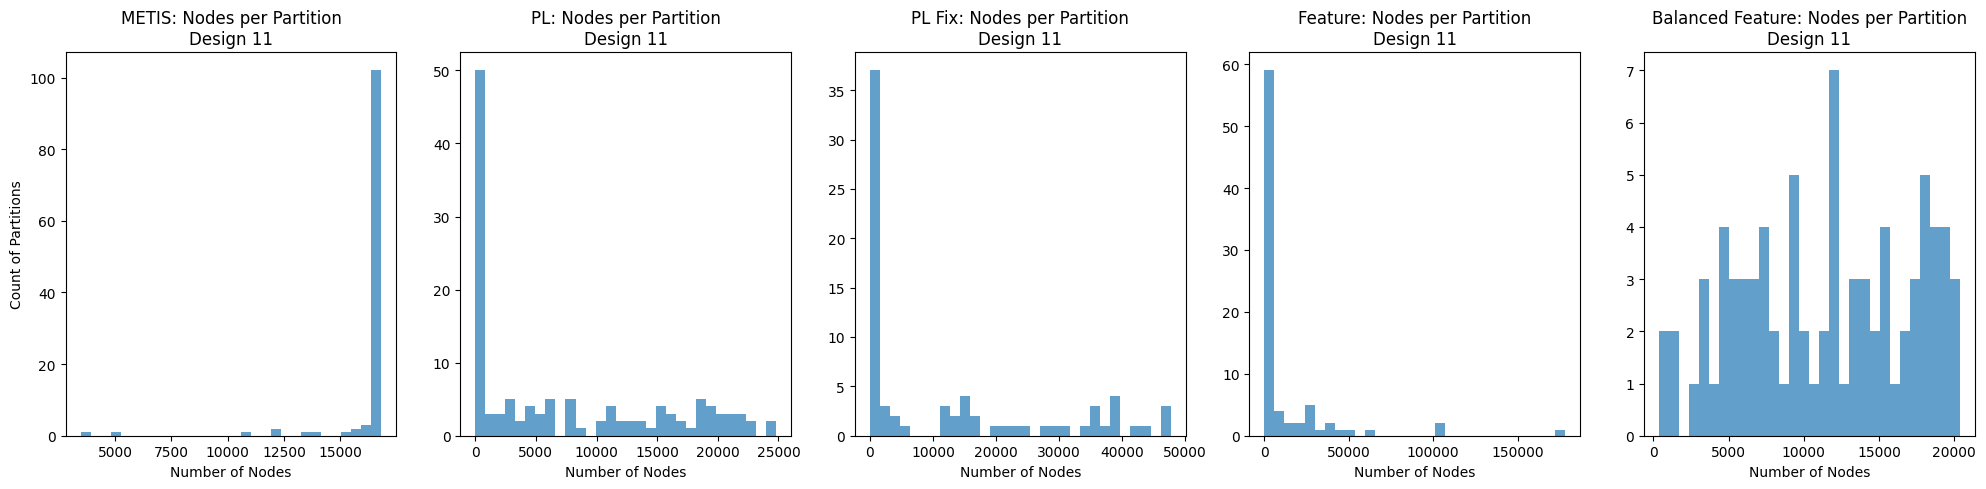


Analyzing design 14
Design 14 (Total nodes: 1,231,957)
  METIS   - Nodes per partition: 16426.1 ± 1632.4
           Number of partitions: 75
  PL      - Nodes per partition: 8895.9 ± 9315.2
           Number of partitions: 68
  PL Fix  - Nodes per partition: 7116.7 ± 7132.3
           Number of partitions: 85
  Feature - Nodes per partition: 7468.2 ± 19194.0
           Number of partitions: 81
  Balanced Feature - Nodes per partition: 7468.2 ± 3940.9
           Number of partitions: 81


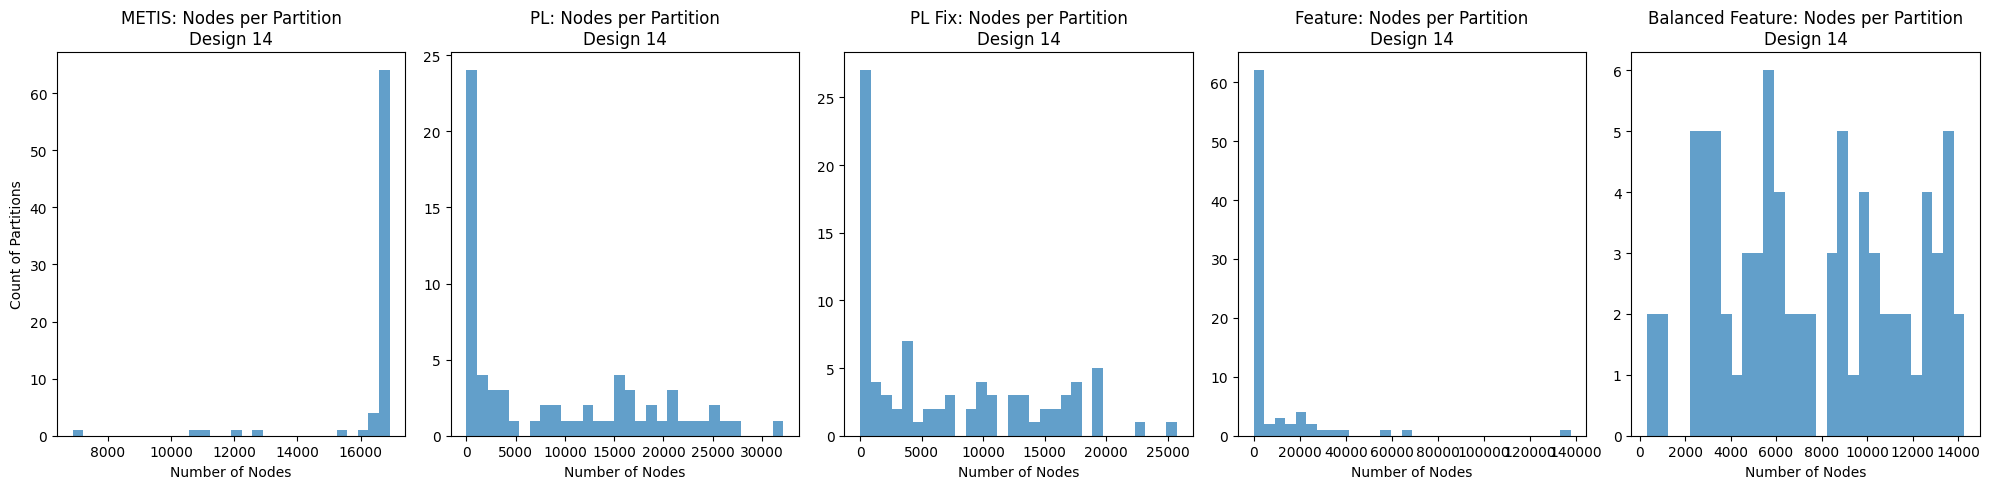


Analyzing design 16
Design 16 (Total nodes: 1,368,267)
  METIS   - Nodes per partition: 16485.1 ± 1866.2
           Number of partitions: 83
  PL      - Nodes per partition: 9323.4 ± 9081.7
           Number of partitions: 72
  PL Fix  - Nodes per partition: 8087.8 ± 7140.9
           Number of partitions: 83
  Feature - Nodes per partition: 8287.5 ± 16682.6
           Number of partitions: 81
  Balanced Feature - Nodes per partition: 8287.5 ± 4944.0
           Number of partitions: 81


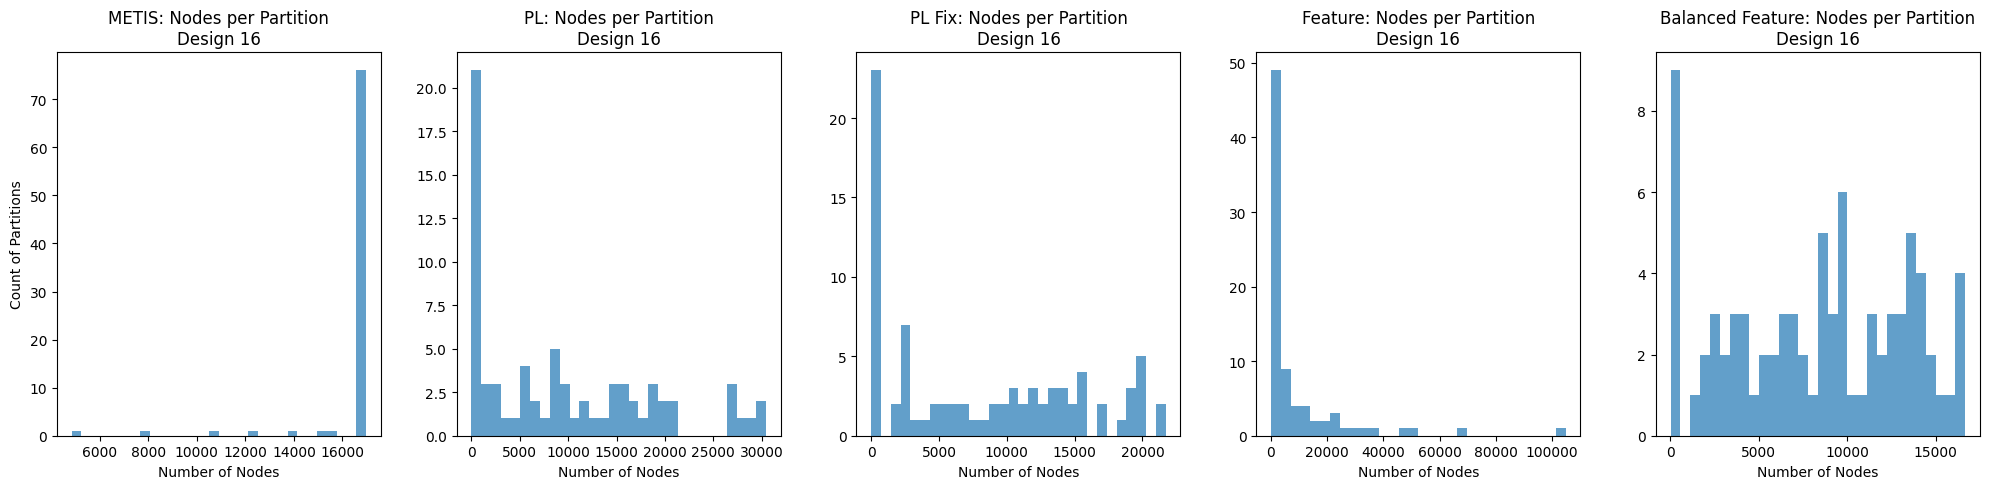

KeyError: 'balanced_feature_sizes'

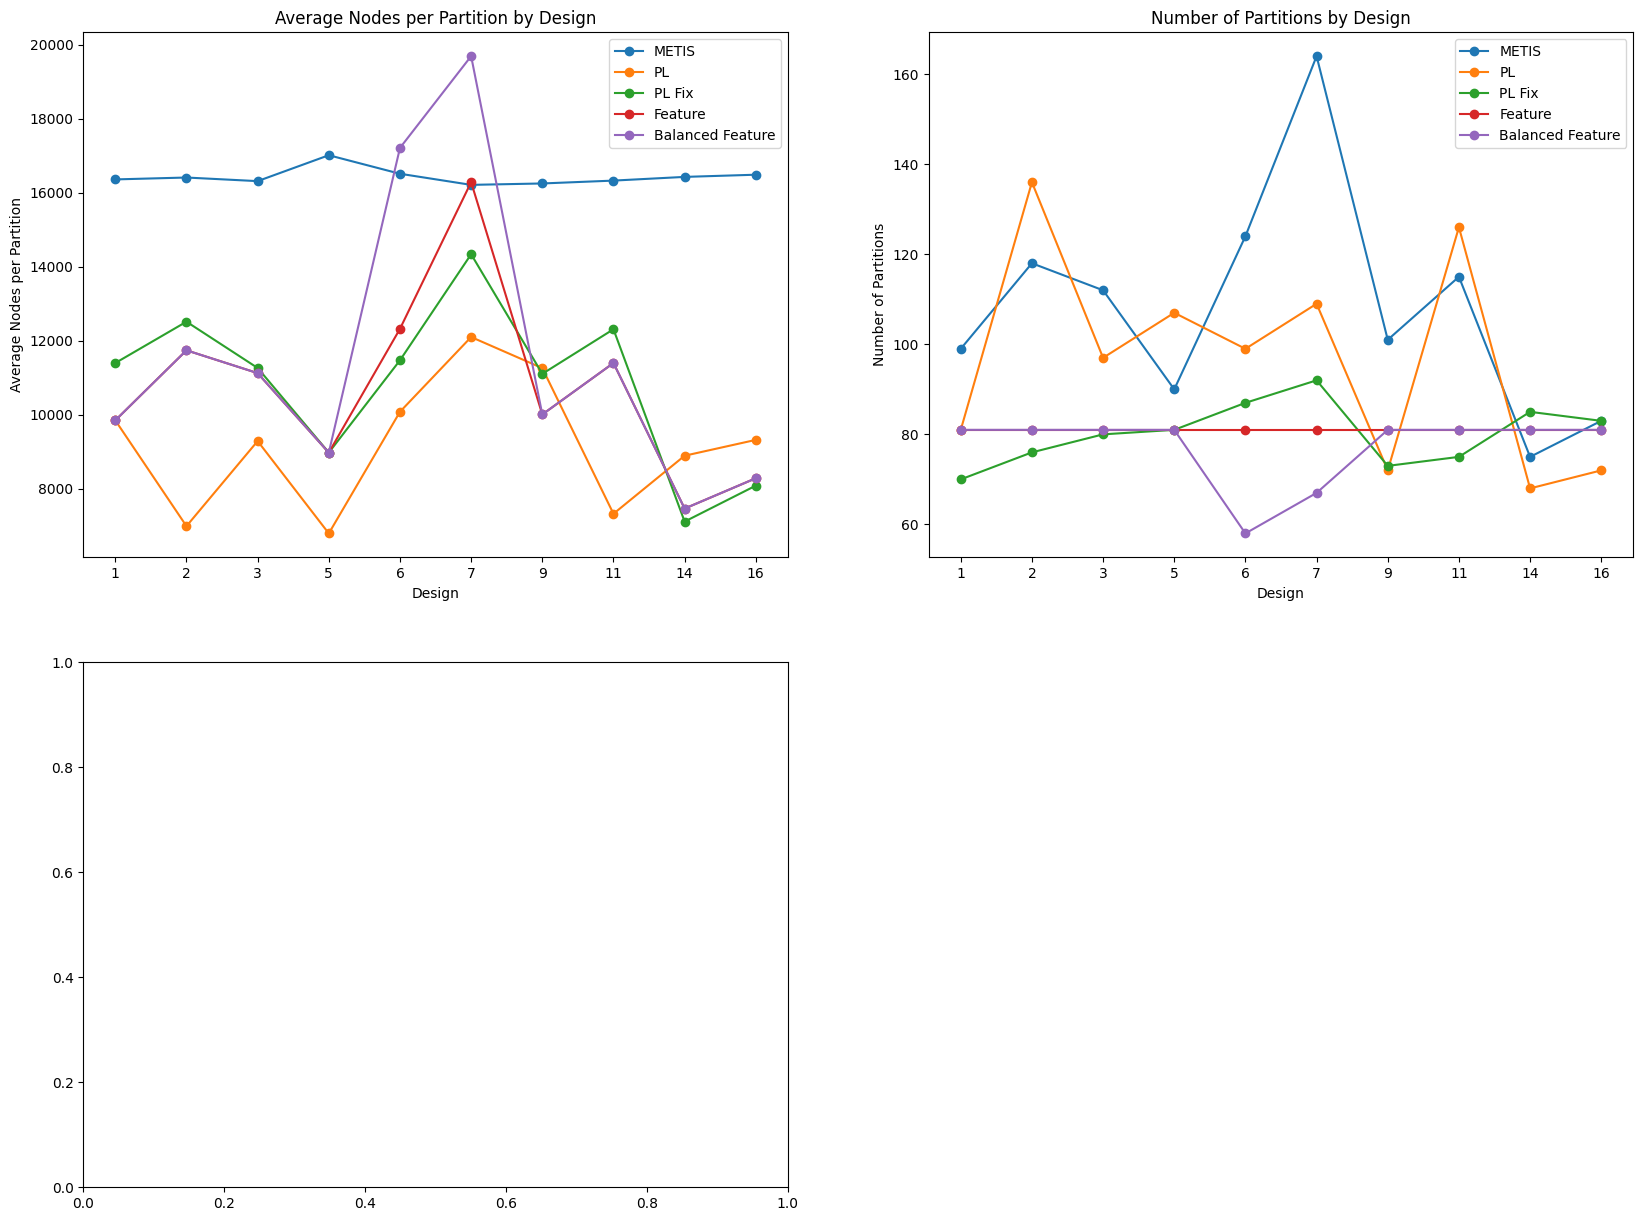

In [7]:
def analyze_partition_sizes(design_list):
    """
    Analyze the number of nodes in each partition for all methods (METIS, PL, PL_Fix, Feature)
    """
    results = []
    
    for design in design_list:
        print(f"\nAnalyzing design {design}")
        
        # Load all partition types
        metis_path = f"../../data/superblue/superblue_{design}/metis_part_dict.pkl"
        pl_path = f"../../data/superblue/superblue_{design}/pl_part_dict.pkl"
        pl_fix_path = f"../../data/superblue/superblue_{design}/pl_fix_part_dict.pkl"
        feature_path = f"../../data/superblue/superblue_{design}/feature_approx_physical_part_dict.pkl"
        balanced_feature_path = f"../../data/superblue/superblue_{design}/balanced_feature_approx_physical_part_dict.pkl"
        
        with open(metis_path, 'rb') as f:
            metis_data = pickle.load(f)
        with open(pl_path, 'rb') as f:
            pl_data = pickle.load(f)
        with open(pl_fix_path, 'rb') as f:
            pl_fix_data = pickle.load(f)
        with open(feature_path, 'rb') as f:
            feature_data = pickle.load(f)
        with open(balanced_feature_path, 'rb') as f:
            balanced_feature_data = pickle.load(f)
        # Calculate nodes per partition
        metis_sizes = get_nodes_per_partition(metis_data)
        pl_sizes = get_nodes_per_partition(pl_data)
        pl_fix_sizes = get_nodes_per_partition(pl_fix_data)
        feature_sizes = get_nodes_per_partition(feature_data)
        balanced_feature_sizes = get_nodes_per_partition(balanced_feature_data)
        # Store results
        results.append({
            'design': design,
            'total_nodes': len(metis_data),
            'metis_sizes': metis_sizes,
            'pl_sizes': pl_sizes,
            'pl_fix_sizes': pl_fix_sizes,
            'feature_sizes': feature_sizes,
            'metis_stats': calculate_size_stats(metis_sizes),
            'pl_stats': calculate_size_stats(pl_sizes),
            'pl_fix_stats': calculate_size_stats(pl_fix_sizes),
            'feature_stats': calculate_size_stats(feature_sizes),
            'balanced_feature_stats': calculate_size_stats(balanced_feature_sizes)
        })
        
        # Print per-design statistics
        print(f"Design {design} (Total nodes: {len(metis_data):,})")
        print(f"  METIS   - Nodes per partition: {results[-1]['metis_stats']['mean']:.1f} ± {results[-1]['metis_stats']['std']:.1f}")
        print(f"           Number of partitions: {len(metis_sizes)}")
        print(f"  PL      - Nodes per partition: {results[-1]['pl_stats']['mean']:.1f} ± {results[-1]['pl_stats']['std']:.1f}")
        print(f"           Number of partitions: {len(pl_sizes)}")
        print(f"  PL Fix  - Nodes per partition: {results[-1]['pl_fix_stats']['mean']:.1f} ± {results[-1]['pl_fix_stats']['std']:.1f}")
        print(f"           Number of partitions: {len(pl_fix_sizes)}")
        print(f"  Feature - Nodes per partition: {results[-1]['feature_stats']['mean']:.1f} ± {results[-1]['feature_stats']['std']:.1f}")
        print(f"           Number of partitions: {len(feature_sizes)}")
        print(f"  Balanced Feature - Nodes per partition: {results[-1]['balanced_feature_stats']['mean']:.1f} ± {results[-1]['balanced_feature_stats']['std']:.1f}")
        print(f"           Number of partitions: {len(balanced_feature_sizes)}")
        
        # Plot node distribution histograms
        plt.figure(figsize=(20, 5))
        
        plt.subplot(1, 5, 1)
        plt.hist(metis_sizes, bins=30, alpha=0.7)
        plt.title(f'METIS: Nodes per Partition\nDesign {design}')
        plt.xlabel('Number of Nodes')
        plt.ylabel('Count of Partitions')
        
        plt.subplot(1, 5, 2)
        plt.hist(pl_sizes, bins=30, alpha=0.7)
        plt.title(f'PL: Nodes per Partition\nDesign {design}')
        plt.xlabel('Number of Nodes')
        
        plt.subplot(1, 5, 3)
        plt.hist(pl_fix_sizes, bins=30, alpha=0.7)
        plt.title(f'PL Fix: Nodes per Partition\nDesign {design}')
        plt.xlabel('Number of Nodes')
        
        plt.subplot(1, 5, 4)
        plt.hist(feature_sizes, bins=30, alpha=0.7)
        plt.title(f'Feature: Nodes per Partition\nDesign {design}')
        plt.xlabel('Number of Nodes')

        plt.subplot(1, 5, 5)
        plt.hist(balanced_feature_sizes, bins=30, alpha=0.7)
        plt.title(f'Balanced Feature: Nodes per Partition\nDesign {design}')
        plt.xlabel('Number of Nodes')
        
        plt.tight_layout()
        plt.show()
        
    return results

def get_nodes_per_partition(partition):
    """
    Calculate number of nodes in each partition
    """
    sizes = defaultdict(int)
    for node, cluster in partition.items():
        sizes[cluster] += 1
    return list(sizes.values())

def calculate_size_stats(sizes):
    """
    Calculate statistics for number of nodes per partition
    """
    return {
        'mean': np.mean(sizes),
        'std': np.std(sizes),
        'min': np.min(sizes),
        'max': np.max(sizes),
        'median': np.median(sizes),
        'total_partitions': len(sizes)
    }

# Run analysis
design_list = [1, 2, 3, 5, 6, 7, 9, 11, 14, 16]
results = analyze_partition_sizes(design_list)

# Create summary plots
plt.figure(figsize=(20, 15))

# Plot 1: Average nodes per partition across designs
plt.subplot(2, 2, 1)
x = range(len(design_list))
plt.plot(x, [r['metis_stats']['mean'] for r in results], 'o-', label='METIS')
plt.plot(x, [r['pl_stats']['mean'] for r in results], 'o-', label='PL')
plt.plot(x, [r['pl_fix_stats']['mean'] for r in results], 'o-', label='PL Fix')
plt.plot(x, [r['feature_stats']['mean'] for r in results], 'o-', label='Feature')
plt.plot(x, [r['balanced_feature_stats']['mean'] for r in results], 'o-', label='Balanced Feature')
plt.title('Average Nodes per Partition by Design')
plt.xlabel('Design')
plt.ylabel('Average Nodes per Partition')
plt.xticks(x, design_list)
plt.legend()

# Plot 2: Number of partitions per design
plt.subplot(2, 2, 2)
x = range(len(design_list))
plt.plot(x, [r['metis_stats']['total_partitions'] for r in results], 'o-', label='METIS')
plt.plot(x, [r['pl_stats']['total_partitions'] for r in results], 'o-', label='PL')
plt.plot(x, [r['pl_fix_stats']['total_partitions'] for r in results], 'o-', label='PL Fix')
plt.plot(x, [r['feature_stats']['total_partitions'] for r in results], 'o-', label='Feature')
plt.plot(x, [r['balanced_feature_stats']['total_partitions'] for r in results], 'o-', label='Balanced Feature')
plt.title('Number of Partitions by Design')
plt.xlabel('Design')
plt.ylabel('Number of Partitions')
plt.xticks(x, design_list)
plt.legend()

# Plot 3: Box plot of nodes per partition
plt.subplot(2, 2, 3)
all_sizes = {
    'METIS': [size for r in results for size in r['metis_sizes']],
    'PL': [size for r in results for size in r['pl_sizes']],
    'PL Fix': [size for r in results for size in r['pl_fix_sizes']],
    'Feature': [size for r in results for size in r['feature_sizes']],
    'Balanced Feature': [size for r in results for size in r['balanced_feature_sizes']]
}
plt.boxplot(all_sizes.values(), labels=all_sizes.keys())
plt.title('Distribution of Nodes per Partition')
plt.ylabel('Number of Nodes')

plt.tight_layout()
plt.show()

# Print overall statistics
print("\nOverall Statistics Across All Designs:")

for method in ['METIS', 'PL', 'PL Fix', 'Feature']:
    stats_key = f"{method.lower().replace(' ', '_')}_stats"
    sizes_key = f"{method.lower().replace(' ', '_')}_sizes"
    
    avg_nodes = np.mean([r[stats_key]['mean'] for r in results])
    std_nodes = np.mean([r[stats_key]['std'] for r in results])
    avg_partitions = np.mean([r[stats_key]['total_partitions'] for r in results])
    min_nodes = np.min([r[stats_key]['min'] for r in results])
    max_nodes = np.max([r[stats_key]['max'] for r in results])
    
    print(f"\n{method} Partitioning:")
    print(f"  Average nodes per partition: {avg_nodes:.1f} ± {std_nodes:.1f}")
    print(f"  Average number of partitions: {avg_partitions:.1f}")
    print(f"  Node range: {min_nodes:.0f} - {max_nodes:.0f}")


Analyzing design 1
Design 1:
  PL     - Avg size: 9851.1 ± 11743.9
  PL Fix - Avg size: 11399.1 ± 12066.6
  Feature- Avg size: 9851.1 ± 61969.5


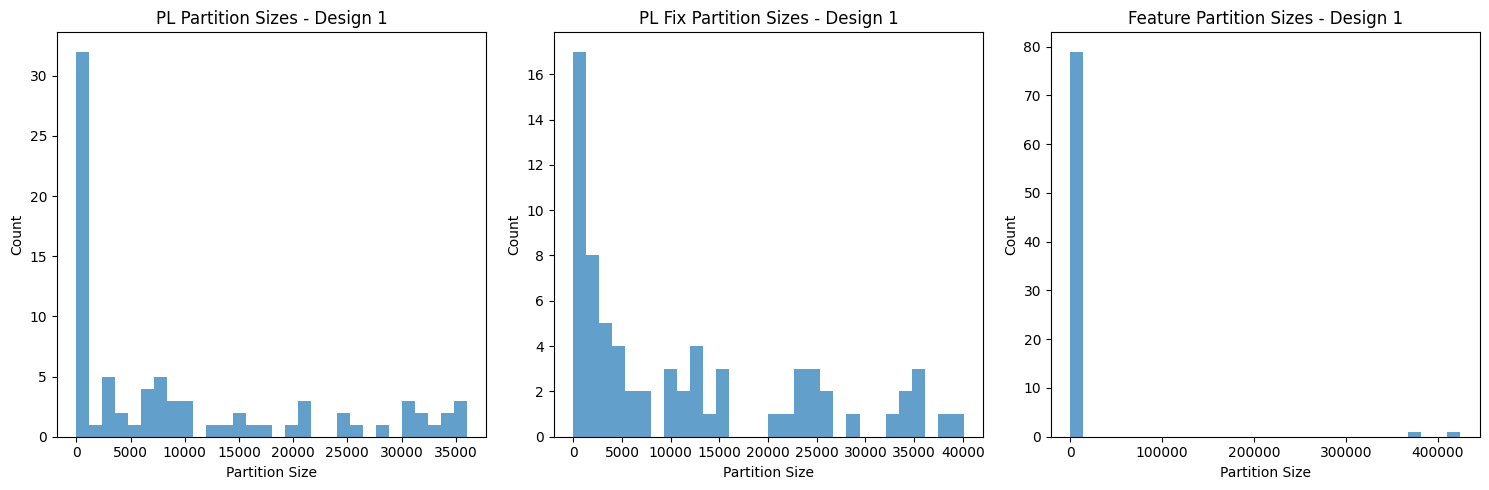


Analyzing design 2
Design 2:
  PL     - Avg size: 6993.9 ± 9724.1
  PL Fix - Avg size: 12515.3 ± 22183.9
  Feature- Avg size: 11742.8 ± 72492.2


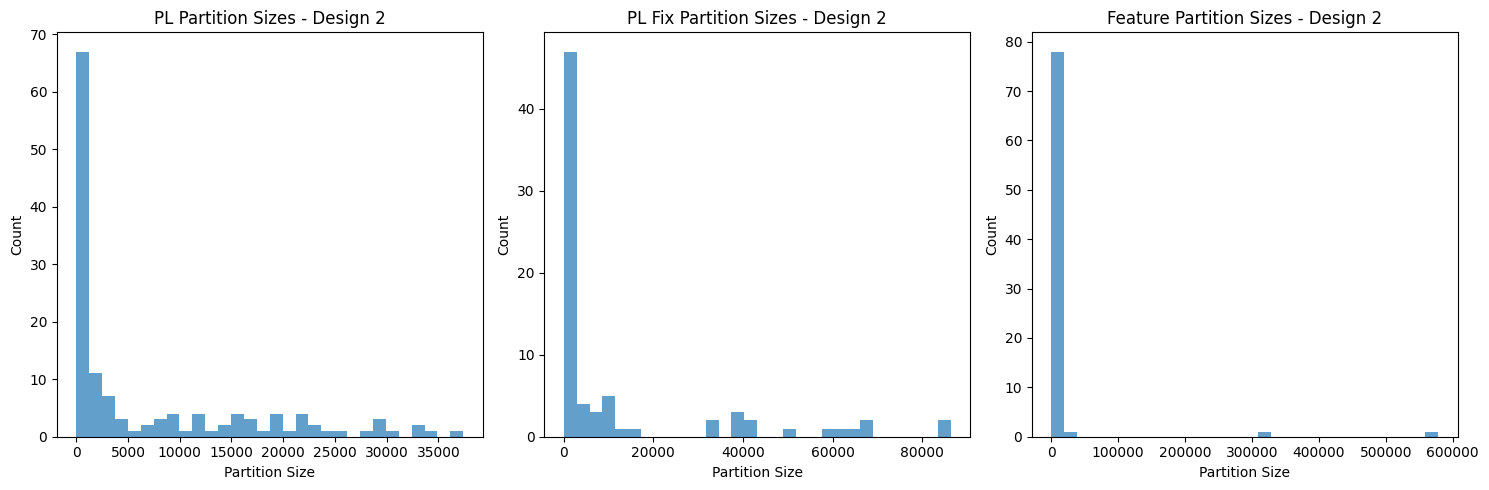


Analyzing design 3
Design 3:
  PL     - Avg size: 9291.3 ± 10653.8
  PL Fix - Avg size: 11265.7 ± 13754.2
  Feature- Avg size: 11126.6 ± 77901.0


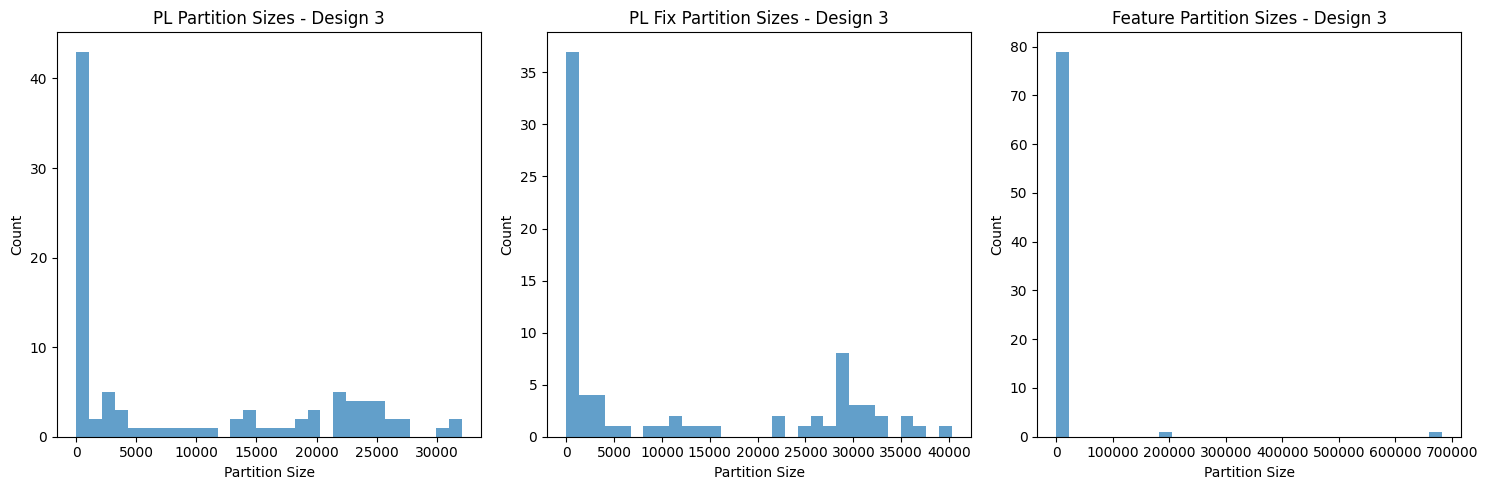


Analyzing design 5
Design 5:
  PL     - Avg size: 6797.6 ± 10163.1
  PL Fix - Avg size: 8979.5 ± 13425.7
  Feature- Avg size: 8979.5 ± 52178.9


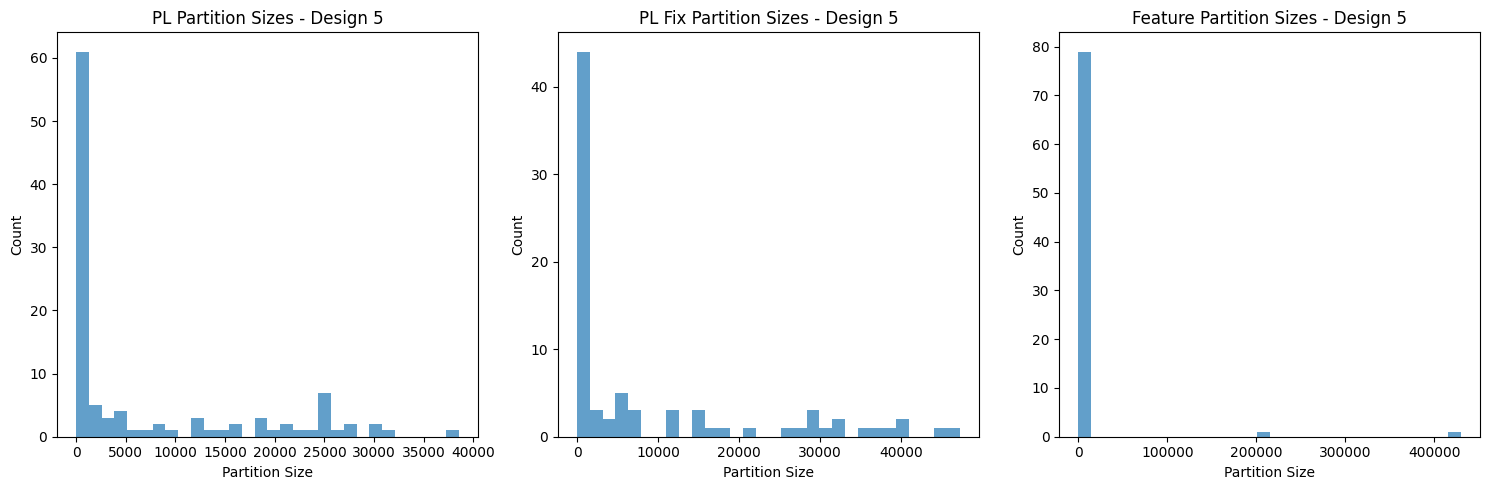


Analyzing design 6
Design 6:
  PL     - Avg size: 10082.0 ± 11718.6
  PL Fix - Avg size: 11472.7 ± 14168.1
  Feature- Avg size: 12322.5 ± 70159.1


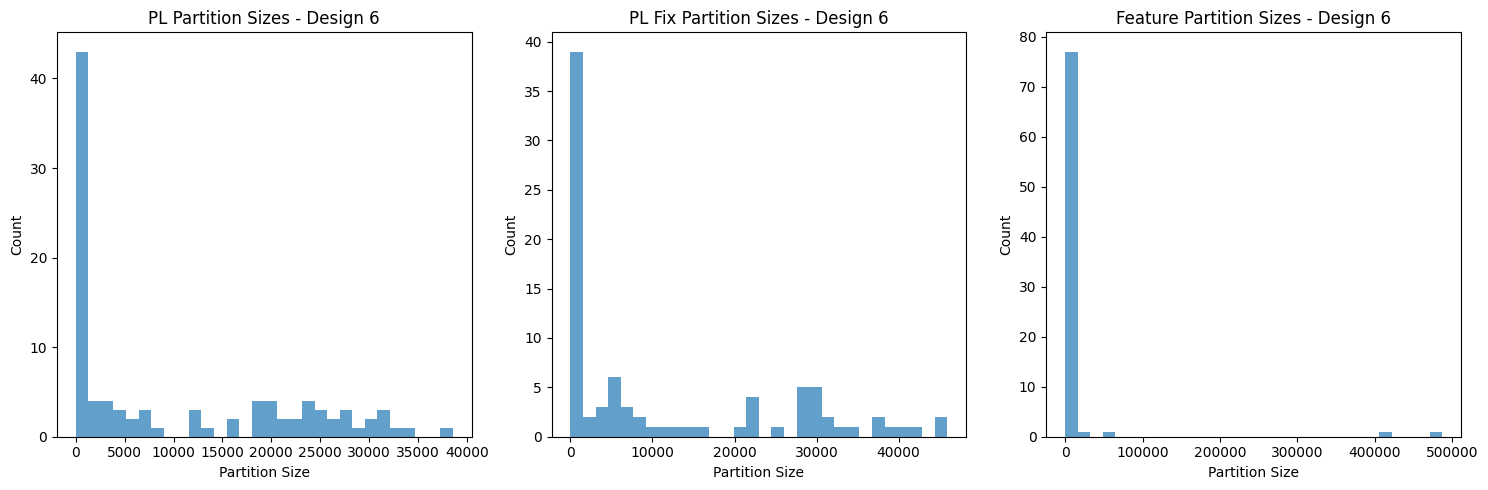


Analyzing design 7
Design 7:
  PL     - Avg size: 12101.4 ± 10624.8
  PL Fix - Avg size: 14337.5 ± 14237.0
  Feature- Avg size: 16284.6 ± 134040.9


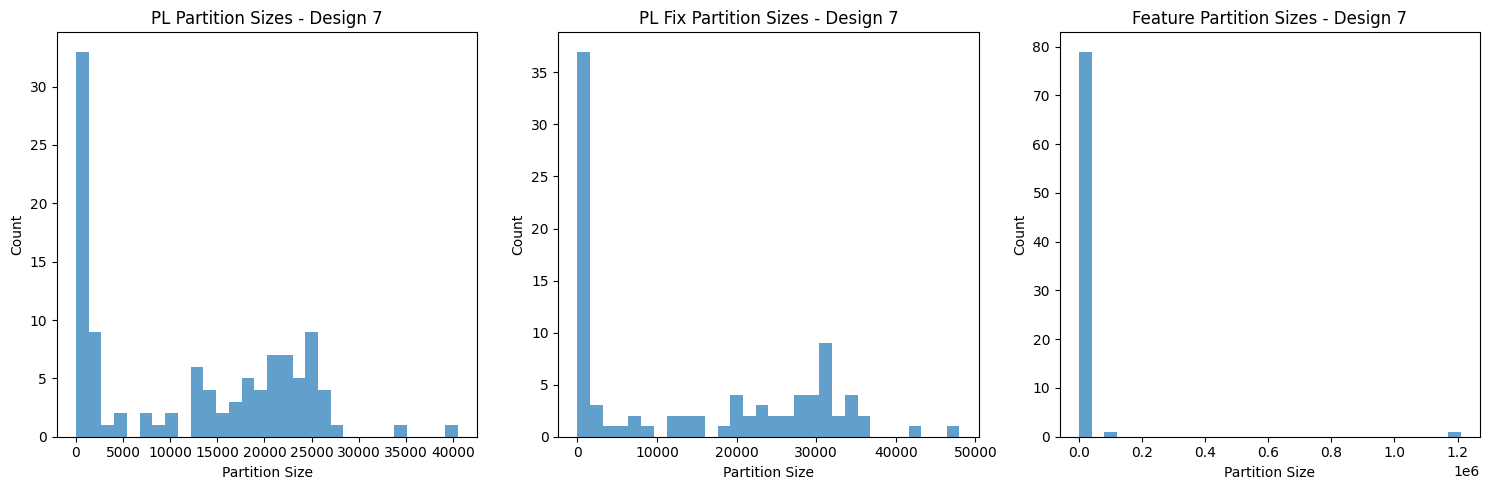


Analyzing design 9
Design 9:
  PL     - Avg size: 11261.3 ± 9922.9
  PL Fix - Avg size: 11107.0 ± 9927.8
  Feature- Avg size: 10010.0 ± 43210.6


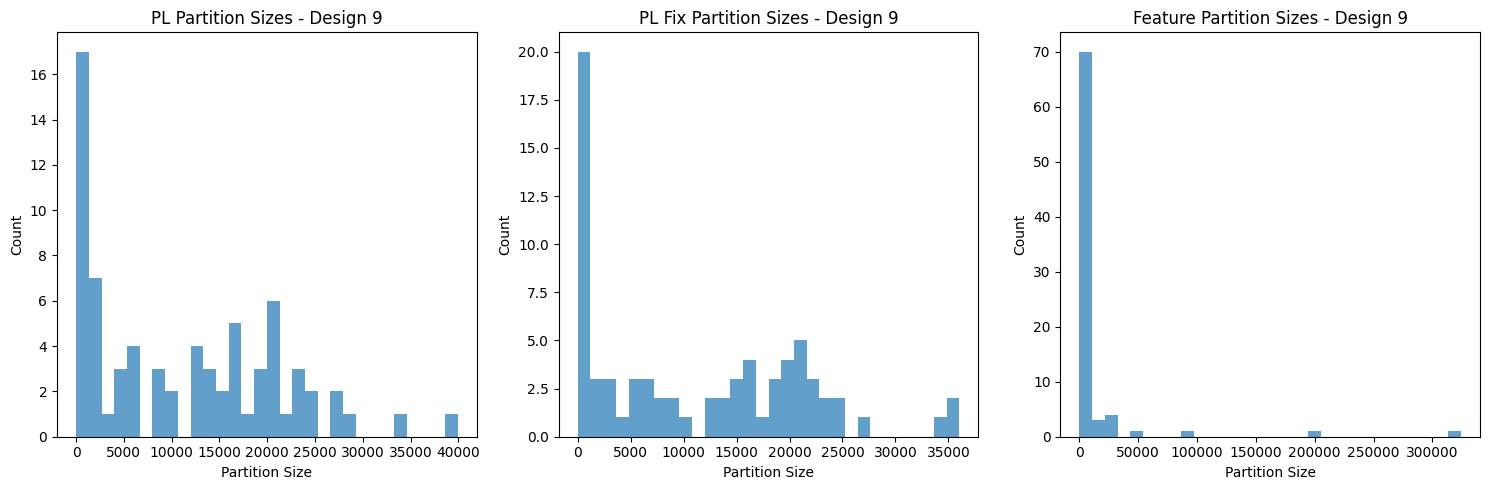


Analyzing design 11
Design 11:
  PL     - Avg size: 7328.2 ± 7991.9
  PL Fix - Avg size: 12311.4 ± 15675.9
  Feature- Avg size: 11399.4 ± 71044.3


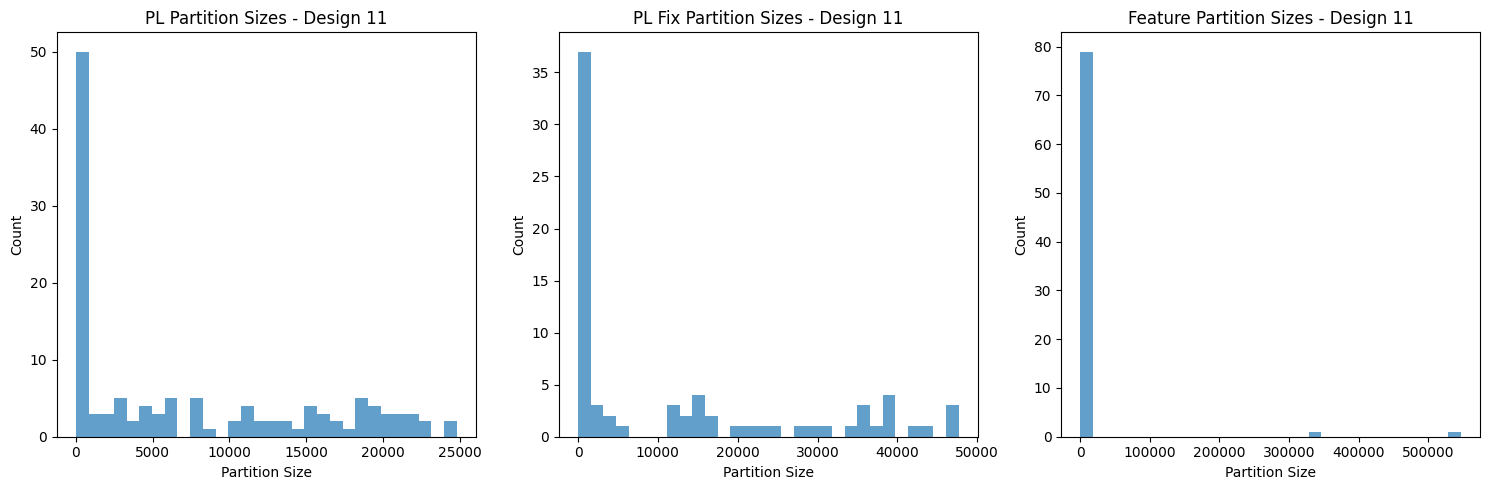


Analyzing design 14
Design 14:
  PL     - Avg size: 8895.9 ± 9315.2
  PL Fix - Avg size: 7116.7 ± 7132.3
  Feature- Avg size: 7468.2 ± 49915.8


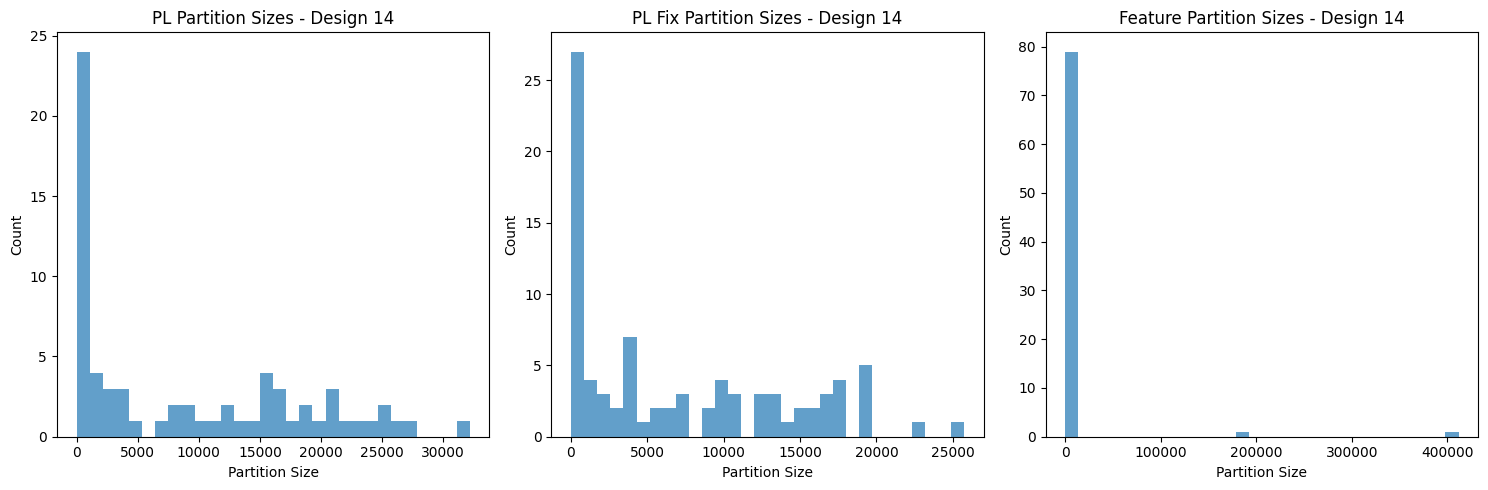


Analyzing design 16
Design 16:
  PL     - Avg size: 9323.4 ± 9081.7
  PL Fix - Avg size: 8087.8 ± 7140.9
  Feature- Avg size: 8287.5 ± 53301.1


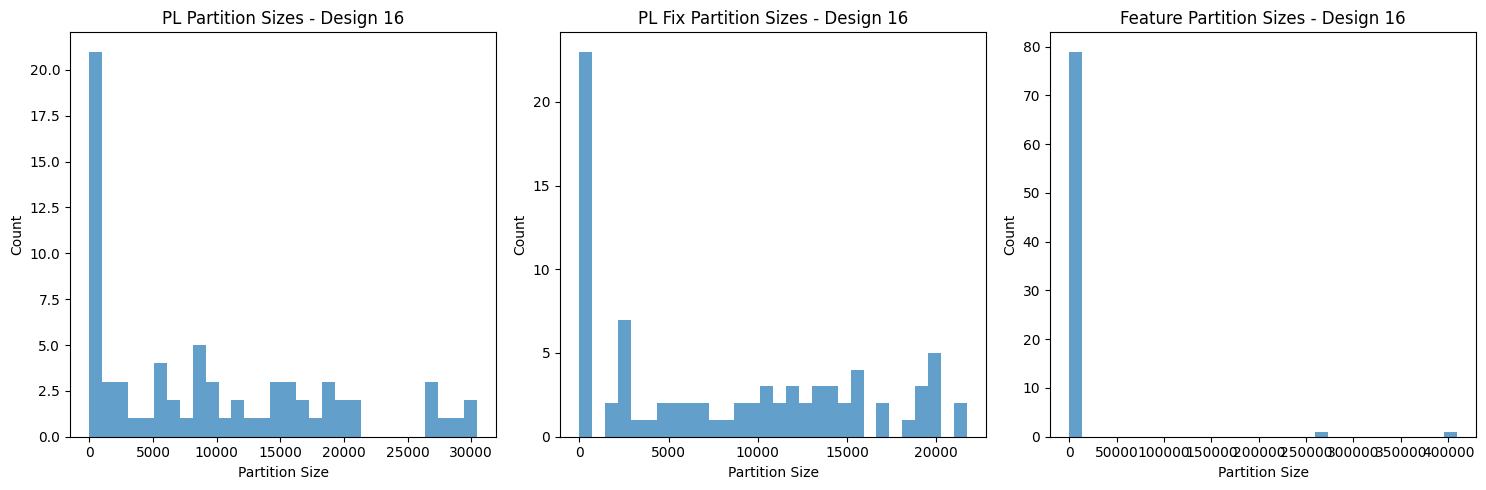

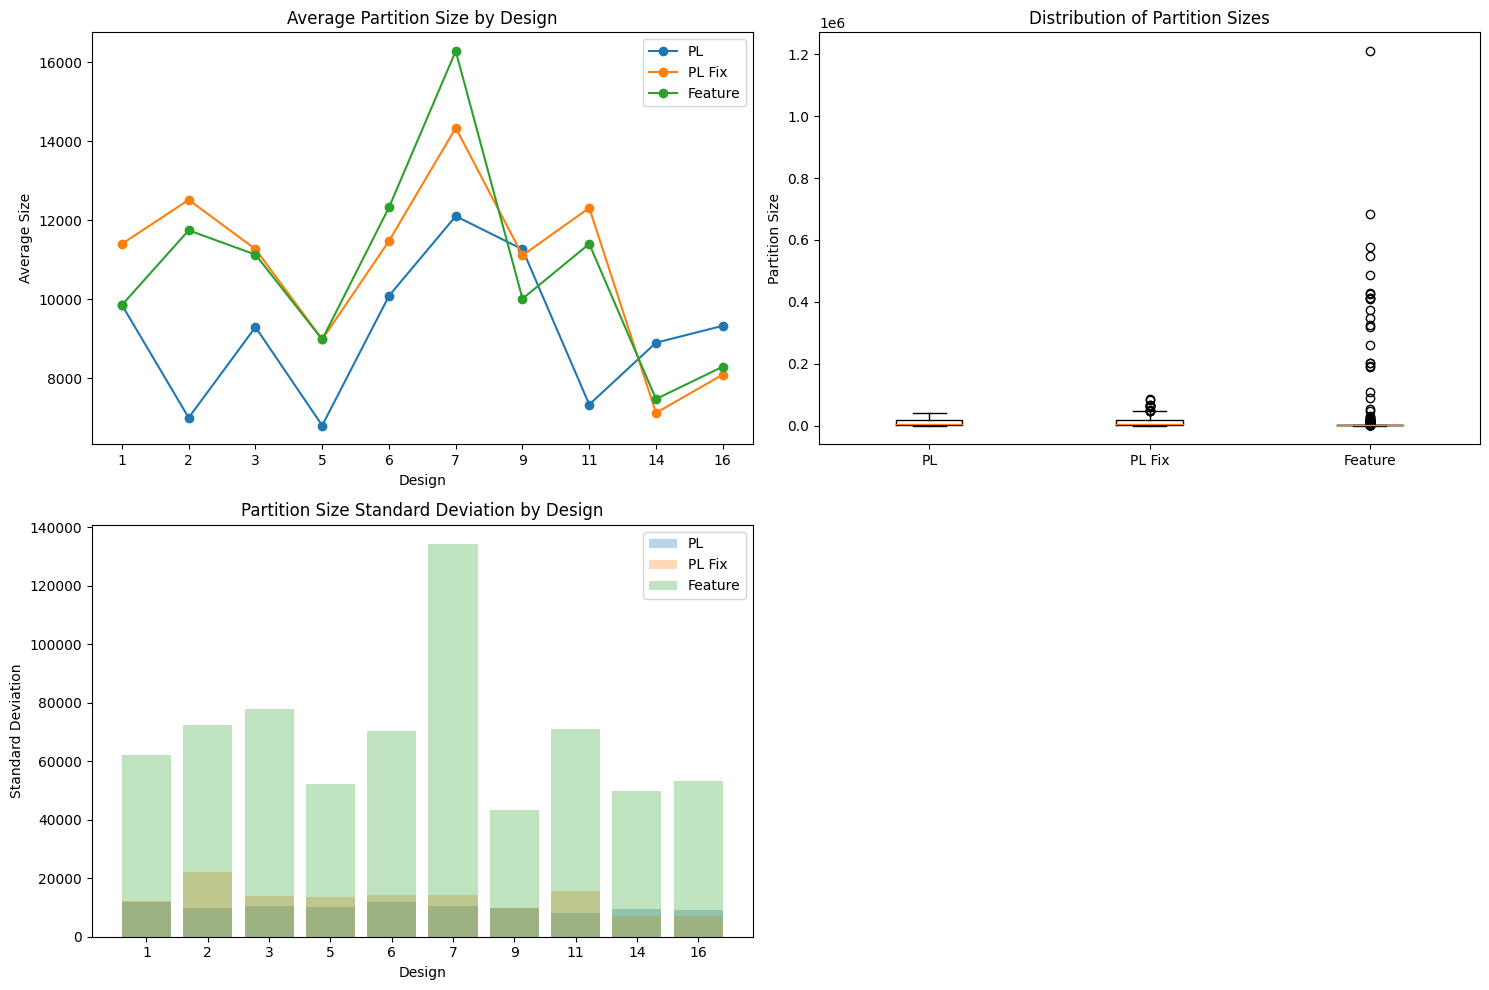


Overall Statistics:

PL Partitions:
  Average size: 9192.6 ± 1677.1
  Average std: 10094.0
  Size range: 1 - 40544

PL Fix Partitions:
  Average size: 10859.3 ± 2075.2
  Average std: 12971.2
  Size range: 1 - 86397

Feature Partitions:
  Average size: 10747.2 ± 2366.0
  Average std: 68621.3
  Size range: 1 - 1210415


In [41]:

def analyze_partition_sizes(design_list):
    """
    Analyze the sizes of partitions for each method (PL, PL_Fix, Feature)
    """
    results = []
    
    for design in design_list:
        print(f"\nAnalyzing design {design}")
        
        # Load partitions
        pl_path = f"../../data/superblue/superblue_{design}/pl_part_dict.pkl"
        pl_fix_path = f"../../data/superblue/superblue_{design}/pl_fix_part_dict.pkl"
        feature_path = f"../../data/superblue/superblue_{design}/feature_approx_physical_part_dict.pkl"
        
        with open(pl_path, 'rb') as f:
            pl_data = pickle.load(f)
        with open(pl_fix_path, 'rb') as f:
            pl_fix_data = pickle.load(f)
        with open(feature_path, 'rb') as f:
            feature_data = pickle.load(f)
            
        # Calculate partition sizes
        pl_sizes = get_partition_sizes(pl_data)
        pl_fix_sizes = get_partition_sizes(pl_fix_data)
        feature_sizes = get_partition_sizes(feature_data)
        
        results.append({
            'design': design,
            'pl_sizes': pl_sizes,
            'pl_fix_sizes': pl_fix_sizes,
            'feature_sizes': feature_sizes,
            'pl_stats': calculate_size_stats(pl_sizes),
            'pl_fix_stats': calculate_size_stats(pl_fix_sizes),
            'feature_stats': calculate_size_stats(feature_sizes)
        })
        
        # Print statistics
        print(f"Design {design}:")
        print(f"  PL     - Avg size: {results[-1]['pl_stats']['mean']:.1f} ± {results[-1]['pl_stats']['std']:.1f}")
        print(f"  PL Fix - Avg size: {results[-1]['pl_fix_stats']['mean']:.1f} ± {results[-1]['pl_fix_stats']['std']:.1f}")
        print(f"  Feature- Avg size: {results[-1]['feature_stats']['mean']:.1f} ± {results[-1]['feature_stats']['std']:.1f}")
        
        # Plot size distributions
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.hist(pl_sizes, bins=30, alpha=0.7, label='PL')
        plt.title(f'PL Partition Sizes - Design {design}')
        plt.xlabel('Partition Size')
        plt.ylabel('Count')
        
        plt.subplot(1, 3, 2)
        plt.hist(pl_fix_sizes, bins=30, alpha=0.7, label='PL Fix')
        plt.title(f'PL Fix Partition Sizes - Design {design}')
        plt.xlabel('Partition Size')
        plt.ylabel('Count')
        
        plt.subplot(1, 3, 3)
        plt.hist(feature_sizes, bins=30, alpha=0.7, label='Feature')
        plt.title(f'Feature Partition Sizes - Design {design}')
        plt.xlabel('Partition Size')
        plt.ylabel('Count')
        
        plt.tight_layout()
        plt.show()
        
    return results

def get_partition_sizes(partition):
    """
    Calculate sizes of each partition
    """
    sizes = defaultdict(int)
    for node, cluster in partition.items():
        sizes[cluster] += 1
    return list(sizes.values())

def calculate_size_stats(sizes):
    """
    Calculate statistics for partition sizes
    """
    return {
        'mean': np.mean(sizes),
        'std': np.std(sizes),
        'min': np.min(sizes),
        'max': np.max(sizes),
        'median': np.median(sizes)
    }

# Run analysis
design_list = [1, 2, 3, 5, 6, 7, 9, 11, 14, 16]
results = analyze_partition_sizes(design_list)

# Create summary plots
plt.figure(figsize=(15, 10))

# Plot 1: Average partition sizes across designs
plt.subplot(2, 2, 1)
x = range(len(design_list))
plt.plot(x, [r['pl_stats']['mean'] for r in results], 'o-', label='PL')
plt.plot(x, [r['pl_fix_stats']['mean'] for r in results], 'o-', label='PL Fix')
plt.plot(x, [r['feature_stats']['mean'] for r in results], 'o-', label='Feature')
plt.title('Average Partition Size by Design')
plt.xlabel('Design')
plt.ylabel('Average Size')
plt.xticks(x, design_list)
plt.legend()

# Plot 2: Box plot of partition sizes
plt.subplot(2, 2, 2)
all_sizes = {
    'PL': [size for r in results for size in r['pl_sizes']],
    'PL Fix': [size for r in results for size in r['pl_fix_sizes']],
    'Feature': [size for r in results for size in r['feature_sizes']]
}
plt.boxplot(all_sizes.values(), labels=all_sizes.keys())
plt.title('Distribution of Partition Sizes')
plt.ylabel('Partition Size')

# Plot 3: Standard deviations
plt.subplot(2, 2, 3)
plt.bar(x, [r['pl_stats']['std'] for r in results], alpha=0.3, label='PL')
plt.bar(x, [r['pl_fix_stats']['std'] for r in results], alpha=0.3, label='PL Fix')
plt.bar(x, [r['feature_stats']['std'] for r in results], alpha=0.3, label='Feature')
plt.title('Partition Size Standard Deviation by Design')
plt.xlabel('Design')
plt.ylabel('Standard Deviation')
plt.xticks(x, design_list)
plt.legend()

plt.tight_layout()
plt.show()

# Print overall statistics
print("\nOverall Statistics:")
print("\nPL Partitions:")
print(f"  Average size: {np.mean([r['pl_stats']['mean'] for r in results]):.1f} ± {np.std([r['pl_stats']['mean'] for r in results]):.1f}")
print(f"  Average std: {np.mean([r['pl_stats']['std'] for r in results]):.1f}")
print(f"  Size range: {np.min([r['pl_stats']['min'] for r in results]):.0f} - {np.max([r['pl_stats']['max'] for r in results]):.0f}")

print("\nPL Fix Partitions:")
print(f"  Average size: {np.mean([r['pl_fix_stats']['mean'] for r in results]):.1f} ± {np.std([r['pl_fix_stats']['mean'] for r in results]):.1f}")
print(f"  Average std: {np.mean([r['pl_fix_stats']['std'] for r in results]):.1f}")
print(f"  Size range: {np.min([r['pl_fix_stats']['min'] for r in results]):.0f} - {np.max([r['pl_fix_stats']['max'] for r in results]):.0f}")

print("\nFeature Partitions:")
print(f"  Average size: {np.mean([r['feature_stats']['mean'] for r in results]):.1f} ± {np.std([r['feature_stats']['mean'] for r in results]):.1f}")
print(f"  Average std: {np.mean([r['feature_stats']['std'] for r in results]):.1f}")
print(f"  Size range: {np.min([r['feature_stats']['min'] for r in results]):.0f} - {np.max([r['feature_stats']['max'] for r in results]):.0f}")


### Analysis of Placement Paritions


Analyzing design 1


/var/folders/n3/dkf1dhtx7_z72kxwtk9dwfpr0000gn/T/ipykernel_21091/3096810837.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path)
/var/folders/n3

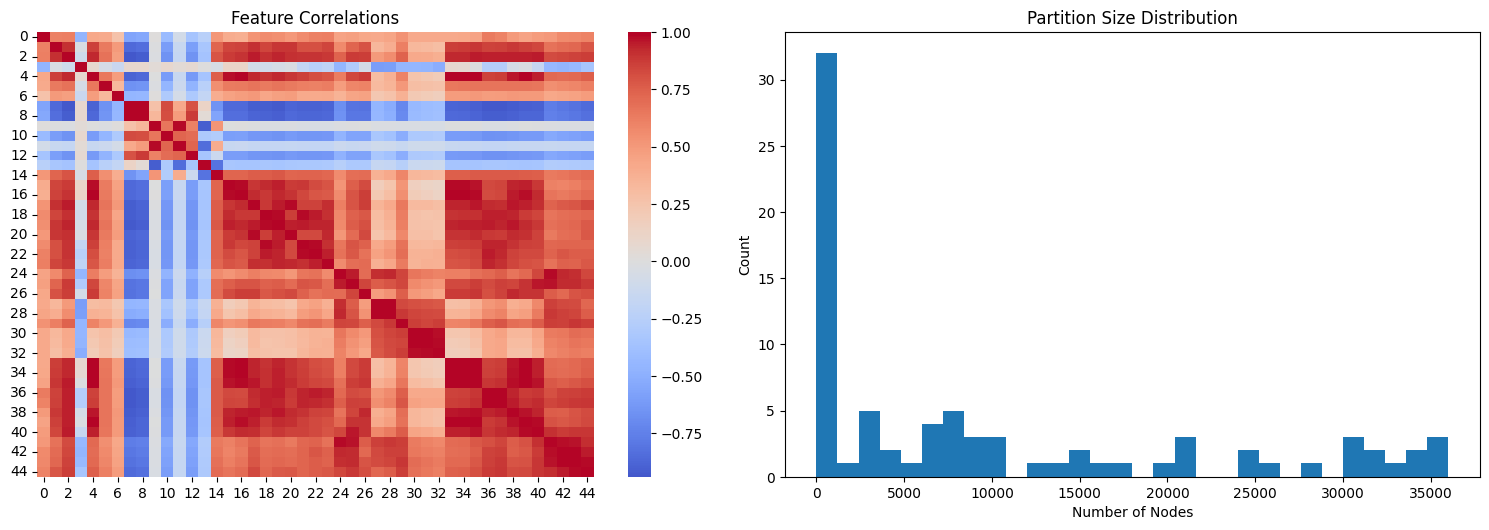

<Figure size 1500x1000 with 0 Axes>


Analyzing design 2


/var/folders/n3/dkf1dhtx7_z72kxwtk9dwfpr0000gn/T/ipykernel_21091/3096810837.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path)
/var/folders/n3

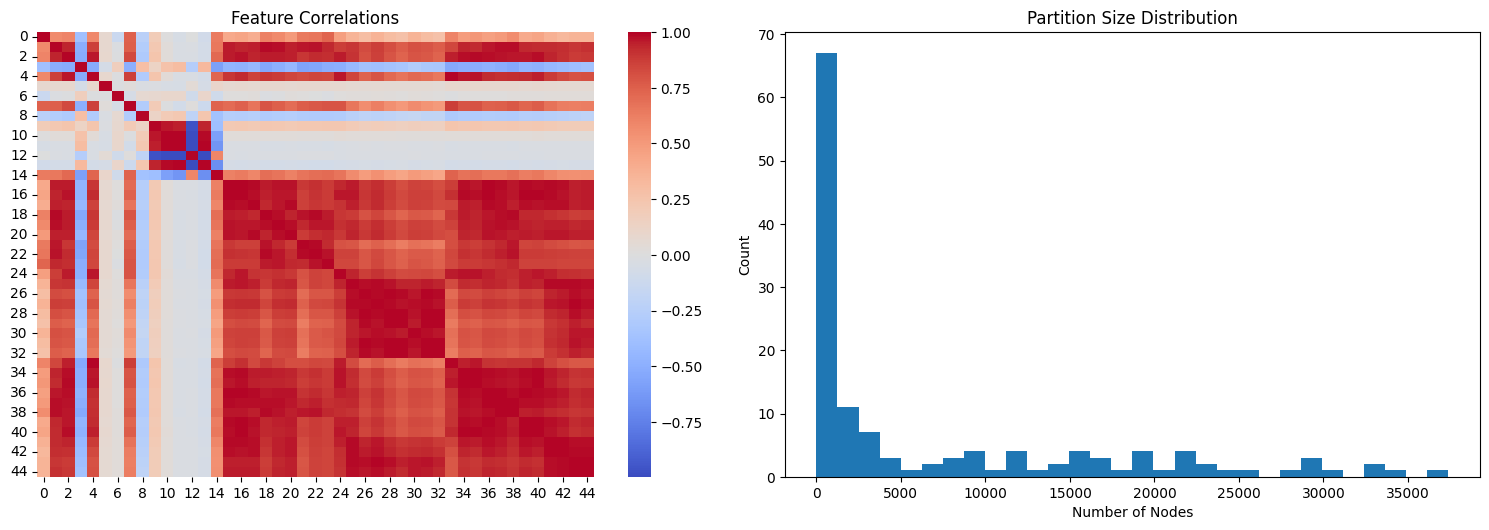

<Figure size 1500x1000 with 0 Axes>


Analyzing design 3


/var/folders/n3/dkf1dhtx7_z72kxwtk9dwfpr0000gn/T/ipykernel_21091/3096810837.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path)
/var/folders/n3

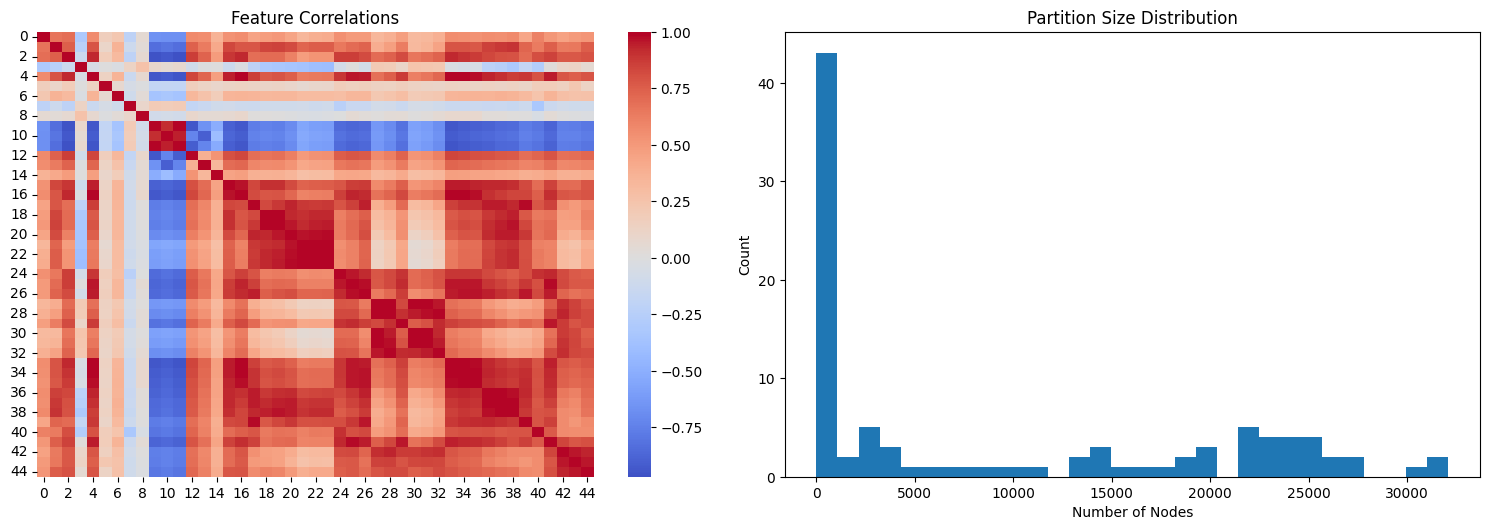

<Figure size 1500x1000 with 0 Axes>


Analyzing design 5


/var/folders/n3/dkf1dhtx7_z72kxwtk9dwfpr0000gn/T/ipykernel_21091/3096810837.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path)
/var/folders/n3

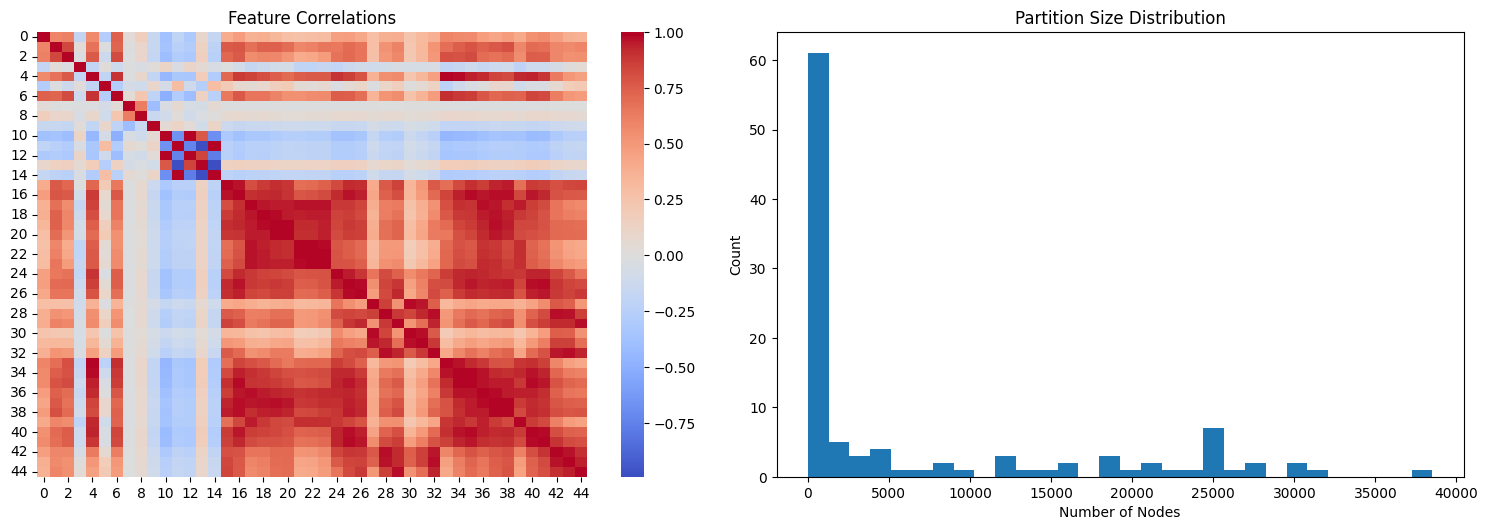

<Figure size 1500x1000 with 0 Axes>


Analyzing design 6


/var/folders/n3/dkf1dhtx7_z72kxwtk9dwfpr0000gn/T/ipykernel_21091/3096810837.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path)
/var/folders/n3

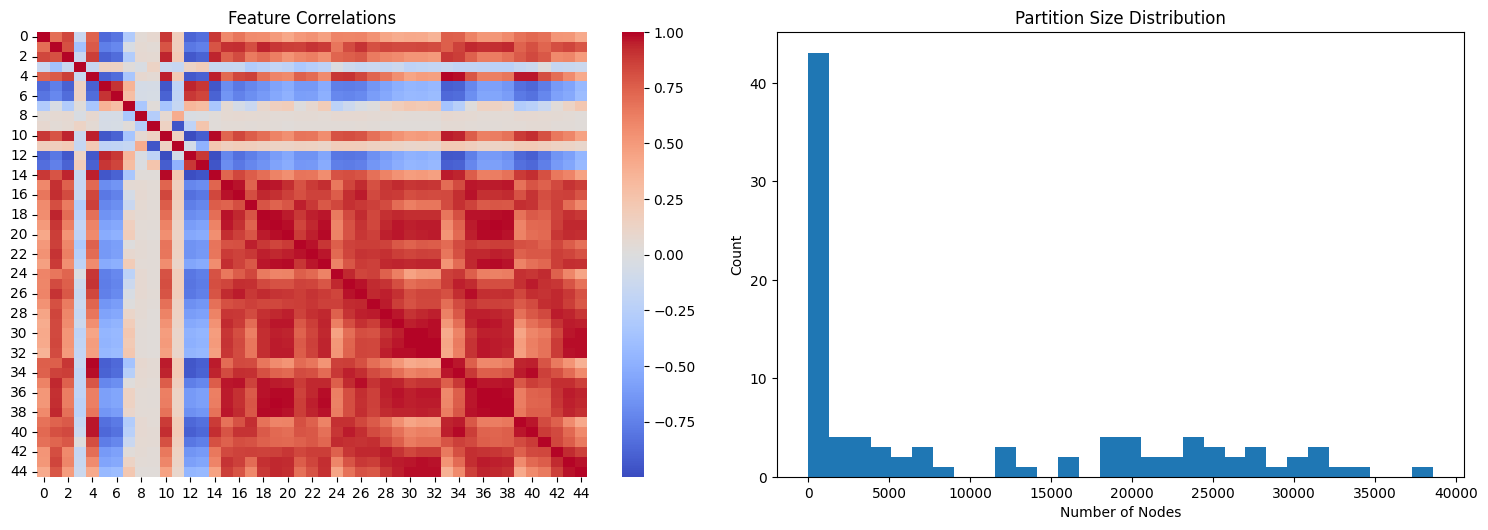

<Figure size 1500x1000 with 0 Axes>


Analyzing design 7


/var/folders/n3/dkf1dhtx7_z72kxwtk9dwfpr0000gn/T/ipykernel_21091/3096810837.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path)
/var/folders/n3

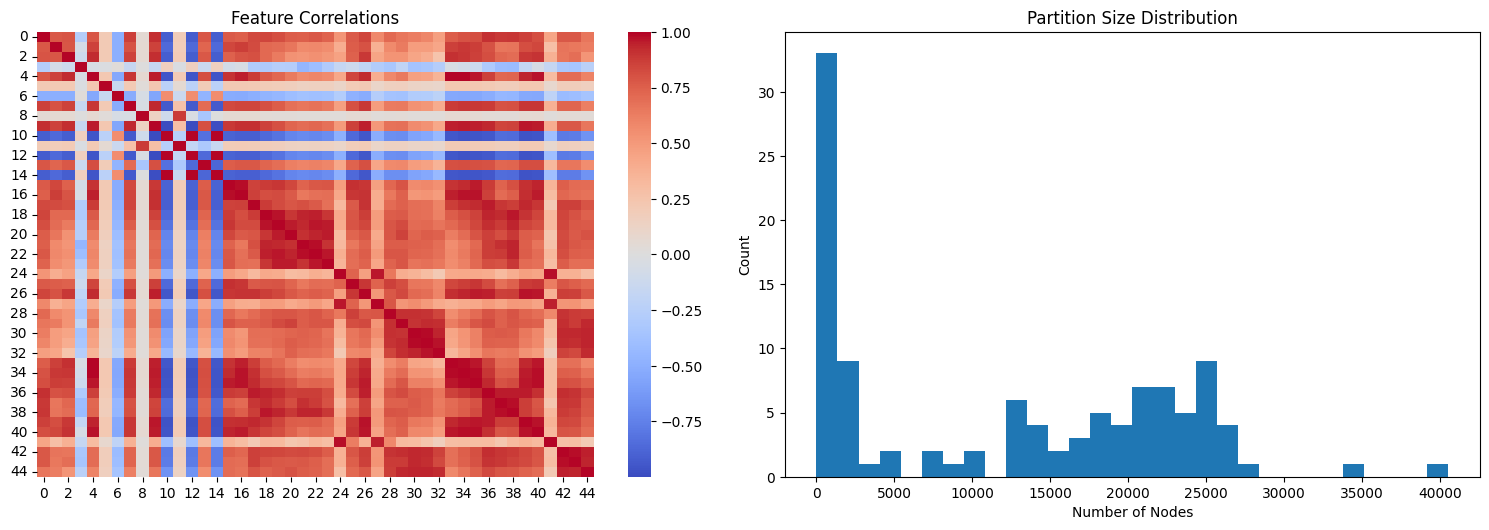

<Figure size 1500x1000 with 0 Axes>


Analyzing design 9


/var/folders/n3/dkf1dhtx7_z72kxwtk9dwfpr0000gn/T/ipykernel_21091/3096810837.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path)
/var/folders/n3

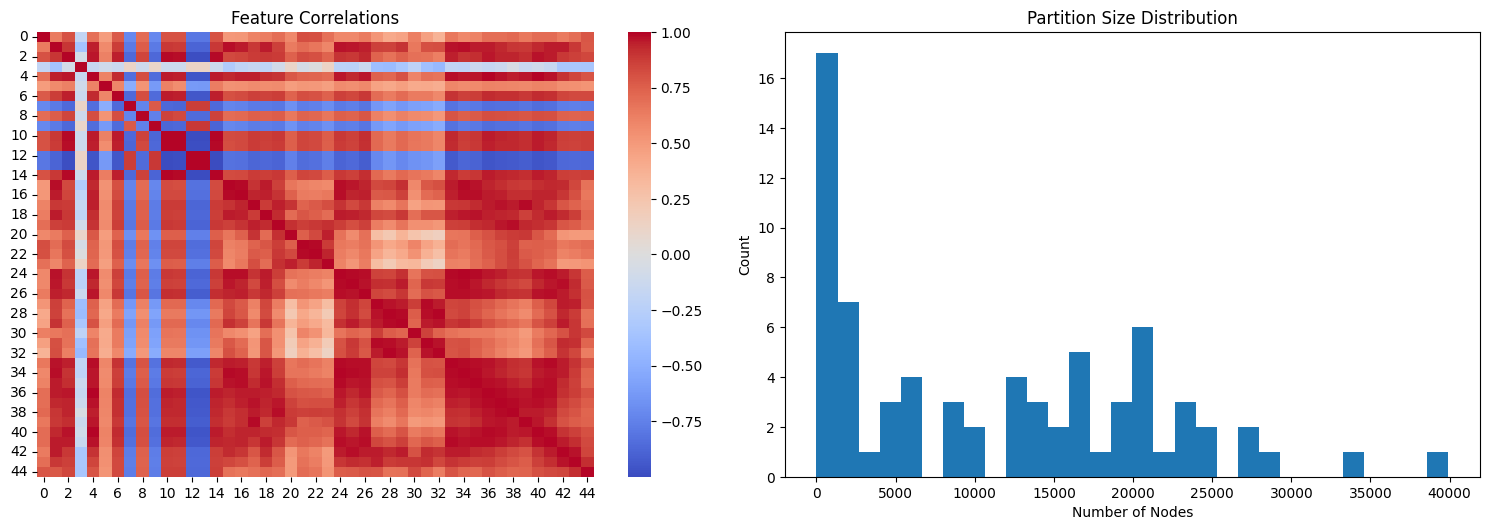

<Figure size 1500x1000 with 0 Axes>


Analyzing design 11


/var/folders/n3/dkf1dhtx7_z72kxwtk9dwfpr0000gn/T/ipykernel_21091/3096810837.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path)
/var/folders/n3

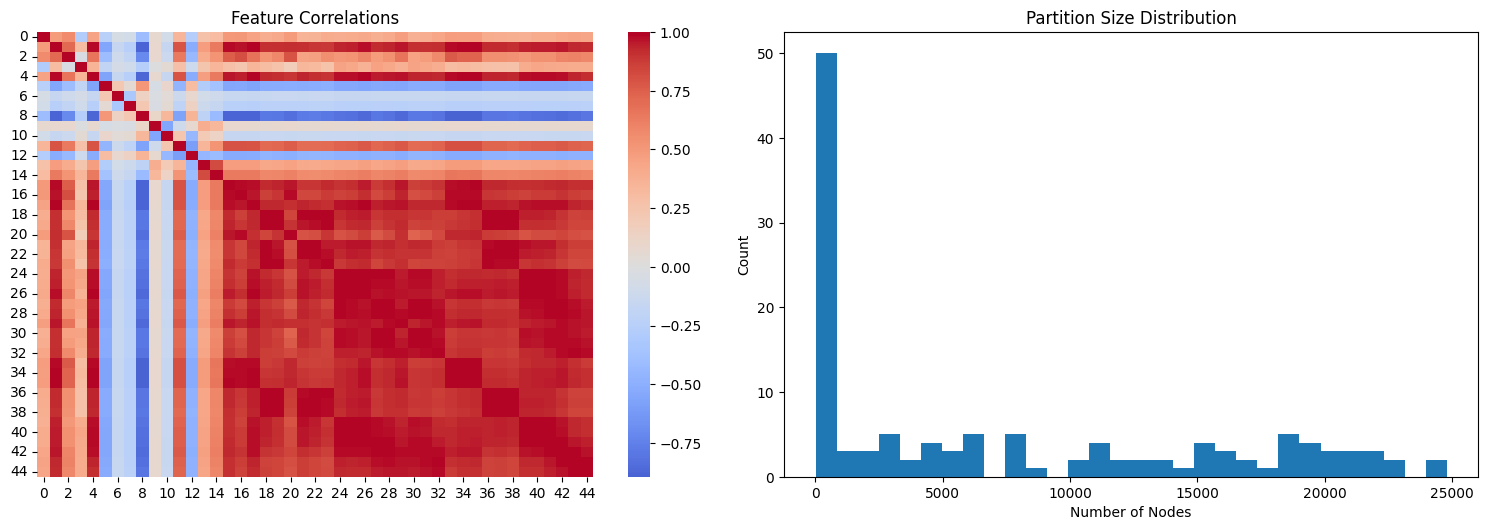

<Figure size 1500x1000 with 0 Axes>


Analyzing design 14


/var/folders/n3/dkf1dhtx7_z72kxwtk9dwfpr0000gn/T/ipykernel_21091/3096810837.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path)
/var/folders/n3

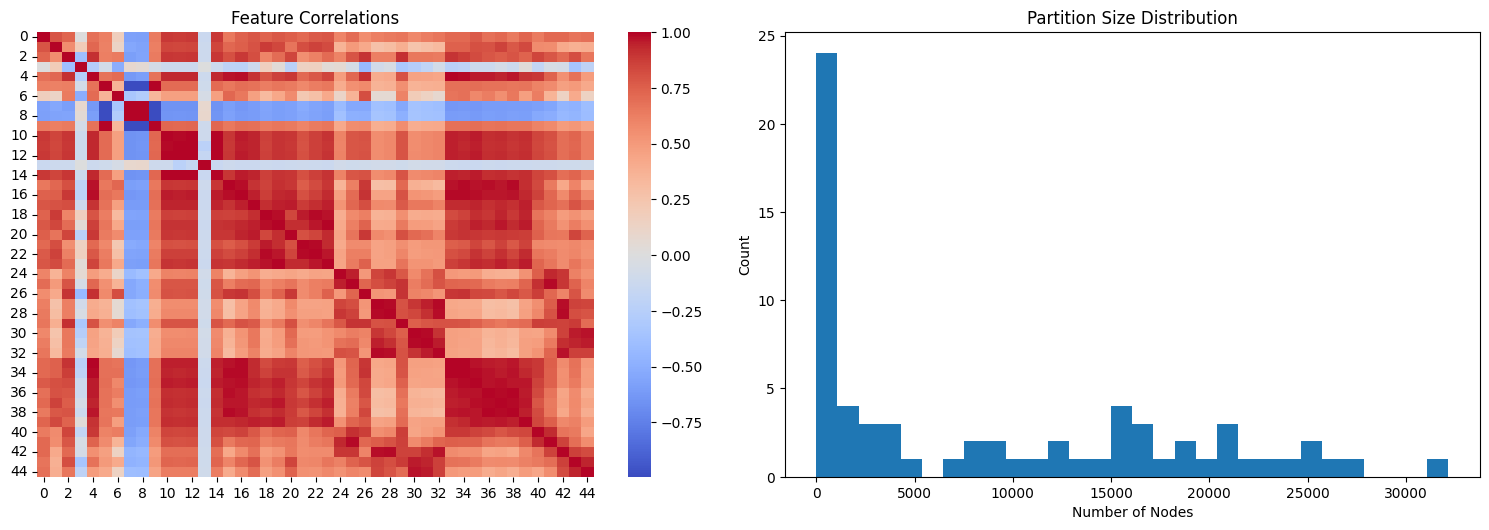

<Figure size 1500x1000 with 0 Axes>


Analyzing design 16


/var/folders/n3/dkf1dhtx7_z72kxwtk9dwfpr0000gn/T/ipykernel_21091/3096810837.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path)
/var/folders/n3

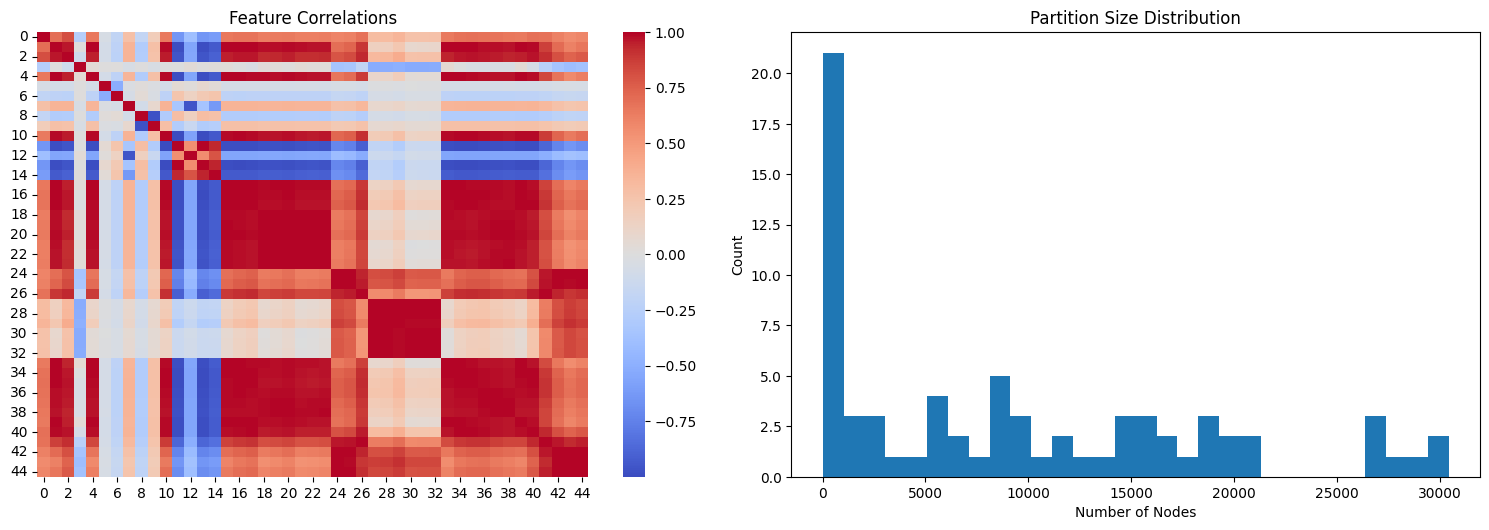

<Figure size 1500x1000 with 0 Axes>


Summary Statistics Across All Designs:

Design 1:
  Number of partitions: 81
  Total nodes: 797938
  Most discriminative features: [ 0 44 41 43 25]
  Average partition density: inf

Design 2:
  Number of partitions: 136
  Total nodes: 951166
  Most discriminative features: [ 0 44 43 42 25]
  Average partition density: inf

Design 3:
  Number of partitions: 97
  Total nodes: 901254
  Most discriminative features: [ 0 44 43 27 42]
  Average partition density: inf

Design 5:
  Number of partitions: 107
  Total nodes: 727341
  Most discriminative features: [ 0 44 43 42 27]
  Average partition density: inf

Design 6:
  Number of partitions: 99
  Total nodes: 998122
  Most discriminative features: [ 0 44 43 42 41]
  Average partition density: inf

Design 7:
  Number of partitions: 109
  Total nodes: 1319052
  Most discriminative features: [ 0 41 27 24 44]
  Average partition density: inf

Design 9:
  Number of partitions: 72
  Total nodes: 810812
  Most discriminative features: [ 0 44 43 42

/var/folders/n3/dkf1dhtx7_z72kxwtk9dwfpr0000gn/T/ipykernel_21091/3096810837.py:189: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path)


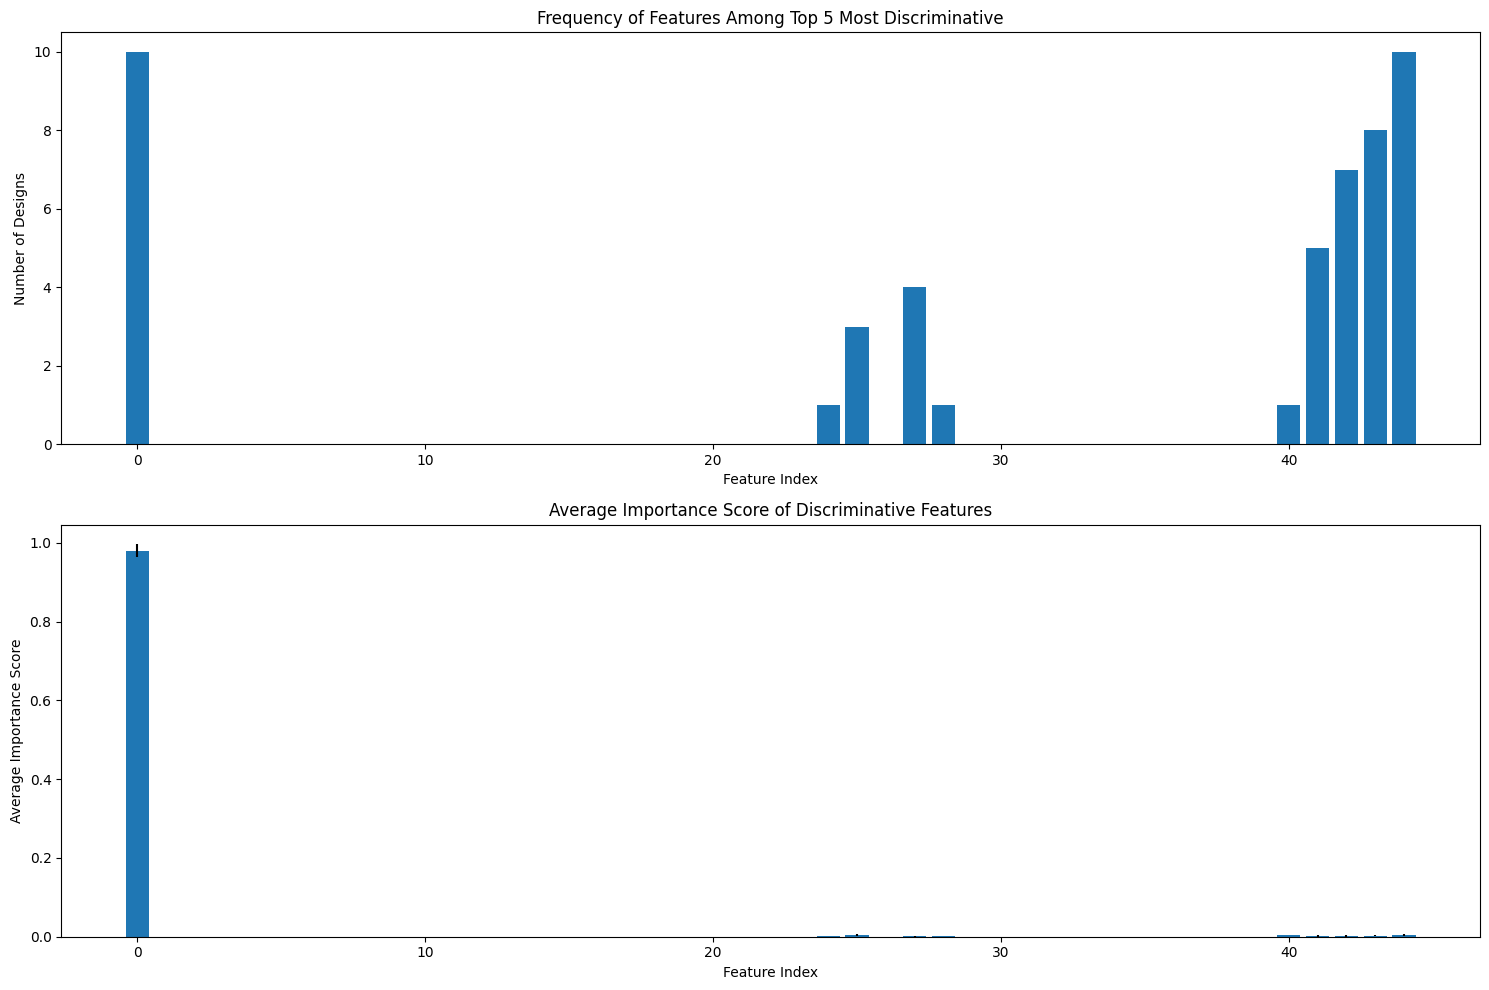


Most Discriminative Features Summary:

Feature 0:
  Appears in top 5 for 10 designs
  Average importance: 0.9800 ± 0.0160

Feature 44:
  Appears in top 5 for 10 designs
  Average importance: 0.0037 ± 0.0029

Feature 43:
  Appears in top 5 for 8 designs
  Average importance: 0.0028 ± 0.0020

Feature 42:
  Appears in top 5 for 7 designs
  Average importance: 0.0018 ± 0.0018

Feature 41:
  Appears in top 5 for 5 designs
  Average importance: 0.0026 ± 0.0022

Feature 27:
  Appears in top 5 for 4 designs
  Average importance: 0.0014 ± 0.0009

Feature 25:
  Appears in top 5 for 3 designs
  Average importance: 0.0039 ± 0.0025

Feature 24:
  Appears in top 5 for 1 designs
  Average importance: 0.0006 ± 0.0000

Feature 28:
  Appears in top 5 for 1 designs
  Average importance: 0.0007 ± 0.0000

Feature 40:
  Appears in top 5 for 1 designs
  Average importance: 0.0056 ± 0.0000


In [48]:
def analyze_placement_partitions(design_list):
    """
    Analyze patterns in placement partitions to understand their creation
    """
    results = []
    
    for design in design_list:
        print(f"\nAnalyzing design {design}")
        
        # Load placement partition and node features
        pl_path = f"../../data/superblue/superblue_{design}/pl_part_dict.pkl"
        data_path = f"../../data/superblue/superblue_{design}/pyg_data.pkl"
        
        with open(pl_path, 'rb') as f:
            pl_data = pickle.load(f)
        data = torch.load(data_path)
        node_features = data.node_features.numpy()
        
        # Analyze feature distributions per partition
        partition_features = analyze_partition_features(pl_data, node_features)
        
        # Analyze spatial characteristics
        spatial_stats = analyze_spatial_characteristics(pl_data, node_features)
        
        results.append({
            'design': design,
            'partition_features': partition_features,
            'spatial_stats': spatial_stats,
            'num_partitions': len(set(pl_data.values())),
            'num_nodes': len(pl_data)
        })
        
        # Plot feature distributions by partition
        plot_feature_distributions(partition_features, design)
        
        # Plot spatial characteristics
        plot_spatial_characteristics(spatial_stats, design)
        
    return results

def analyze_partition_features(partition, node_features):
    """
    Analyze feature distributions within each partition
    """
    partitions = defaultdict(list)
    for node, cluster in partition.items():
        partitions[cluster].append(node_features[node])
    
    stats = {}
    for cluster, features in partitions.items():
        features = np.array(features)
        stats[cluster] = {
            'mean': np.mean(features, axis=0),
            'std': np.std(features, axis=0),
            'min': np.min(features, axis=0),
            'max': np.max(features, axis=0),
            'size': len(features)
        }
    
    return stats

def analyze_spatial_characteristics(partition, node_features):
    """
    Analyze spatial characteristics of partitions
    Focus on features that might represent physical location (e.g., 6-15)
    """
    spatial_features = node_features[:, 6:15]  # Physical-related features
    
    spatial_stats = {}
    for cluster in set(partition.values()):
        cluster_nodes = [n for n, c in partition.items() if c == cluster]
        cluster_features = spatial_features[cluster_nodes]
        
        spatial_stats[cluster] = {
            'centroid': np.mean(cluster_features, axis=0),
            'radius': np.std(cluster_features, axis=0),
            'density': len(cluster_nodes) / np.prod(np.std(cluster_features, axis=0)),
            'size': len(cluster_nodes)
        }
    
    return spatial_stats

def plot_feature_distributions(partition_features, design):
    """
    Plot feature distributions for each partition
    """
    plt.figure(figsize=(15, 10))
    
    # Plot mean feature values across partitions
    means = np.array([stats['mean'] for stats in partition_features.values()])
    
    #plt.subplot(2, 2, 1)
    #plt.boxplot([means[:, i] for i in range(means.shape[1])])
    #plt.title(f'Feature Distributions Across Partitions\nDesign {design}')
    #plt.xlabel('Feature Index')
    #plt.ylabel('Mean Value')
    
    # Plot partition sizes
    sizes = [stats['size'] for stats in partition_features.values()]
    
    plt.subplot(2, 2, 2)
    plt.hist(sizes, bins=30)
    plt.title('Partition Size Distribution')
    plt.xlabel('Number of Nodes')
    plt.ylabel('Count')
    
    # Plot feature correlations with partition assignment
    plt.subplot(2, 2, 1)
    corr_matrix = np.corrcoef(means.T)
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
    plt.title('Feature Correlations')
    
    plt.tight_layout()
    plt.show()

def plot_spatial_characteristics(spatial_stats, design):
    """
    Plot spatial characteristics of partitions
    """
    plt.figure(figsize=(15, 10))
    
    # Plot partition centroids
    #centroids = np.array([stats['centroid'] for stats in spatial_stats.values()])
    
    #plt.subplot(2, 2, 1)
    #plt.scatter(centroids[:, 0], centroids[:, 1], alpha=0.5)
    #plt.title(f'Partition Centroids\nDesign {design}')
    #plt.xlabel('Feature 1')
    #plt.ylabel('Feature 2')
    
    # Plot partition radii
    #radii = np.array([stats['radius'] for stats in spatial_stats.values()])
    
    #plt.subplot(2, 2, 2)
    #plt.boxplot([radii[:, i] for i in range(radii.shape[1])])
    #plt.title('Partition Radii Distribution')
    #plt.xlabel('Spatial Dimension')
    #plt.ylabel('Radius')
    
    # Plot density vs size
    #densities = [stats['density'] for stats in spatial_stats.values()]
    #sizes = [stats['size'] for stats in spatial_stats.values()]
    
    #plt.subplot(2, 2, 3)
    #plt.scatter(sizes, densities, alpha=0.5)
    #plt.title('Partition Density vs Size')
    #plt.xlabel('Number of Nodes')
    #plt.ylabel('Density')
    
    plt.tight_layout()
    plt.show()

# Run analysis
design_list = [1, 2, 3, 5, 6, 7, 9, 11, 14, 16]
results = analyze_placement_partitions(design_list)

# Print summary findings
print("\nSummary Statistics Across All Designs:")
for design_result in results:
    design = design_result['design']
    print(f"\nDesign {design}:")
    print(f"  Number of partitions: {design_result['num_partitions']}")
    print(f"  Total nodes: {design_result['num_nodes']}")
    
    # Analyze feature importance
    feature_vars = np.var([stats['mean'] for stats in design_result['partition_features'].values()], axis=0)
    top_features = np.argsort(-feature_vars)[:5]
    print(f"  Most discriminative features: {top_features}")
    
    # Analyze spatial patterns
    spatial_metrics = design_result['spatial_stats']
    avg_density = np.mean([stats['density'] for stats in spatial_metrics.values()])
    print(f"  Average partition density: {avg_density:.2f}")

def analyze_discriminative_features(design_list):
    """
    Create histogram of most discriminative features across designs
    """
    feature_counts = defaultdict(int)
    feature_importance_scores = defaultdict(list)
    
    for design in design_list:
        # Load data
        pl_path = f"../../data/superblue/superblue_{design}/pl_part_dict.pkl"
        data_path = f"../../data/superblue/superblue_{design}/pyg_data.pkl"
        
        with open(pl_path, 'rb') as f:
            pl_data = pickle.load(f)
        data = torch.load(data_path)
        node_features = data.node_features.numpy()
        
        # Convert partition dict to labels array
        labels = np.array([pl_data[i] for i in range(len(pl_data))])
        
        # Calculate feature importance using variance between partitions
        partition_means = defaultdict(list)
        for label, feature in zip(labels, node_features):
            partition_means[label].append(feature)
        
        # Calculate mean feature vector for each partition
        partition_means = {k: np.mean(v, axis=0) for k, v in partition_means.items()}
        
        # Calculate variance of means across partitions
        means_array = np.array(list(partition_means.values()))
        importance = np.var(means_array, axis=0)
        importance = importance / np.sum(importance)  # Normalize
        
        # Record top 5 features
        top_features = np.argsort(-importance)[:5]
        for idx in top_features:
            feature_counts[idx] += 1
            feature_importance_scores[idx].append(importance[idx])
    
    # Plot results
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Feature frequency histogram
    plt.subplot(2, 1, 1)
    features = list(feature_counts.keys())
    counts = list(feature_counts.values())
    
    plt.bar(features, counts)
    plt.title('Frequency of Features Among Top 5 Most Discriminative')
    plt.xlabel('Feature Index')
    plt.ylabel('Number of Designs')
    
    # Plot 2: Average importance scores
    plt.subplot(2, 1, 2)
    avg_importance = [np.mean(scores) for scores in feature_importance_scores.values()]
    std_importance = [np.std(scores) for scores in feature_importance_scores.values()]
    
    plt.bar(features, avg_importance, yerr=std_importance)
    plt.title('Average Importance Score of Discriminative Features')
    plt.xlabel('Feature Index')
    plt.ylabel('Average Importance Score')
    
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nMost Discriminative Features Summary:")
    for feature in sorted(feature_counts.keys(), 
                         key=lambda x: feature_counts[x], 
                         reverse=True):
        print(f"\nFeature {feature}:")
        print(f"  Appears in top 5 for {feature_counts[feature]} designs")
        print(f"  Average importance: {np.mean(feature_importance_scores[feature]):.4f} ± {np.std(feature_importance_scores[feature]):.4f}")

# Run analysis
design_list = [1, 2, 3, 5, 6, 7, 9, 11, 14, 16]
analyze_discriminative_features(design_list)